In [2]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization,Activation, Flatten, \
Conv3D,MaxPooling3D,Input,GlobalAveragePooling3D, Conv2D, MaxPooling2D,LSTM
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model,X_test,y_test,type_cm,display_labels,cmap=plt.cm.Blues,normalize=True):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)
    c_mat = confusion_matrix(y_test,y_pred)
    if normalize:
        c_mat = np.round(c_mat.astype('float') / c_mat.sum(axis=1)[:, np.newaxis],4)
    plt.imshow(c_mat, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix'+type_cm)
    plt.colorbar()
    tick_marks = np.arange(len(display_labels))
    plt.xticks(tick_marks, display_labels, rotation=0)
    plt.yticks(tick_marks, display_labels)
    thresh = c_mat.max() / 2.
    for i, j in itertools.product(range(c_mat.shape[0]), range(c_mat.shape[1])):
        plt.text(j, i, c_mat[i, j],
                 horizontalalignment="center",
                 color="white" if c_mat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def disp_confusion_matrix(model,X,y,type_cm,class_label):
    disp = plot_confusion_matrix(model, X, y, type_cm,display_labels=class_label,
                                 cmap=plt.cm.Blues)
    
def testers(lr,model,epochs=100,verb=1,batch_size=30):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy',optimizer=opt,
             metrics=['accuracy'])
    num_epochs = epochs
    history = model.fit(X_train,y_train, epochs = num_epochs, batch_size=batch_size,\
                        shuffle=False, verbose=verb,validation_data=(X_test,y_test))
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Costo vs Época')
    plt.ylabel('Costo')
    plt.xlabel('Época')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()
    
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    disp_confusion_matrix(model,X_test,y_test,' first six set A',class_label=['Left Hand','Right Hand','Neutral']) 
    
def keras_model_memory_usage_in_bytes(model, *, batch_size: int):
    """
    Return the estimated memory usage of a given Keras model in bytes.
    This includes the model weights and layers, but excludes the dataset.

    The model shapes are multipled by the batch size, but the weights are not.

    Args:
        model: A Keras model.
        batch_size: The batch size you intend to run the model with. If you
            have already specified the batch size in the model itself, then
            pass `1` as the argument here.
    Returns:
        An estimate of the Keras model's memory usage in bytes.

    """
    default_dtype = tf.keras.backend.floatx()
    shapes_mem_count = 0
    internal_model_mem_count = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            internal_model_mem_count += keras_model_memory_usage_in_bytes(
                layer, batch_size=batch_size
            )
        single_layer_mem = tf.as_dtype(layer.dtype or default_dtype).size
        out_shape = layer.output_shape
        if isinstance(out_shape, list):
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.trainable_weights]
    )
    non_trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.non_trainable_weights]
    )

    total_memory = (
        batch_size * shapes_mem_count
        + internal_model_mem_count
        + trainable_count
        + non_trainable_count
    )
    return total_memory
def result_plots(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Costo vs Época')
    plt.ylabel('Costo')
    plt.xlabel('Época')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()
    
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    disp_confusion_matrix(model,X_test,y_test,' first six set A',class_label=['Left Hand','Right Hand','Neutral']) 

In [3]:
path ='Pre-Dat/Raw/Fp1-Fp2-F3-F4-C3-C4-P3-P4-O1-O2-A1-A2-F7-F8-T3-T4-T5-T6-Fz-Cz-Pz'
extension = ''
X_train = np.load(path+'/X_train'+f'{extension}.npy')
X_test = np.load(path+'/X_test'+f'{extension}.npy')
y_train = np.load(path+'/y_train'+f'{extension}.npy')
y_test = np.load(path+'/y_test'+f'{extension}.npy')

In [4]:
print(f'X train shape: {X_train.shape}')
print(f'y train shape: {y_train.shape}')
print(f'X test shape: {X_test.shape}')
print(f'y test shape: {y_test.shape}')

X train shape: (10880, 200, 21)
y train shape: (10880, 3)
X test shape: (2720, 200, 21)
y test shape: (2720, 3)


In [5]:
def LSTM_model (n_steps,n_features,activation='tanh',dense_activation='relu',dropout_rate=0.2,batch_normalization=True,init_mode='glorot_normal'):
    model = Sequential()
    model.add(Input(shape=(n_steps,n_features)))
    model.add(LSTM(150,activation=activation,return_sequences=True))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(150,activation=activation))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(150,kernel_initializer=init_mode))
    model.add(Activation(dense_activation))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(150, kernel_initializer=init_mode))
    model.add(Activation(dense_activation))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
#     model.add(Dense(150,activation=dense_activation,kernel_initializer=init_mode))
#     if batch_normalization:
#         model.add(BatchNormalization()) 
    model.add(Dense(3,activation='softmax',kernel_initializer=init_mode,kernel_regularizer=keras.regularizers.l2(l=0.01)))
    return model

In [6]:
model_t = LSTM_model(200,21,activation='tanh',dense_activation='hard_sigmoid',dropout_rate=0.5)
model_t.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200, 150)          103200    
                                                                 
 dropout (Dropout)           (None, 200, 150)          0         
                                                                 
 lstm_1 (LSTM)               (None, 150)               180600    
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                                                                 
 dense (Dense)               (None, 150)               22650     
                                                                 
 activation (Activation)     (None, 150)               0         
                                                                 
 batch_normalization (BatchN  (None, 150)              6

In [7]:
keras_model_memory_usage_in_bytes(model_t,batch_size=64)

16075521

Epoch 1/400
109/109 [==============================] - 38s 55ms/step - loss: 1.5624 - accuracy: 0.3526 - val_loss: 1.1950 - val_accuracy: 0.3368
Epoch 2/400
109/109 [==============================] - 3s 31ms/step - loss: 1.2802 - accuracy: 0.3963 - val_loss: 1.1126 - val_accuracy: 0.3371
Epoch 3/400
109/109 [==============================] - 3s 31ms/step - loss: 1.1311 - accuracy: 0.4570 - val_loss: 1.0477 - val_accuracy: 0.5085
Epoch 4/400
109/109 [==============================] - 3s 31ms/step - loss: 1.0385 - accuracy: 0.5080 - val_loss: 1.0301 - val_accuracy: 0.4989
Epoch 5/400
109/109 [==============================] - 3s 31ms/step - loss: 0.9574 - accuracy: 0.5644 - val_loss: 0.9664 - val_accuracy: 0.5386
Epoch 6/400
109/109 [==============================] - 3s 30ms/step - loss: 0.9135 - accuracy: 0.5953 - val_loss: 0.8828 - val_accuracy: 0.6151
Epoch 7/400
109/109 [==============================] - 3s 31ms/step - loss: 0.8708 - accuracy: 0.6212 - val_loss: 0.9121 - val_accuracy

109/109 [==============================] - 3s 30ms/step - loss: 0.8527 - accuracy: 0.6109 - val_loss: 0.9486 - val_accuracy: 0.5614
Epoch 58/400
109/109 [==============================] - 3s 31ms/step - loss: 0.8447 - accuracy: 0.6181 - val_loss: 0.8200 - val_accuracy: 0.6426
Epoch 59/400
109/109 [==============================] - 3s 29ms/step - loss: 0.8103 - accuracy: 0.6333 - val_loss: 0.7934 - val_accuracy: 0.6493
Epoch 60/400
109/109 [==============================] - 3s 29ms/step - loss: 0.7639 - accuracy: 0.6620 - val_loss: 0.7729 - val_accuracy: 0.6577
Epoch 61/400
109/109 [==============================] - 3s 29ms/step - loss: 0.7401 - accuracy: 0.6736 - val_loss: 0.8246 - val_accuracy: 0.6441
Epoch 62/400
109/109 [==============================] - 3s 29ms/step - loss: 0.7348 - accuracy: 0.6865 - val_loss: 0.7722 - val_accuracy: 0.6625
Epoch 63/400
109/109 [==============================] - 3s 29ms/step - loss: 0.7051 - accuracy: 0.6997 - val_loss: 0.7647 - val_accuracy: 0.672

109/109 [==============================] - 3s 31ms/step - loss: 0.1835 - accuracy: 0.9423 - val_loss: 0.6686 - val_accuracy: 0.8136
Epoch 114/400
109/109 [==============================] - 3s 31ms/step - loss: 0.1594 - accuracy: 0.9502 - val_loss: 0.7084 - val_accuracy: 0.8246
Epoch 115/400
109/109 [==============================] - 3s 29ms/step - loss: 0.1687 - accuracy: 0.9480 - val_loss: 0.6918 - val_accuracy: 0.8151
Epoch 116/400
109/109 [==============================] - 3s 29ms/step - loss: 0.1744 - accuracy: 0.9451 - val_loss: 0.6729 - val_accuracy: 0.8210
Epoch 117/400
109/109 [==============================] - 3s 29ms/step - loss: 0.1790 - accuracy: 0.9449 - val_loss: 0.7283 - val_accuracy: 0.8029
Epoch 118/400
109/109 [==============================] - 3s 29ms/step - loss: 0.1640 - accuracy: 0.9474 - val_loss: 0.6570 - val_accuracy: 0.8335
Epoch 119/400
109/109 [==============================] - 3s 28ms/step - loss: 0.1342 - accuracy: 0.9614 - val_loss: 0.7088 - val_accuracy:

109/109 [==============================] - 3s 29ms/step - loss: 0.0801 - accuracy: 0.9794 - val_loss: 0.7603 - val_accuracy: 0.8346
Epoch 170/400
109/109 [==============================] - 3s 28ms/step - loss: 0.0621 - accuracy: 0.9837 - val_loss: 0.7788 - val_accuracy: 0.8412
Epoch 171/400
109/109 [==============================] - 3s 29ms/step - loss: 0.0631 - accuracy: 0.9841 - val_loss: 0.7892 - val_accuracy: 0.8423
Epoch 172/400
109/109 [==============================] - 3s 29ms/step - loss: 0.0881 - accuracy: 0.9750 - val_loss: 0.8238 - val_accuracy: 0.8364
Epoch 173/400
109/109 [==============================] - 3s 29ms/step - loss: 0.0671 - accuracy: 0.9817 - val_loss: 0.7964 - val_accuracy: 0.8430
Epoch 174/400
109/109 [==============================] - 3s 29ms/step - loss: 0.0587 - accuracy: 0.9846 - val_loss: 0.8076 - val_accuracy: 0.8404
Epoch 175/400
109/109 [==============================] - 3s 29ms/step - loss: 0.1359 - accuracy: 0.9609 - val_loss: 0.6508 - val_accuracy:

109/109 [==============================] - 3s 29ms/step - loss: 0.0581 - accuracy: 0.9853 - val_loss: 0.8719 - val_accuracy: 0.8320
Epoch 226/400
109/109 [==============================] - 3s 29ms/step - loss: 0.0358 - accuracy: 0.9912 - val_loss: 1.0721 - val_accuracy: 0.8268
Epoch 227/400
109/109 [==============================] - 3s 31ms/step - loss: 0.0497 - accuracy: 0.9864 - val_loss: 0.9156 - val_accuracy: 0.8419
Epoch 228/400
109/109 [==============================] - 3s 31ms/step - loss: 0.0450 - accuracy: 0.9889 - val_loss: 0.9887 - val_accuracy: 0.8415
Epoch 229/400
109/109 [==============================] - 3s 30ms/step - loss: 0.0343 - accuracy: 0.9923 - val_loss: 0.8865 - val_accuracy: 0.8382
Epoch 230/400
109/109 [==============================] - 3s 30ms/step - loss: 0.0518 - accuracy: 0.9870 - val_loss: 0.9357 - val_accuracy: 0.8346
Epoch 231/400
109/109 [==============================] - 3s 30ms/step - loss: 0.0378 - accuracy: 0.9898 - val_loss: 0.9543 - val_accuracy:

109/109 [==============================] - 3s 30ms/step - loss: 0.0298 - accuracy: 0.9932 - val_loss: 0.8179 - val_accuracy: 0.8574
Epoch 282/400
109/109 [==============================] - 3s 30ms/step - loss: 0.0321 - accuracy: 0.9921 - val_loss: 0.9216 - val_accuracy: 0.8489
Epoch 283/400
109/109 [==============================] - 3s 30ms/step - loss: 0.0428 - accuracy: 0.9889 - val_loss: 0.8838 - val_accuracy: 0.8449
Epoch 284/400
109/109 [==============================] - 3s 30ms/step - loss: 0.0354 - accuracy: 0.9916 - val_loss: 0.7847 - val_accuracy: 0.8301
Epoch 285/400
109/109 [==============================] - 3s 30ms/step - loss: 0.0532 - accuracy: 0.9874 - val_loss: 0.8478 - val_accuracy: 0.8404
Epoch 286/400
109/109 [==============================] - 3s 30ms/step - loss: 0.0455 - accuracy: 0.9887 - val_loss: 0.8487 - val_accuracy: 0.8449
Epoch 287/400
109/109 [==============================] - 3s 30ms/step - loss: 0.0428 - accuracy: 0.9903 - val_loss: 0.8860 - val_accuracy:

109/109 [==============================] - 3s 31ms/step - loss: 0.0271 - accuracy: 0.9930 - val_loss: 0.9111 - val_accuracy: 0.8463
Epoch 338/400
109/109 [==============================] - 3s 31ms/step - loss: 0.0191 - accuracy: 0.9967 - val_loss: 1.0179 - val_accuracy: 0.8404
Epoch 339/400
109/109 [==============================] - 3s 31ms/step - loss: 0.0215 - accuracy: 0.9957 - val_loss: 0.9290 - val_accuracy: 0.8419
Epoch 340/400
109/109 [==============================] - 3s 31ms/step - loss: 0.0323 - accuracy: 0.9923 - val_loss: 1.0004 - val_accuracy: 0.8426
Epoch 341/400
109/109 [==============================] - 3s 31ms/step - loss: 0.0370 - accuracy: 0.9915 - val_loss: 0.9005 - val_accuracy: 0.8419
Epoch 342/400
109/109 [==============================] - 3s 31ms/step - loss: 0.0254 - accuracy: 0.9946 - val_loss: 1.0388 - val_accuracy: 0.8456
Epoch 343/400
109/109 [==============================] - 3s 31ms/step - loss: 0.0241 - accuracy: 0.9941 - val_loss: 0.9264 - val_accuracy:

109/109 [==============================] - 4s 33ms/step - loss: 0.0279 - accuracy: 0.9941 - val_loss: 0.9071 - val_accuracy: 0.8408
Epoch 394/400
109/109 [==============================] - 4s 32ms/step - loss: 0.0390 - accuracy: 0.9895 - val_loss: 0.9723 - val_accuracy: 0.8419
Epoch 395/400
109/109 [==============================] - 3s 32ms/step - loss: 0.0369 - accuracy: 0.9912 - val_loss: 0.9064 - val_accuracy: 0.8544
Epoch 396/400
109/109 [==============================] - 3s 32ms/step - loss: 0.0281 - accuracy: 0.9942 - val_loss: 0.8862 - val_accuracy: 0.8607
Epoch 397/400
109/109 [==============================] - 3s 31ms/step - loss: 0.0226 - accuracy: 0.9955 - val_loss: 0.9403 - val_accuracy: 0.8562
Epoch 398/400
109/109 [==============================] - 3s 31ms/step - loss: 0.0256 - accuracy: 0.9939 - val_loss: 0.8906 - val_accuracy: 0.8566
Epoch 399/400
109/109 [==============================] - 3s 31ms/step - loss: 0.0204 - accuracy: 0.9952 - val_loss: 1.0051 - val_accuracy:

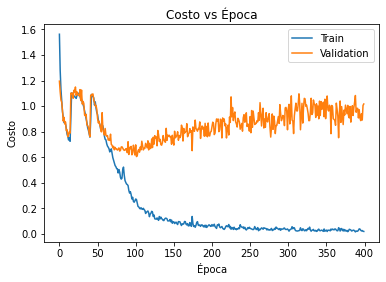

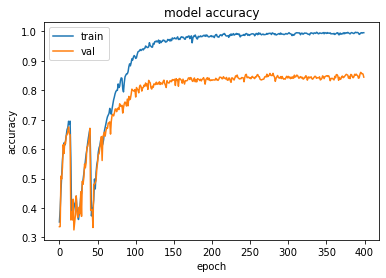

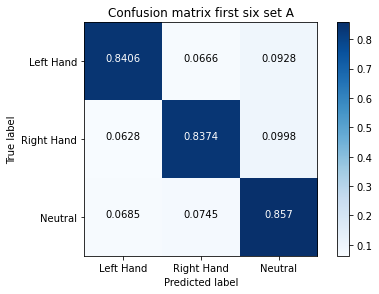

In [8]:
testers(1e-3,model_t,epochs=400,batch_size=100)

In [31]:
def LSTM_model_v2(n_steps,n_features,activation='tanh',dense_activation='relu',dropout_rate=0.2,batch_normalization=True):
    model = Sequential()
    model.add(Input(shape=(n_steps,n_features)))
    model.add(LSTM(100,activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(100,activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(200,activation=dense_activation))
    if batch_normalization:
        model.add(BatchNormalization()) 
    model.add(Dense(100,activation='tanh'))
    if batch_normalization:
        model.add(BatchNormalization()) 
    model.add(Dense(3,activation='softmax',kernel_regularizer=keras.regularizers.l2(l=0.01)))
    return model

In [32]:
model_v2 = LSTM_model(200,21,activation='tanh',dense_activation='relu',dropout_rate=0.5,batch_normalization=True)
model_v2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100)               48800     
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_12 (Dense)            (None, 100)               10100     
                                                                 
 batch_normalization_5 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_13 (Dense)            (None, 3)                 303       
                                                                 
Total params: 59,603
Trainable params: 59,403
Non-trainable params: 200
________________________________________________

In [33]:
keras_model_memory_usage_in_bytes(model_v2,batch_size=128)

265939

Epoch 1/100
29/29 [==============================] - 2s 24ms/step - loss: 1.3583 - accuracy: 0.3714 - val_loss: 1.1463 - val_accuracy: 0.3817
Epoch 2/100
29/29 [==============================] - 0s 15ms/step - loss: 1.2245 - accuracy: 0.3949 - val_loss: 1.1364 - val_accuracy: 0.3783
Epoch 3/100
29/29 [==============================] - 0s 15ms/step - loss: 1.1644 - accuracy: 0.4046 - val_loss: 1.1324 - val_accuracy: 0.3873
Epoch 4/100
29/29 [==============================] - 0s 17ms/step - loss: 1.1407 - accuracy: 0.4223 - val_loss: 1.1240 - val_accuracy: 0.3917
Epoch 5/100
29/29 [==============================] - 0s 17ms/step - loss: 1.1322 - accuracy: 0.4209 - val_loss: 1.1188 - val_accuracy: 0.4152
Epoch 6/100
29/29 [==============================] - 0s 16ms/step - loss: 1.1044 - accuracy: 0.4428 - val_loss: 1.1089 - val_accuracy: 0.4196
Epoch 7/100
29/29 [==============================] - 0s 14ms/step - loss: 1.1028 - accuracy: 0.4541 - val_loss: 1.0992 - val_accuracy: 0.4431
Epoch 

29/29 [==============================] - 0s 14ms/step - loss: 0.3894 - accuracy: 0.8534 - val_loss: 1.0799 - val_accuracy: 0.6060
Epoch 59/100
29/29 [==============================] - 0s 14ms/step - loss: 0.3847 - accuracy: 0.8562 - val_loss: 1.1246 - val_accuracy: 0.6239
Epoch 60/100
29/29 [==============================] - 0s 15ms/step - loss: 0.3970 - accuracy: 0.8487 - val_loss: 1.1345 - val_accuracy: 0.5848
Epoch 61/100
29/29 [==============================] - 0s 14ms/step - loss: 0.4343 - accuracy: 0.8385 - val_loss: 1.0268 - val_accuracy: 0.6306
Epoch 62/100
29/29 [==============================] - 0s 15ms/step - loss: 0.4468 - accuracy: 0.8296 - val_loss: 1.0264 - val_accuracy: 0.6283
Epoch 63/100
29/29 [==============================] - 0s 14ms/step - loss: 0.4066 - accuracy: 0.8509 - val_loss: 1.1799 - val_accuracy: 0.6150
Epoch 64/100
29/29 [==============================] - 0s 15ms/step - loss: 0.3870 - accuracy: 0.8576 - val_loss: 1.1551 - val_accuracy: 0.6049
Epoch 65/100

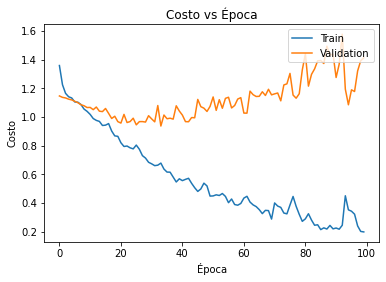

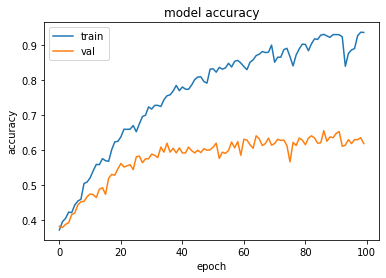

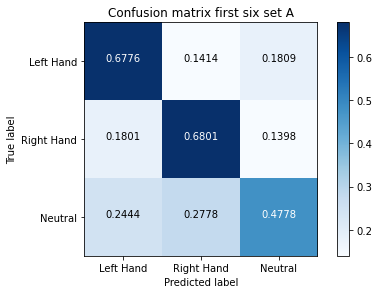

In [34]:
testers(1e-3,model_v2,epochs=100,batch_size=128)

## GridSearchCV

In [15]:
def LSTM_model_cv(n_steps=200,n_features=21,neurons=100,dense_activation='relu',dropout_rate=0.2,batch_normalization=True,lr=1e-3):
    model = Sequential()
    model.add(Input(shape=(n_steps,n_features)))
    model.add(LSTM(neurons,activation='tanh'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons,activation=dense_activation))
    if batch_normalization:
        model.add(BatchNormalization()) 
    model.add(Dense(3,activation='softmax',kernel_regularizer=keras.regularizers.l2(l=0.01)))
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy',optimizer=opt,
             metrics=['accuracy'])
    return model

In [12]:
# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

In [13]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

### Epoch and batch size

In [17]:
model = KerasClassifier(model=LSTM_model_cv,verbose=1)
#Define parameter grid
batch_size= [10,20,40,60,80,100]
epochs= [10,50,100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_result = grid.fit(X_train[:1500], y_train[:1500])

Epoch 1/10
75/75 [==============================] - 2s 10ms/step - loss: 1.4092 - accuracy: 0.3653
Epoch 2/10
75/75 [==============================] - 1s 10ms/step - loss: 1.2042 - accuracy: 0.4147
Epoch 3/10
75/75 [==============================] - 1s 11ms/step - loss: 1.1534 - accuracy: 0.4160
Epoch 4/10
75/75 [==============================] - 1s 11ms/step - loss: 1.1118 - accuracy: 0.4680
Epoch 5/10
75/75 [==============================] - 1s 10ms/step - loss: 1.0890 - accuracy: 0.4907
Epoch 6/10
75/75 [==============================] - 1s 11ms/step - loss: 1.0551 - accuracy: 0.5080
Epoch 7/10
75/75 [==============================] - 1s 10ms/step - loss: 0.9891 - accuracy: 0.5360
Epoch 8/10
75/75 [==============================] - 1s 11ms/step - loss: 0.9727 - accuracy: 0.5520
Epoch 9/10
75/75 [==============================] - 1s 10ms/step - loss: 0.9456 - accuracy: 0.5893
Epoch 10/10
75/75 [==============================] - 0s 4ms/step
Epoch 1/10
75/75 [==========================

75/75 [==============================] - 1s 11ms/step - loss: 0.9423 - accuracy: 0.5640
Epoch 12/50
75/75 [==============================] - 1s 10ms/step - loss: 0.8976 - accuracy: 0.5893
Epoch 13/50
75/75 [==============================] - 1s 11ms/step - loss: 0.8795 - accuracy: 0.6120
Epoch 14/50
75/75 [==============================] - 1s 10ms/step - loss: 0.8480 - accuracy: 0.6427
Epoch 15/50
75/75 [==============================] - 1s 11ms/step - loss: 0.8594 - accuracy: 0.6333
Epoch 16/50
75/75 [==============================] - 1s 11ms/step - loss: 0.8137 - accuracy: 0.6507
Epoch 17/50
75/75 [==============================] - 1s 10ms/step - loss: 0.8259 - accuracy: 0.6480
Epoch 18/50
75/75 [==============================] - 1s 11ms/step - loss: 0.7785 - accuracy: 0.6507
Epoch 19/50
75/75 [==============================] - 1s 10ms/step - loss: 0.7906 - accuracy: 0.6480
Epoch 20/50
75/75 [==============================] - 1s 11ms/step - loss: 0.7545 - accuracy: 0.6960
Epoch 21/50


75/75 [==============================] - 1s 10ms/step - loss: 0.3173 - accuracy: 0.8893
Epoch 43/100
75/75 [==============================] - 1s 11ms/step - loss: 0.4196 - accuracy: 0.8600
Epoch 44/100
75/75 [==============================] - 1s 11ms/step - loss: 0.2350 - accuracy: 0.9347
Epoch 45/100
75/75 [==============================] - 1s 10ms/step - loss: 0.1972 - accuracy: 0.9360
Epoch 46/100
75/75 [==============================] - 1s 10ms/step - loss: 0.1394 - accuracy: 0.9680
Epoch 47/100
75/75 [==============================] - 1s 10ms/step - loss: 0.2082 - accuracy: 0.9373
Epoch 48/100
75/75 [==============================] - 1s 11ms/step - loss: 0.1777 - accuracy: 0.9520
Epoch 49/100
75/75 [==============================] - 1s 11ms/step - loss: 0.2148 - accuracy: 0.9360
Epoch 50/100
75/75 [==============================] - 1s 11ms/step - loss: 0.1973 - accuracy: 0.9467
Epoch 51/100
75/75 [==============================] - 1s 11ms/step - loss: 0.1744 - accuracy: 0.9427
Epo

75/75 [==============================] - 1s 10ms/step - loss: 0.7410 - accuracy: 0.6867
Epoch 23/100
75/75 [==============================] - 1s 11ms/step - loss: 0.7211 - accuracy: 0.6960
Epoch 24/100
75/75 [==============================] - 1s 11ms/step - loss: 0.6877 - accuracy: 0.7293
Epoch 25/100
75/75 [==============================] - 1s 11ms/step - loss: 0.6593 - accuracy: 0.7467
Epoch 26/100
75/75 [==============================] - 1s 11ms/step - loss: 0.6076 - accuracy: 0.7467
Epoch 27/100
75/75 [==============================] - 1s 10ms/step - loss: 0.6417 - accuracy: 0.7533
Epoch 28/100
75/75 [==============================] - 1s 11ms/step - loss: 0.5900 - accuracy: 0.7747
Epoch 29/100
75/75 [==============================] - 1s 11ms/step - loss: 0.5924 - accuracy: 0.7640
Epoch 30/100
75/75 [==============================] - 1s 11ms/step - loss: 0.5435 - accuracy: 0.7987
Epoch 31/100
75/75 [==============================] - 1s 11ms/step - loss: 0.4983 - accuracy: 0.8240
Epo

38/38 [==============================] - 0s 10ms/step - loss: 1.1958 - accuracy: 0.4200
Epoch 3/10
38/38 [==============================] - 0s 10ms/step - loss: 1.1042 - accuracy: 0.4920
Epoch 4/10
38/38 [==============================] - 0s 10ms/step - loss: 1.0674 - accuracy: 0.5133
Epoch 5/10
38/38 [==============================] - 0s 11ms/step - loss: 1.0307 - accuracy: 0.5293
Epoch 6/10
38/38 [==============================] - 0s 10ms/step - loss: 1.0103 - accuracy: 0.5560
Epoch 7/10
38/38 [==============================] - 0s 11ms/step - loss: 0.9846 - accuracy: 0.5440
Epoch 8/10
38/38 [==============================] - 0s 11ms/step - loss: 0.9570 - accuracy: 0.5840
Epoch 9/10
38/38 [==============================] - 0s 10ms/step - loss: 0.9378 - accuracy: 0.5853
Epoch 10/10
38/38 [==============================] - 0s 4ms/step
Epoch 1/10
38/38 [==============================] - 1s 10ms/step - loss: 1.3717 - accuracy: 0.3533
Epoch 2/10
38/38 [==============================] - 0s 

38/38 [==============================] - 0s 11ms/step - loss: 0.8823 - accuracy: 0.6133
Epoch 13/50
38/38 [==============================] - 0s 10ms/step - loss: 0.8494 - accuracy: 0.6440
Epoch 14/50
38/38 [==============================] - 0s 11ms/step - loss: 0.8450 - accuracy: 0.6520
Epoch 15/50
38/38 [==============================] - 0s 10ms/step - loss: 0.7950 - accuracy: 0.6600
Epoch 16/50
38/38 [==============================] - 0s 10ms/step - loss: 0.7726 - accuracy: 0.6680
Epoch 17/50
38/38 [==============================] - 0s 10ms/step - loss: 0.7586 - accuracy: 0.6800
Epoch 18/50
38/38 [==============================] - 0s 10ms/step - loss: 0.7238 - accuracy: 0.7093
Epoch 19/50
38/38 [==============================] - 0s 11ms/step - loss: 0.6960 - accuracy: 0.7400
Epoch 20/50
38/38 [==============================] - 0s 10ms/step - loss: 0.7059 - accuracy: 0.7067
Epoch 21/50
38/38 [==============================] - 0s 10ms/step - loss: 0.6783 - accuracy: 0.7480
Epoch 22/50


38/38 [==============================] - 0s 10ms/step - loss: 0.2199 - accuracy: 0.9427
Epoch 44/100
38/38 [==============================] - 0s 10ms/step - loss: 0.1954 - accuracy: 0.9507
Epoch 45/100
38/38 [==============================] - 0s 11ms/step - loss: 0.1910 - accuracy: 0.9507
Epoch 46/100
38/38 [==============================] - 0s 11ms/step - loss: 0.2817 - accuracy: 0.9200
Epoch 47/100
38/38 [==============================] - 0s 10ms/step - loss: 0.1964 - accuracy: 0.9560
Epoch 48/100
38/38 [==============================] - 0s 10ms/step - loss: 0.1606 - accuracy: 0.9653
Epoch 49/100
38/38 [==============================] - 0s 11ms/step - loss: 0.1868 - accuracy: 0.9560
Epoch 50/100
38/38 [==============================] - 0s 11ms/step - loss: 0.1889 - accuracy: 0.9480
Epoch 51/100
38/38 [==============================] - 0s 11ms/step - loss: 0.1156 - accuracy: 0.9827
Epoch 52/100
38/38 [==============================] - 0s 11ms/step - loss: 0.1142 - accuracy: 0.9787
Epo

38/38 [==============================] - 0s 10ms/step - loss: 0.6399 - accuracy: 0.7547
Epoch 24/100
38/38 [==============================] - 0s 11ms/step - loss: 0.5863 - accuracy: 0.7907
Epoch 25/100
38/38 [==============================] - 0s 11ms/step - loss: 0.5358 - accuracy: 0.7947
Epoch 26/100
38/38 [==============================] - 0s 12ms/step - loss: 0.5867 - accuracy: 0.7707
Epoch 27/100
38/38 [==============================] - 0s 11ms/step - loss: 0.5450 - accuracy: 0.8067
Epoch 28/100
38/38 [==============================] - 0s 11ms/step - loss: 0.4531 - accuracy: 0.8493
Epoch 29/100
38/38 [==============================] - 0s 11ms/step - loss: 0.4284 - accuracy: 0.8760
Epoch 30/100
38/38 [==============================] - 0s 11ms/step - loss: 0.4404 - accuracy: 0.8400
Epoch 31/100
38/38 [==============================] - 0s 11ms/step - loss: 0.4172 - accuracy: 0.8520
Epoch 32/100
38/38 [==============================] - 0s 11ms/step - loss: 0.4058 - accuracy: 0.8693
Epo

19/19 [==============================] - 0s 11ms/step - loss: 1.1212 - accuracy: 0.4667
Epoch 4/10
19/19 [==============================] - 0s 12ms/step - loss: 1.0832 - accuracy: 0.4853
Epoch 5/10
19/19 [==============================] - 0s 10ms/step - loss: 1.0185 - accuracy: 0.5333
Epoch 6/10
19/19 [==============================] - 0s 10ms/step - loss: 1.0184 - accuracy: 0.5547
Epoch 7/10
19/19 [==============================] - 0s 11ms/step - loss: 0.9825 - accuracy: 0.5453
Epoch 8/10
19/19 [==============================] - 0s 10ms/step - loss: 0.9419 - accuracy: 0.5867
Epoch 9/10
19/19 [==============================] - 0s 11ms/step - loss: 0.8875 - accuracy: 0.6307
Epoch 10/10
19/19 [==============================] - 0s 4ms/step
Epoch 1/10
19/19 [==============================] - 1s 11ms/step - loss: 1.3826 - accuracy: 0.3760
Epoch 2/10
19/19 [==============================] - 0s 12ms/step - loss: 1.1445 - accuracy: 0.4653
Epoch 3/10
19/19 [==============================] - 0s 

19/19 [==============================] - 0s 10ms/step - loss: 0.8232 - accuracy: 0.6573
Epoch 14/50
19/19 [==============================] - 0s 11ms/step - loss: 0.8100 - accuracy: 0.6640
Epoch 15/50
19/19 [==============================] - 0s 11ms/step - loss: 0.7810 - accuracy: 0.6853
Epoch 16/50
19/19 [==============================] - 0s 10ms/step - loss: 0.7630 - accuracy: 0.6867
Epoch 17/50
19/19 [==============================] - 0s 11ms/step - loss: 0.7585 - accuracy: 0.6880
Epoch 18/50
19/19 [==============================] - 0s 11ms/step - loss: 0.7293 - accuracy: 0.7187
Epoch 19/50
19/19 [==============================] - 0s 10ms/step - loss: 0.7222 - accuracy: 0.7093
Epoch 20/50
19/19 [==============================] - 0s 10ms/step - loss: 0.6806 - accuracy: 0.7413
Epoch 21/50
19/19 [==============================] - 0s 10ms/step - loss: 0.6612 - accuracy: 0.7467
Epoch 22/50
19/19 [==============================] - 0s 10ms/step - loss: 0.6206 - accuracy: 0.7600
Epoch 23/50


19/19 [==============================] - 0s 10ms/step - loss: 0.1489 - accuracy: 0.9707
Epoch 45/100
19/19 [==============================] - 0s 11ms/step - loss: 0.1672 - accuracy: 0.9693
Epoch 46/100
19/19 [==============================] - 0s 11ms/step - loss: 0.1659 - accuracy: 0.9533
Epoch 47/100
19/19 [==============================] - 0s 11ms/step - loss: 0.1725 - accuracy: 0.9560
Epoch 48/100
19/19 [==============================] - 0s 10ms/step - loss: 0.2422 - accuracy: 0.9320
Epoch 49/100
19/19 [==============================] - 0s 11ms/step - loss: 0.2900 - accuracy: 0.9240
Epoch 50/100
19/19 [==============================] - 0s 11ms/step - loss: 0.1721 - accuracy: 0.9627
Epoch 51/100
19/19 [==============================] - 0s 11ms/step - loss: 0.1260 - accuracy: 0.9787
Epoch 52/100
19/19 [==============================] - 0s 11ms/step - loss: 0.1013 - accuracy: 0.9827
Epoch 53/100
19/19 [==============================] - 0s 10ms/step - loss: 0.1006 - accuracy: 0.9853
Epo

19/19 [==============================] - 0s 10ms/step - loss: 0.5473 - accuracy: 0.7973
Epoch 25/100
19/19 [==============================] - 0s 10ms/step - loss: 0.5460 - accuracy: 0.8013
Epoch 26/100
19/19 [==============================] - 0s 10ms/step - loss: 0.5279 - accuracy: 0.8053
Epoch 27/100
19/19 [==============================] - 0s 10ms/step - loss: 0.5777 - accuracy: 0.7813
Epoch 28/100
19/19 [==============================] - 0s 10ms/step - loss: 0.4992 - accuracy: 0.8253
Epoch 29/100
19/19 [==============================] - 0s 10ms/step - loss: 0.5145 - accuracy: 0.8200
Epoch 30/100
19/19 [==============================] - 0s 10ms/step - loss: 0.4534 - accuracy: 0.8587
Epoch 31/100
19/19 [==============================] - 0s 10ms/step - loss: 0.4536 - accuracy: 0.8253
Epoch 32/100
19/19 [==============================] - 0s 10ms/step - loss: 0.4023 - accuracy: 0.8680
Epoch 33/100
19/19 [==============================] - 0s 11ms/step - loss: 0.3917 - accuracy: 0.8747
Epo

13/13 [==============================] - 0s 11ms/step - loss: 1.0857 - accuracy: 0.4747
Epoch 5/10
13/13 [==============================] - 0s 12ms/step - loss: 1.0502 - accuracy: 0.5133
Epoch 6/10
13/13 [==============================] - 0s 12ms/step - loss: 1.0130 - accuracy: 0.5373
Epoch 7/10
13/13 [==============================] - 0s 12ms/step - loss: 0.9563 - accuracy: 0.5680
Epoch 8/10
13/13 [==============================] - 0s 13ms/step - loss: 0.9660 - accuracy: 0.5640
Epoch 9/10
13/13 [==============================] - 0s 13ms/step - loss: 0.9480 - accuracy: 0.5667
Epoch 10/10
13/13 [==============================] - 0s 5ms/step
Epoch 1/10
13/13 [==============================] - 1s 13ms/step - loss: 1.4161 - accuracy: 0.3520
Epoch 2/10
13/13 [==============================] - 0s 11ms/step - loss: 1.1876 - accuracy: 0.4160
Epoch 3/10
13/13 [==============================] - 0s 12ms/step - loss: 1.0968 - accuracy: 0.4707
Epoch 4/10
13/13 [==============================] - 0s 

13/13 [==============================] - 0s 12ms/step - loss: 0.8331 - accuracy: 0.6467
Epoch 15/50
13/13 [==============================] - 0s 12ms/step - loss: 0.8388 - accuracy: 0.6427
Epoch 16/50
13/13 [==============================] - 0s 12ms/step - loss: 0.8030 - accuracy: 0.6613
Epoch 17/50
13/13 [==============================] - 0s 12ms/step - loss: 0.7695 - accuracy: 0.6773
Epoch 18/50
13/13 [==============================] - 0s 12ms/step - loss: 0.7476 - accuracy: 0.7000
Epoch 19/50
13/13 [==============================] - 0s 12ms/step - loss: 0.7587 - accuracy: 0.6973
Epoch 20/50
13/13 [==============================] - 0s 12ms/step - loss: 0.7329 - accuracy: 0.6933
Epoch 21/50
13/13 [==============================] - 0s 12ms/step - loss: 0.7202 - accuracy: 0.7040
Epoch 22/50
13/13 [==============================] - 0s 13ms/step - loss: 0.6749 - accuracy: 0.7253
Epoch 23/50
13/13 [==============================] - 0s 12ms/step - loss: 0.6315 - accuracy: 0.7547
Epoch 24/50


13/13 [==============================] - 0s 12ms/step - loss: 0.1473 - accuracy: 0.9760
Epoch 46/100
13/13 [==============================] - 0s 12ms/step - loss: 0.1528 - accuracy: 0.9693
Epoch 47/100
13/13 [==============================] - 0s 13ms/step - loss: 0.2177 - accuracy: 0.9547
Epoch 48/100
13/13 [==============================] - 0s 12ms/step - loss: 0.2449 - accuracy: 0.9293
Epoch 49/100
13/13 [==============================] - 0s 13ms/step - loss: 0.2327 - accuracy: 0.9360
Epoch 50/100
13/13 [==============================] - 0s 12ms/step - loss: 0.2329 - accuracy: 0.9413
Epoch 51/100
13/13 [==============================] - 0s 13ms/step - loss: 0.1927 - accuracy: 0.9520
Epoch 52/100
13/13 [==============================] - 0s 12ms/step - loss: 0.1707 - accuracy: 0.9640
Epoch 53/100
13/13 [==============================] - 0s 12ms/step - loss: 0.1703 - accuracy: 0.9600
Epoch 54/100
13/13 [==============================] - 0s 12ms/step - loss: 0.1482 - accuracy: 0.9707
Epo

13/13 [==============================] - 0s 12ms/step - loss: 0.5550 - accuracy: 0.7960
Epoch 26/100
13/13 [==============================] - 0s 12ms/step - loss: 0.5299 - accuracy: 0.8120
Epoch 27/100
13/13 [==============================] - 0s 13ms/step - loss: 0.4791 - accuracy: 0.8213
Epoch 28/100
13/13 [==============================] - 0s 12ms/step - loss: 0.4854 - accuracy: 0.8227
Epoch 29/100
13/13 [==============================] - 0s 12ms/step - loss: 0.4735 - accuracy: 0.8147
Epoch 30/100
13/13 [==============================] - 0s 12ms/step - loss: 0.4807 - accuracy: 0.8293
Epoch 31/100
13/13 [==============================] - 0s 11ms/step - loss: 0.4542 - accuracy: 0.8480
Epoch 32/100
13/13 [==============================] - 0s 12ms/step - loss: 0.3807 - accuracy: 0.8827
Epoch 33/100
13/13 [==============================] - 0s 12ms/step - loss: 0.3905 - accuracy: 0.8707
Epoch 34/100
13/13 [==============================] - 0s 12ms/step - loss: 0.4357 - accuracy: 0.8507
Epo

10/10 [==============================] - 0s 12ms/step - loss: 1.0461 - accuracy: 0.5280
Epoch 6/10
10/10 [==============================] - 0s 12ms/step - loss: 1.0218 - accuracy: 0.5280
Epoch 7/10
10/10 [==============================] - 0s 12ms/step - loss: 1.0000 - accuracy: 0.5453
Epoch 8/10
10/10 [==============================] - 0s 12ms/step - loss: 0.9741 - accuracy: 0.5680
Epoch 9/10
10/10 [==============================] - 0s 12ms/step - loss: 0.9153 - accuracy: 0.5733
Epoch 10/10
10/10 [==============================] - 0s 5ms/step
Epoch 1/10
10/10 [==============================] - 1s 12ms/step - loss: 1.3955 - accuracy: 0.3360
Epoch 2/10
10/10 [==============================] - 0s 12ms/step - loss: 1.1995 - accuracy: 0.4107
Epoch 3/10
10/10 [==============================] - 0s 12ms/step - loss: 1.1253 - accuracy: 0.4587
Epoch 4/10
10/10 [==============================] - 0s 12ms/step - loss: 1.0576 - accuracy: 0.4733
Epoch 5/10
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 12ms/step - loss: 0.8134 - accuracy: 0.6627
Epoch 16/50
10/10 [==============================] - 0s 12ms/step - loss: 0.8161 - accuracy: 0.6453
Epoch 17/50
10/10 [==============================] - 0s 12ms/step - loss: 0.7840 - accuracy: 0.6800
Epoch 18/50
10/10 [==============================] - 0s 12ms/step - loss: 0.7768 - accuracy: 0.6733
Epoch 19/50
10/10 [==============================] - 0s 12ms/step - loss: 0.7869 - accuracy: 0.6920
Epoch 20/50
10/10 [==============================] - 0s 12ms/step - loss: 0.7332 - accuracy: 0.7067
Epoch 21/50
10/10 [==============================] - 0s 13ms/step - loss: 0.7221 - accuracy: 0.7160
Epoch 22/50
10/10 [==============================] - 0s 12ms/step - loss: 0.6770 - accuracy: 0.7347
Epoch 23/50
10/10 [==============================] - 0s 12ms/step - loss: 0.6690 - accuracy: 0.7213
Epoch 24/50
10/10 [==============================] - 0s 12ms/step - loss: 0.6473 - accuracy: 0.7693
Epoch 25/50


10/10 [==============================] - 0s 12ms/step - loss: 0.1644 - accuracy: 0.9627
Epoch 47/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1561 - accuracy: 0.9707
Epoch 48/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1496 - accuracy: 0.9747
Epoch 49/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1399 - accuracy: 0.9707
Epoch 50/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1328 - accuracy: 0.9800
Epoch 51/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1370 - accuracy: 0.9827
Epoch 52/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1738 - accuracy: 0.9573
Epoch 53/100
10/10 [==============================] - 0s 12ms/step - loss: 0.2222 - accuracy: 0.9387
Epoch 54/100
10/10 [==============================] - 0s 12ms/step - loss: 0.2071 - accuracy: 0.9493
Epoch 55/100
10/10 [==============================] - 0s 12ms/step - loss: 0.2213 - accuracy: 0.9453
Epo

10/10 [==============================] - 0s 12ms/step - loss: 0.5913 - accuracy: 0.7640
Epoch 27/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5870 - accuracy: 0.7880
Epoch 28/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5555 - accuracy: 0.8053
Epoch 29/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5003 - accuracy: 0.8213
Epoch 30/100
10/10 [==============================] - 0s 13ms/step - loss: 0.4929 - accuracy: 0.8333
Epoch 31/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5894 - accuracy: 0.7840
Epoch 32/100
10/10 [==============================] - 0s 12ms/step - loss: 0.5373 - accuracy: 0.8080
Epoch 33/100
10/10 [==============================] - 0s 13ms/step - loss: 0.4835 - accuracy: 0.8373
Epoch 34/100
10/10 [==============================] - 0s 13ms/step - loss: 0.4451 - accuracy: 0.8533
Epoch 35/100
10/10 [==============================] - 0s 13ms/step - loss: 0.4081 - accuracy: 0.8707
Epo

Epoch 7/10
8/8 [==============================] - 0s 12ms/step - loss: 0.9990 - accuracy: 0.5400
Epoch 8/10
8/8 [==============================] - 0s 12ms/step - loss: 0.9823 - accuracy: 0.5547
Epoch 9/10
8/8 [==============================] - 0s 12ms/step - loss: 0.9519 - accuracy: 0.5867
Epoch 10/10
8/8 [==============================] - 0s 5ms/step
Epoch 1/10
8/8 [==============================] - 1s 12ms/step - loss: 1.3770 - accuracy: 0.3493
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 1.2069 - accuracy: 0.4253
Epoch 3/10
8/8 [==============================] - 0s 12ms/step - loss: 1.1445 - accuracy: 0.4507
Epoch 4/10
8/8 [==============================] - 0s 13ms/step - loss: 1.0672 - accuracy: 0.4907
Epoch 5/10
8/8 [==============================] - 0s 12ms/step - loss: 1.0495 - accuracy: 0.5107
Epoch 6/10
8/8 [==============================] - 0s 12ms/step - loss: 1.0110 - accuracy: 0.5347
Epoch 7/10
8/8 [==============================] - 0s 12ms/step -

8/8 [==============================] - 0s 12ms/step - loss: 0.7683 - accuracy: 0.6907
Epoch 20/50
8/8 [==============================] - 0s 12ms/step - loss: 0.7450 - accuracy: 0.6787
Epoch 21/50
8/8 [==============================] - 0s 12ms/step - loss: 0.7262 - accuracy: 0.6920
Epoch 22/50
8/8 [==============================] - 0s 12ms/step - loss: 0.6877 - accuracy: 0.7280
Epoch 23/50
8/8 [==============================] - 0s 12ms/step - loss: 0.6635 - accuracy: 0.7347
Epoch 24/50
8/8 [==============================] - 0s 12ms/step - loss: 0.6639 - accuracy: 0.7427
Epoch 25/50
8/8 [==============================] - 0s 12ms/step - loss: 0.6488 - accuracy: 0.7547
Epoch 26/50
8/8 [==============================] - 0s 13ms/step - loss: 0.6336 - accuracy: 0.7453
Epoch 27/50
8/8 [==============================] - 0s 12ms/step - loss: 0.6096 - accuracy: 0.7613
Epoch 28/50
8/8 [==============================] - 0s 11ms/step - loss: 0.5986 - accuracy: 0.7853
Epoch 29/50
8/8 [===============

8/8 [==============================] - 0s 12ms/step - loss: 0.1151 - accuracy: 0.9867
Epoch 52/100
8/8 [==============================] - 0s 12ms/step - loss: 0.1152 - accuracy: 0.9893
Epoch 53/100
8/8 [==============================] - 0s 12ms/step - loss: 0.1286 - accuracy: 0.9760
Epoch 54/100
8/8 [==============================] - 0s 12ms/step - loss: 0.1419 - accuracy: 0.9773
Epoch 55/100
8/8 [==============================] - 0s 12ms/step - loss: 0.1656 - accuracy: 0.9680
Epoch 56/100
8/8 [==============================] - 0s 12ms/step - loss: 0.1514 - accuracy: 0.9680
Epoch 57/100
8/8 [==============================] - 0s 13ms/step - loss: 0.1534 - accuracy: 0.9693
Epoch 58/100
8/8 [==============================] - 0s 12ms/step - loss: 0.1801 - accuracy: 0.9640
Epoch 59/100
8/8 [==============================] - 0s 12ms/step - loss: 0.1778 - accuracy: 0.9627
Epoch 60/100
8/8 [==============================] - 0s 12ms/step - loss: 0.1581 - accuracy: 0.9667
Epoch 61/100
8/8 [=====

8/8 [==============================] - 0s 12ms/step - loss: 0.5112 - accuracy: 0.8133
Epoch 34/100
8/8 [==============================] - 0s 12ms/step - loss: 0.5083 - accuracy: 0.8040
Epoch 35/100
8/8 [==============================] - 0s 12ms/step - loss: 0.4417 - accuracy: 0.8573
Epoch 36/100
8/8 [==============================] - 0s 12ms/step - loss: 0.4366 - accuracy: 0.8507
Epoch 37/100
8/8 [==============================] - 0s 12ms/step - loss: 0.4154 - accuracy: 0.8653
Epoch 38/100
8/8 [==============================] - 0s 12ms/step - loss: 0.4150 - accuracy: 0.8533
Epoch 39/100
8/8 [==============================] - 0s 12ms/step - loss: 0.3655 - accuracy: 0.8853
Epoch 40/100
8/8 [==============================] - 0s 12ms/step - loss: 0.3460 - accuracy: 0.8947
Epoch 41/100
8/8 [==============================] - 0s 12ms/step - loss: 0.3506 - accuracy: 0.9027
Epoch 42/100
8/8 [==============================] - 0s 12ms/step - loss: 0.3745 - accuracy: 0.8800
Epoch 43/100
8/8 [=====

15/15 [==============================] - 0s 12ms/step - loss: 0.8366 - accuracy: 0.6513
Epoch 16/100
15/15 [==============================] - 0s 13ms/step - loss: 0.8169 - accuracy: 0.6627
Epoch 17/100
15/15 [==============================] - 0s 12ms/step - loss: 0.8059 - accuracy: 0.6767
Epoch 18/100
15/15 [==============================] - 0s 13ms/step - loss: 0.7771 - accuracy: 0.6747
Epoch 19/100
15/15 [==============================] - 0s 12ms/step - loss: 0.7415 - accuracy: 0.7000
Epoch 20/100
15/15 [==============================] - 0s 12ms/step - loss: 0.7105 - accuracy: 0.7093
Epoch 21/100
15/15 [==============================] - 0s 12ms/step - loss: 0.6899 - accuracy: 0.7253
Epoch 22/100
15/15 [==============================] - 0s 12ms/step - loss: 0.6845 - accuracy: 0.7353
Epoch 23/100
15/15 [==============================] - 0s 12ms/step - loss: 0.6513 - accuracy: 0.7547
Epoch 24/100
15/15 [==============================] - 0s 12ms/step - loss: 0.6577 - accuracy: 0.7367
Epo

15/15 [==============================] - 0s 12ms/step - loss: 0.0850 - accuracy: 0.9820
Epoch 97/100
15/15 [==============================] - 0s 11ms/step - loss: 0.0939 - accuracy: 0.9840
Epoch 98/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0942 - accuracy: 0.9807
Epoch 99/100
15/15 [==============================] - 0s 13ms/step - loss: 0.1087 - accuracy: 0.9773
Epoch 100/100
15/15 [==============================] - 0s 12ms/step - loss: 0.1061 - accuracy: 0.9740


In [18]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.508000 using {'batch_size': 100, 'epochs': 100}
0.433333 (0.006667) with: {'batch_size': 10, 'epochs': 10}
0.449333 (0.008000) with: {'batch_size': 10, 'epochs': 50}
0.454667 (0.014667) with: {'batch_size': 10, 'epochs': 100}
0.399333 (0.008667) with: {'batch_size': 20, 'epochs': 10}
0.454000 (0.012667) with: {'batch_size': 20, 'epochs': 50}
0.435333 (0.006000) with: {'batch_size': 20, 'epochs': 100}
0.428000 (0.001333) with: {'batch_size': 40, 'epochs': 10}
0.461333 (0.005333) with: {'batch_size': 40, 'epochs': 50}
0.494667 (0.013333) with: {'batch_size': 40, 'epochs': 100}
0.400667 (0.006000) with: {'batch_size': 60, 'epochs': 10}
0.502000 (0.023333) with: {'batch_size': 60, 'epochs': 50}
0.502667 (0.024000) with: {'batch_size': 60, 'epochs': 100}
0.398667 (0.005333) with: {'batch_size': 80, 'epochs': 10}
0.498000 (0.016667) with: {'batch_size': 80, 'epochs': 50}
0.504667 (0.007333) with: {'batch_size': 80, 'epochs': 100}
0.393333 (0.000000) with: {'batch_size': 100, 'epochs'

### Training Optimiazation Algorithm

In [27]:
def LSTM_model_cv(n_steps=200,n_features=21,neurons=100,dense_activation='hard_sigmoid',dropout_rate=0.5,batch_normalization=True,lr=1e-3):
    model = Sequential()
    model.add(Input(shape=(n_steps,n_features)))
    model.add(LSTM(neurons,activation='tanh'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons,activation=dense_activation))
    if batch_normalization:
        model.add(BatchNormalization()) 
    model.add(Dense(3,activation='softmax',kernel_regularizer=keras.regularizers.l2(l=0.01)))
    return model

In [28]:
# create model
model = KerasClassifier(model=LSTM_model_cv, loss="categorical_crossentropy", epochs=100, batch_size=100, verbose=1)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train[:1500], y_train[:1500])

Epoch 1/100
10/10 [==============================] - 1s 14ms/step - loss: 1.5301
Epoch 2/100
10/10 [==============================] - 0s 13ms/step - loss: 1.3542
Epoch 3/100
10/10 [==============================] - 0s 13ms/step - loss: 1.2846
Epoch 4/100
10/10 [==============================] - 0s 13ms/step - loss: 1.3304
Epoch 5/100
10/10 [==============================] - 0s 13ms/step - loss: 1.2789
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 1.2588
Epoch 7/100
10/10 [==============================] - 0s 13ms/step - loss: 1.2667
Epoch 8/100
10/10 [==============================] - 0s 12ms/step - loss: 1.2346
Epoch 9/100
10/10 [==============================] - 0s 12ms/step - loss: 1.2214
Epoch 10/100
10/10 [==============================] - 0s 12ms/step - loss: 1.2182
Epoch 11/100
10/10 [==============================] - 0s 13ms/step - loss: 1.2060
Epoch 12/100
10/10 [==============================] - 0s 14ms/step - loss: 1.1798
Epoch 13/100
10/10 [=====

5/5 [==============================] - 0s 6ms/step
Epoch 1/100
10/10 [==============================] - 1s 13ms/step - loss: 1.4829
Epoch 2/100
10/10 [==============================] - 0s 13ms/step - loss: 1.3776
Epoch 3/100
10/10 [==============================] - 0s 13ms/step - loss: 1.3327
Epoch 4/100
10/10 [==============================] - 0s 13ms/step - loss: 1.3095
Epoch 5/100
10/10 [==============================] - 0s 12ms/step - loss: 1.2571
Epoch 6/100
10/10 [==============================] - 0s 12ms/step - loss: 1.2584
Epoch 7/100
10/10 [==============================] - 0s 13ms/step - loss: 1.2253
Epoch 8/100
10/10 [==============================] - 0s 13ms/step - loss: 1.2073
Epoch 9/100
10/10 [==============================] - 0s 13ms/step - loss: 1.2106
Epoch 10/100
10/10 [==============================] - 0s 13ms/step - loss: 1.2151
Epoch 11/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1903
Epoch 12/100
10/10 [==============================] - 0s

5/5 [==============================] - 0s 6ms/step
Epoch 1/100
10/10 [==============================] - 1s 14ms/step - loss: 1.3797
Epoch 2/100
10/10 [==============================] - 0s 13ms/step - loss: 1.3371
Epoch 3/100
10/10 [==============================] - 0s 12ms/step - loss: 1.2747
Epoch 4/100
10/10 [==============================] - 0s 12ms/step - loss: 1.2712
Epoch 5/100
10/10 [==============================] - 0s 13ms/step - loss: 1.2479
Epoch 6/100
10/10 [==============================] - 0s 12ms/step - loss: 1.2294
Epoch 7/100
10/10 [==============================] - 0s 13ms/step - loss: 1.2053
Epoch 8/100
10/10 [==============================] - 0s 13ms/step - loss: 1.2071
Epoch 9/100
10/10 [==============================] - 0s 13ms/step - loss: 1.2091
Epoch 10/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1767
Epoch 11/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1582
Epoch 12/100
10/10 [==============================] - 0s

10/10 [==============================] - 0s 12ms/step - loss: 1.0211
Epoch 100/100
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
10/10 [==============================] - 2s 14ms/step - loss: 1.3521
Epoch 2/100
10/10 [==============================] - 0s 14ms/step - loss: 1.1996
Epoch 3/100
10/10 [==============================] - 0s 14ms/step - loss: 1.1742
Epoch 4/100
10/10 [==============================] - 0s 14ms/step - loss: 1.1270
Epoch 5/100
10/10 [==============================] - 0s 14ms/step - loss: 1.1110
Epoch 6/100
10/10 [==============================] - 0s 14ms/step - loss: 1.1096
Epoch 7/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0874
Epoch 8/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0768
Epoch 9/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0375
Epoch 10/100
10/10 [==============================] - 0s 16ms/step - loss: 1.0154
Epoch 11/100
10/10 [==============================] - 0

10/10 [==============================] - 0s 12ms/step - loss: 0.1728
Epoch 99/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0940
Epoch 100/100
5/5 [==============================] - 0s 8ms/step
Epoch 1/100
10/10 [==============================] - 1s 14ms/step - loss: 1.3454
Epoch 2/100
10/10 [==============================] - 0s 13ms/step - loss: 1.2012
Epoch 3/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1608
Epoch 4/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1616
Epoch 5/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1094
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1322
Epoch 7/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1023
Epoch 8/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0669
Epoch 9/100
10/10 [==============================] - 0s 15ms/step - loss: 1.0682
Epoch 10/100
10/10 [==============================] - 0

10/10 [==============================] - 0s 13ms/step - loss: 0.1502
Epoch 98/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1133
Epoch 99/100
10/10 [==============================] - 0s 12ms/step - loss: 0.2123
Epoch 100/100
5/5 [==============================] - 0s 5ms/step
Epoch 1/100
10/10 [==============================] - 1s 14ms/step - loss: 1.3329
Epoch 2/100
10/10 [==============================] - 0s 13ms/step - loss: 1.2124
Epoch 3/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1688
Epoch 4/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1469
Epoch 5/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1104
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1152
Epoch 7/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0845
Epoch 8/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0652
Epoch 9/100
10/10 [==============================] - 0

10/10 [==============================] - 0s 12ms/step - loss: 0.1055
Epoch 97/100
10/10 [==============================] - 0s 13ms/step - loss: 0.0950
Epoch 98/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1263
Epoch 99/100
10/10 [==============================] - 0s 15ms/step - loss: 0.0894
Epoch 100/100
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
10/10 [==============================] - 1s 15ms/step - loss: 1.5093
Epoch 2/100
10/10 [==============================] - 0s 15ms/step - loss: 1.4211
Epoch 3/100
10/10 [==============================] - 0s 14ms/step - loss: 1.4213
Epoch 4/100
10/10 [==============================] - 0s 15ms/step - loss: 1.3740
Epoch 5/100
10/10 [==============================] - 0s 14ms/step - loss: 1.3460
Epoch 6/100
10/10 [==============================] - 0s 14ms/step - loss: 1.2932
Epoch 7/100
10/10 [==============================] - 0s 15ms/step - loss: 1.3615
Epoch 8/100
10/10 [==============================] - 

10/10 [==============================] - 0s 12ms/step - loss: 1.1453
Epoch 96/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1262
Epoch 97/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1365
Epoch 98/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1461
Epoch 99/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1326
Epoch 100/100
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
10/10 [==============================] - 1s 12ms/step - loss: 1.5360
Epoch 2/100
10/10 [==============================] - 0s 12ms/step - loss: 1.4501
Epoch 3/100
10/10 [==============================] - 0s 12ms/step - loss: 1.3874
Epoch 4/100
10/10 [==============================] - 0s 12ms/step - loss: 1.3948
Epoch 5/100
10/10 [==============================] - 0s 12ms/step - loss: 1.3154
Epoch 6/100
10/10 [==============================] - 0s 12ms/step - loss: 1.3527
Epoch 7/100
10/10 [==============================] -

10/10 [==============================] - 0s 12ms/step - loss: 1.1547
Epoch 95/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1566
Epoch 96/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1662
Epoch 97/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1415
Epoch 98/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1505
Epoch 99/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1578
Epoch 100/100
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
10/10 [==============================] - 1s 12ms/step - loss: 1.3383
Epoch 2/100
10/10 [==============================] - 0s 12ms/step - loss: 1.3025
Epoch 3/100
10/10 [==============================] - 0s 12ms/step - loss: 1.3413
Epoch 4/100
10/10 [==============================] - 0s 12ms/step - loss: 1.3437
Epoch 5/100
10/10 [==============================] - 0s 12ms/step - loss: 1.3066
Epoch 6/100
10/10 [==============================] 

10/10 [==============================] - 0s 12ms/step - loss: 1.1298
Epoch 94/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1387
Epoch 95/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1404
Epoch 96/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1235
Epoch 97/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1434
Epoch 98/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1387
Epoch 99/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1132
Epoch 100/100
5/5 [==============================] - 0s 5ms/step
Epoch 1/100
10/10 [==============================] - 1s 12ms/step - loss: 1.5750
Epoch 2/100
10/10 [==============================] - 0s 12ms/step - loss: 1.5574
Epoch 3/100
10/10 [==============================] - 0s 13ms/step - loss: 1.5712
Epoch 4/100
10/10 [==============================] - 0s 12ms/step - loss: 1.5461
Epoch 5/100
10/10 [==============================]

10/10 [==============================] - 0s 12ms/step - loss: 1.4812
Epoch 93/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4872
Epoch 94/100
10/10 [==============================] - 0s 12ms/step - loss: 1.4551
Epoch 95/100
10/10 [==============================] - 0s 12ms/step - loss: 1.4402
Epoch 96/100
10/10 [==============================] - 0s 12ms/step - loss: 1.4790
Epoch 97/100
10/10 [==============================] - 0s 12ms/step - loss: 1.4844
Epoch 98/100
10/10 [==============================] - 0s 12ms/step - loss: 1.4417
Epoch 99/100
10/10 [==============================] - 0s 12ms/step - loss: 1.4512
Epoch 100/100
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
10/10 [==============================] - 1s 12ms/step - loss: 1.4774
Epoch 2/100
10/10 [==============================] - 0s 12ms/step - loss: 1.5262
Epoch 3/100
10/10 [==============================] - 0s 12ms/step - loss: 1.5110
Epoch 4/100
10/10 [==============================

10/10 [==============================] - 0s 13ms/step - loss: 1.4467
Epoch 92/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4280
Epoch 93/100
10/10 [==============================] - 0s 14ms/step - loss: 1.4519
Epoch 94/100
10/10 [==============================] - 0s 14ms/step - loss: 1.4583
Epoch 95/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4175
Epoch 96/100
10/10 [==============================] - 0s 14ms/step - loss: 1.4263
Epoch 97/100
10/10 [==============================] - 0s 15ms/step - loss: 1.4187
Epoch 98/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4097
Epoch 99/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4285
Epoch 100/100
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
10/10 [==============================] - 1s 12ms/step - loss: 1.5242
Epoch 2/100
10/10 [==============================] - 0s 12ms/step - loss: 1.5460
Epoch 3/100
10/10 [=============================

10/10 [==============================] - 0s 12ms/step - loss: 1.4189
Epoch 91/100
10/10 [==============================] - 0s 12ms/step - loss: 1.3809
Epoch 92/100
10/10 [==============================] - 0s 11ms/step - loss: 1.4478
Epoch 93/100
10/10 [==============================] - 0s 12ms/step - loss: 1.4246
Epoch 94/100
10/10 [==============================] - 0s 12ms/step - loss: 1.4701
Epoch 95/100
10/10 [==============================] - 0s 12ms/step - loss: 1.4065
Epoch 96/100
10/10 [==============================] - 0s 12ms/step - loss: 1.4766
Epoch 97/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4398
Epoch 98/100
10/10 [==============================] - 0s 12ms/step - loss: 1.4090
Epoch 99/100
10/10 [==============================] - 0s 12ms/step - loss: 1.3547
Epoch 100/100
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
10/10 [==============================] - 1s 13ms/step - loss: 1.3617
Epoch 2/100
10/10 [============================

10/10 [==============================] - 0s 16ms/step - loss: 0.1813
Epoch 90/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1376
Epoch 91/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1089
Epoch 92/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0922
Epoch 93/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0887
Epoch 94/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0810
Epoch 95/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0888
Epoch 96/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0848
Epoch 97/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0731
Epoch 98/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0792
Epoch 99/100
10/10 [==============================] - 0s 15ms/step - loss: 0.0751
Epoch 100/100
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
10/10 [===========================

10/10 [==============================] - 0s 12ms/step - loss: 0.2216
Epoch 89/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1716
Epoch 90/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1399
Epoch 91/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1252
Epoch 92/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1346
Epoch 93/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1865
Epoch 94/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1441
Epoch 95/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1257
Epoch 96/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1139
Epoch 97/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0929
Epoch 98/100
10/10 [==============================] - 0s 13ms/step - loss: 0.0958
Epoch 99/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1217
Epoch 100/100
5/5 [==========

10/10 [==============================] - 0s 12ms/step - loss: 0.2103
Epoch 88/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1838
Epoch 89/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1519
Epoch 90/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1335
Epoch 91/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1078
Epoch 92/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0898
Epoch 93/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0785
Epoch 94/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0766
Epoch 95/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0908
Epoch 96/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0857
Epoch 97/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1028
Epoch 98/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1883
Epoch 99/100
10/10 [=========

10/10 [==============================] - 0s 12ms/step - loss: 0.3556
Epoch 87/100
10/10 [==============================] - 0s 12ms/step - loss: 0.3489
Epoch 88/100
10/10 [==============================] - 0s 12ms/step - loss: 0.3415
Epoch 89/100
10/10 [==============================] - 0s 12ms/step - loss: 0.3168
Epoch 90/100
10/10 [==============================] - 0s 12ms/step - loss: 0.3151
Epoch 91/100
10/10 [==============================] - 0s 12ms/step - loss: 0.3064
Epoch 92/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2965
Epoch 93/100
10/10 [==============================] - 0s 12ms/step - loss: 0.2863
Epoch 94/100
10/10 [==============================] - 0s 12ms/step - loss: 0.2827
Epoch 95/100
10/10 [==============================] - 0s 12ms/step - loss: 0.2905
Epoch 96/100
10/10 [==============================] - 0s 12ms/step - loss: 0.2796
Epoch 97/100
10/10 [==============================] - 0s 12ms/step - loss: 0.2647
Epoch 98/100
10/10 [=========

10/10 [==============================] - 0s 12ms/step - loss: 0.3524
Epoch 86/100
10/10 [==============================] - 0s 12ms/step - loss: 0.3558
Epoch 87/100
10/10 [==============================] - 0s 12ms/step - loss: 0.3430
Epoch 88/100
10/10 [==============================] - 0s 12ms/step - loss: 0.3523
Epoch 89/100
10/10 [==============================] - 0s 12ms/step - loss: 0.3397
Epoch 90/100
10/10 [==============================] - 0s 12ms/step - loss: 0.3150
Epoch 91/100
10/10 [==============================] - 0s 12ms/step - loss: 0.3097
Epoch 92/100
10/10 [==============================] - 0s 12ms/step - loss: 0.3318
Epoch 93/100
10/10 [==============================] - 0s 12ms/step - loss: 0.3416
Epoch 94/100
10/10 [==============================] - 0s 12ms/step - loss: 0.3465
Epoch 95/100
10/10 [==============================] - 0s 12ms/step - loss: 0.3081
Epoch 96/100
10/10 [==============================] - 0s 13ms/step - loss: 0.3009
Epoch 97/100
10/10 [=========

10/10 [==============================] - 0s 12ms/step - loss: 0.3371
Epoch 85/100
10/10 [==============================] - 0s 11ms/step - loss: 0.3347
Epoch 86/100
10/10 [==============================] - 0s 15ms/step - loss: 0.3278
Epoch 87/100
10/10 [==============================] - 0s 16ms/step - loss: 0.3383
Epoch 88/100
10/10 [==============================] - 0s 13ms/step - loss: 0.3318
Epoch 89/100
10/10 [==============================] - 0s 12ms/step - loss: 0.3097
Epoch 90/100
10/10 [==============================] - 0s 11ms/step - loss: 0.2916
Epoch 91/100
10/10 [==============================] - 0s 12ms/step - loss: 0.2955
Epoch 92/100
10/10 [==============================] - 0s 12ms/step - loss: 0.2912
Epoch 93/100
10/10 [==============================] - 0s 12ms/step - loss: 0.2844
Epoch 94/100
10/10 [==============================] - 0s 12ms/step - loss: 0.2667
Epoch 95/100
10/10 [==============================] - 0s 12ms/step - loss: 0.2771
Epoch 96/100
10/10 [=========

10/10 [==============================] - 0s 16ms/step - loss: 0.2014
Epoch 84/100
10/10 [==============================] - 0s 15ms/step - loss: 0.1473
Epoch 85/100
10/10 [==============================] - 0s 15ms/step - loss: 0.1401
Epoch 86/100
10/10 [==============================] - 0s 15ms/step - loss: 0.2377
Epoch 87/100
10/10 [==============================] - 0s 16ms/step - loss: 0.1919
Epoch 88/100
10/10 [==============================] - 0s 15ms/step - loss: 0.1971
Epoch 89/100
10/10 [==============================] - 0s 16ms/step - loss: 0.5174
Epoch 90/100
10/10 [==============================] - 0s 15ms/step - loss: 0.4069
Epoch 91/100
10/10 [==============================] - 0s 15ms/step - loss: 0.2646
Epoch 92/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1847
Epoch 93/100
10/10 [==============================] - 0s 16ms/step - loss: 0.1427
Epoch 94/100
10/10 [==============================] - 0s 15ms/step - loss: 0.1006
Epoch 95/100
10/10 [=========

10/10 [==============================] - 0s 14ms/step - loss: 0.2211
Epoch 83/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1941
Epoch 84/100
10/10 [==============================] - 0s 15ms/step - loss: 0.1509
Epoch 85/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1135
Epoch 86/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1362
Epoch 87/100
10/10 [==============================] - 0s 15ms/step - loss: 0.0852
Epoch 88/100
10/10 [==============================] - 0s 15ms/step - loss: 0.0783
Epoch 89/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0753
Epoch 90/100
10/10 [==============================] - 0s 15ms/step - loss: 0.0774
Epoch 91/100
10/10 [==============================] - 0s 15ms/step - loss: 0.1765
Epoch 92/100
10/10 [==============================] - 0s 15ms/step - loss: 0.2005
Epoch 93/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1567
Epoch 94/100
10/10 [=========

10/10 [==============================] - 0s 14ms/step - loss: 0.2139
Epoch 82/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1608
Epoch 83/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1255
Epoch 84/100
10/10 [==============================] - 0s 15ms/step - loss: 0.1116
Epoch 85/100
10/10 [==============================] - 0s 15ms/step - loss: 0.0939
Epoch 86/100
10/10 [==============================] - 0s 13ms/step - loss: 0.0790
Epoch 87/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0812
Epoch 88/100
10/10 [==============================] - 0s 15ms/step - loss: 0.0759
Epoch 89/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1166
Epoch 90/100
10/10 [==============================] - 0s 14ms/step - loss: 0.2165
Epoch 91/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1248
Epoch 92/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1984
Epoch 93/100
10/10 [=========

15/15 [==============================] - 0s 12ms/step - loss: 0.3354
Epoch 81/100
15/15 [==============================] - 0s 12ms/step - loss: 0.2241
Epoch 82/100
15/15 [==============================] - 0s 12ms/step - loss: 0.1860
Epoch 83/100
15/15 [==============================] - 0s 12ms/step - loss: 0.1580
Epoch 84/100
15/15 [==============================] - 0s 12ms/step - loss: 0.1363
Epoch 85/100
15/15 [==============================] - 0s 11ms/step - loss: 0.1517
Epoch 86/100
15/15 [==============================] - 0s 12ms/step - loss: 0.1477
Epoch 87/100
15/15 [==============================] - 0s 12ms/step - loss: 0.1163
Epoch 88/100
15/15 [==============================] - 0s 12ms/step - loss: 0.2014
Epoch 89/100
15/15 [==============================] - 0s 12ms/step - loss: 0.1536
Epoch 90/100
15/15 [==============================] - 0s 12ms/step - loss: 0.1337
Epoch 91/100
15/15 [==============================] - 0s 12ms/step - loss: 0.1499
Epoch 92/100
15/15 [=========

In [29]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.549333 using {'optimizer': 'Adam'}
0.442000 (0.018833) with: {'optimizer': 'SGD'}
0.548667 (0.015521) with: {'optimizer': 'RMSprop'}
0.418000 (0.011431) with: {'optimizer': 'Adagrad'}
0.348000 (0.047525) with: {'optimizer': 'Adadelta'}
0.549333 (0.019619) with: {'optimizer': 'Adam'}
0.538000 (0.025456) with: {'optimizer': 'Adamax'}
0.540000 (0.037094) with: {'optimizer': 'Nadam'}


### Activation Function

In [19]:
def LSTM_model_cv(dense_activation,n_steps=200,n_features=21,neurons=100,dropout_rate=0.5,batch_normalization=True,lr=1e-3):
    model = Sequential()
    model.add(Input(shape=(n_steps,n_features)))
    model.add(LSTM(neurons,activation='tanh'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons,activation=dense_activation))
    if batch_normalization:
        model.add(BatchNormalization()) 
    model.add(Dense(3,activation='softmax',kernel_regularizer=keras.regularizers.l2(l=0.01)))
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy',optimizer=opt,
             metrics=['accuracy'])
    return model

In [20]:
# create model
model = KerasClassifier(model=LSTM_model_cv, loss="categorical_crossentropy", epochs=100, batch_size=30, verbose=0)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(model__dense_activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=4)
grid_result = grid.fit(X_train[:1500], y_train[:1500])

In [21]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.518667 using {'model__dense_activation': 'hard_sigmoid'}
0.501333 (0.010499) with: {'model__dense_activation': 'softmax'}
0.506667 (0.048626) with: {'model__dense_activation': 'softplus'}
0.502667 (0.020870) with: {'model__dense_activation': 'softsign'}
0.517333 (0.019686) with: {'model__dense_activation': 'relu'}
0.493333 (0.047814) with: {'model__dense_activation': 'tanh'}
0.495333 (0.014407) with: {'model__dense_activation': 'sigmoid'}
0.518667 (0.019459) with: {'model__dense_activation': 'hard_sigmoid'}
0.504000 (0.041569) with: {'model__dense_activation': 'linear'}


### Number of neurons & Dropout rate

In [32]:
def LSTM_model_cv(neurons,dropout_rate,n_steps=200,n_features=21,dense_activation='relu',batch_normalization=True,lr=1e-3):
    model = Sequential()
    model.add(Input(shape=(n_steps,n_features)))
    model.add(LSTM(neurons,activation='tanh'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons,activation=dense_activation))
    if batch_normalization:
        model.add(BatchNormalization()) 
    model.add(Dense(3,activation='softmax',kernel_regularizer=keras.regularizers.l2(l=0.01)))
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy',optimizer=opt,
             metrics=['accuracy'])
    return model

In [33]:
# create model
model = KerasClassifier(model=LSTM_model_cv, loss="categorical_crossentropy", epochs=100, batch_size=100, verbose=1)
# define the grid search parameters
neurons = [1,5,50,100,150,200]
dropout = [0.1,0.2,0.3,0.5]
param_grid = dict(model__neurons=neurons, model__dropout_rate=dropout)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=4)
grid_result = grid.fit(X_train[:1500], y_train[:1500])

Epoch 1/100
12/12 [==============================] - 1s 10ms/step - loss: 1.3246 - accuracy: 0.3458
Epoch 2/100
12/12 [==============================] - 0s 9ms/step - loss: 1.3031 - accuracy: 0.3476
Epoch 3/100
12/12 [==============================] - 0s 9ms/step - loss: 1.2834 - accuracy: 0.3413
Epoch 4/100
12/12 [==============================] - 0s 10ms/step - loss: 1.2638 - accuracy: 0.3449
Epoch 5/100
12/12 [==============================] - 0s 10ms/step - loss: 1.2320 - accuracy: 0.3556
Epoch 6/100
12/12 [==============================] - 0s 9ms/step - loss: 1.2264 - accuracy: 0.3502
Epoch 7/100
12/12 [==============================] - 0s 9ms/step - loss: 1.2174 - accuracy: 0.3520
Epoch 8/100
12/12 [==============================] - 0s 9ms/step - loss: 1.2219 - accuracy: 0.3369
Epoch 9/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1828 - accuracy: 0.3556
Epoch 10/100
12/12 [==============================] - 0s 8ms/step - loss: 1.1762 - accuracy: 0.3511
Epoch 

12/12 [==============================] - 0s 9ms/step - loss: 1.0916 - accuracy: 0.3680
Epoch 83/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0913 - accuracy: 0.3582
Epoch 84/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0906 - accuracy: 0.3796
Epoch 85/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0922 - accuracy: 0.3591
Epoch 86/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0919 - accuracy: 0.3707
Epoch 87/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0905 - accuracy: 0.3502
Epoch 88/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0924 - accuracy: 0.3564
Epoch 89/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0909 - accuracy: 0.3787
Epoch 90/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0907 - accuracy: 0.3547
Epoch 91/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0895 - accuracy: 0.3831
Epoch 92/100

12/12 [==============================] - 0s 8ms/step - loss: 1.1028 - accuracy: 0.3671
Epoch 64/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1008 - accuracy: 0.3627
Epoch 65/100
12/12 [==============================] - 0s 8ms/step - loss: 1.1007 - accuracy: 0.3716
Epoch 66/100
12/12 [==============================] - 0s 8ms/step - loss: 1.1030 - accuracy: 0.3671
Epoch 67/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0987 - accuracy: 0.3742
Epoch 68/100
12/12 [==============================] - 0s 8ms/step - loss: 1.0983 - accuracy: 0.3671
Epoch 69/100
12/12 [==============================] - 0s 8ms/step - loss: 1.1009 - accuracy: 0.3627
Epoch 70/100
12/12 [==============================] - 0s 8ms/step - loss: 1.0993 - accuracy: 0.3618
Epoch 71/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0991 - accuracy: 0.3671
Epoch 72/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1005 - accuracy: 0.3671
Epoch 73/100


12/12 [==============================] - 0s 8ms/step - loss: 1.0899 - accuracy: 0.3787
Epoch 45/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0924 - accuracy: 0.3778
Epoch 46/100
12/12 [==============================] - 0s 8ms/step - loss: 1.0921 - accuracy: 0.3787
Epoch 47/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0940 - accuracy: 0.3760
Epoch 48/100
12/12 [==============================] - 0s 8ms/step - loss: 1.0899 - accuracy: 0.3796
Epoch 49/100
12/12 [==============================] - 0s 8ms/step - loss: 1.0915 - accuracy: 0.3778
Epoch 50/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0920 - accuracy: 0.3778
Epoch 51/100
12/12 [==============================] - 0s 8ms/step - loss: 1.0907 - accuracy: 0.3804
Epoch 52/100
12/12 [==============================] - 0s 8ms/step - loss: 1.0894 - accuracy: 0.3804
Epoch 53/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0896 - accuracy: 0.3778
Epoch 54/100


12/12 [==============================] - 0s 9ms/step - loss: 1.2000 - accuracy: 0.3147
Epoch 26/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1806 - accuracy: 0.3298
Epoch 27/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1773 - accuracy: 0.3324
Epoch 28/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1800 - accuracy: 0.3200
Epoch 29/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1703 - accuracy: 0.3200
Epoch 30/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1679 - accuracy: 0.3324
Epoch 31/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1710 - accuracy: 0.3236
Epoch 32/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1570 - accuracy: 0.3298
Epoch 33/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1604 - accuracy: 0.3111
Epoch 34/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1532 - accuracy: 0.3262
Epoch 35/

12/12 [==============================] - 0s 10ms/step - loss: 1.2355 - accuracy: 0.3182
Epoch 7/100
12/12 [==============================] - 0s 9ms/step - loss: 1.2272 - accuracy: 0.3173
Epoch 8/100
12/12 [==============================] - 0s 9ms/step - loss: 1.2147 - accuracy: 0.3004
Epoch 9/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1883 - accuracy: 0.3076
Epoch 10/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1790 - accuracy: 0.3244
Epoch 11/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1729 - accuracy: 0.3067
Epoch 12/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1542 - accuracy: 0.3262
Epoch 13/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1492 - accuracy: 0.3378
Epoch 14/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1447 - accuracy: 0.3440
Epoch 15/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1360 - accuracy: 0.3413
Epoch 16/100
12

12/12 [==============================] - 0s 11ms/step - loss: 1.0389 - accuracy: 0.4711
Epoch 88/100
12/12 [==============================] - 0s 11ms/step - loss: 1.0453 - accuracy: 0.4587
Epoch 89/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0443 - accuracy: 0.4560
Epoch 90/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0395 - accuracy: 0.4809
Epoch 91/100
12/12 [==============================] - 0s 11ms/step - loss: 1.0412 - accuracy: 0.4693
Epoch 92/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0370 - accuracy: 0.4853
Epoch 93/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0334 - accuracy: 0.4871
Epoch 94/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0353 - accuracy: 0.4738
Epoch 95/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0419 - accuracy: 0.4649
Epoch 96/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0323 - accuracy: 0.4756
Epo

12/12 [==============================] - 0s 9ms/step - loss: 1.0600 - accuracy: 0.4471
Epoch 69/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0646 - accuracy: 0.4373
Epoch 70/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0531 - accuracy: 0.4462
Epoch 71/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0548 - accuracy: 0.4551
Epoch 72/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0521 - accuracy: 0.4551
Epoch 73/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0483 - accuracy: 0.4507
Epoch 74/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0527 - accuracy: 0.4578
Epoch 75/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0539 - accuracy: 0.4444
Epoch 76/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0449 - accuracy: 0.4489
Epoch 77/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0564 - accuracy: 0.4400
Epoch 

12/12 [==============================] - 0s 9ms/step - loss: 1.0594 - accuracy: 0.4516
Epoch 50/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0681 - accuracy: 0.4329
Epoch 51/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0684 - accuracy: 0.4542
Epoch 52/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0600 - accuracy: 0.4436
Epoch 53/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0541 - accuracy: 0.4604
Epoch 54/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0584 - accuracy: 0.4604
Epoch 55/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0646 - accuracy: 0.4444
Epoch 56/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0576 - accuracy: 0.4373
Epoch 57/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0628 - accuracy: 0.4480
Epoch 58/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0567 - accuracy: 0.4480
Epoch 5

12/12 [==============================] - 0s 10ms/step - loss: 1.0963 - accuracy: 0.4116
Epoch 31/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1006 - accuracy: 0.4107
Epoch 32/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0890 - accuracy: 0.4196
Epoch 33/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0926 - accuracy: 0.4089
Epoch 34/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0881 - accuracy: 0.4187
Epoch 35/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0788 - accuracy: 0.4320
Epoch 36/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0824 - accuracy: 0.4284
Epoch 37/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0841 - accuracy: 0.4240
Epoch 38/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0778 - accuracy: 0.4302
Epoch 39/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0780 - accuracy: 0.4267
Epoch 4

12/12 [==============================] - 0s 10ms/step - loss: 0.9775 - accuracy: 0.5484
Epoch 12/100
12/12 [==============================] - 0s 10ms/step - loss: 0.9730 - accuracy: 0.5733
Epoch 13/100
12/12 [==============================] - 0s 10ms/step - loss: 0.9580 - accuracy: 0.5733
Epoch 14/100
12/12 [==============================] - 0s 10ms/step - loss: 0.9544 - accuracy: 0.5707
Epoch 15/100
12/12 [==============================] - 0s 10ms/step - loss: 0.9236 - accuracy: 0.6089
Epoch 16/100
12/12 [==============================] - 0s 10ms/step - loss: 0.9085 - accuracy: 0.6018
Epoch 17/100
12/12 [==============================] - 0s 10ms/step - loss: 0.9119 - accuracy: 0.5893
Epoch 18/100
12/12 [==============================] - 0s 10ms/step - loss: 0.8950 - accuracy: 0.6142
Epoch 19/100
12/12 [==============================] - 0s 10ms/step - loss: 0.8907 - accuracy: 0.6231
Epoch 20/100
12/12 [==============================] - 0s 10ms/step - loss: 0.8586 - accuracy: 0.6302
Epo

12/12 [==============================] - 0s 11ms/step - loss: 0.2386 - accuracy: 0.9404
Epoch 93/100
12/12 [==============================] - 0s 10ms/step - loss: 0.2593 - accuracy: 0.9324
Epoch 94/100
12/12 [==============================] - 0s 10ms/step - loss: 0.1885 - accuracy: 0.9591
Epoch 95/100
12/12 [==============================] - 0s 10ms/step - loss: 0.1901 - accuracy: 0.9564
Epoch 96/100
12/12 [==============================] - 0s 11ms/step - loss: 0.2600 - accuracy: 0.9387
Epoch 97/100
12/12 [==============================] - 0s 11ms/step - loss: 0.2305 - accuracy: 0.9404
Epoch 98/100
12/12 [==============================] - 0s 10ms/step - loss: 0.2063 - accuracy: 0.9538
Epoch 99/100
12/12 [==============================] - 0s 11ms/step - loss: 0.1683 - accuracy: 0.9671
Epoch 100/100
4/4 [==============================] - 0s 6ms/step
Epoch 1/100
12/12 [==============================] - 1s 10ms/step - loss: 1.4266 - accuracy: 0.3449
Epoch 2/100
12/12 [=====================

12/12 [==============================] - 0s 10ms/step - loss: 0.1832 - accuracy: 0.9653
Epoch 73/100
12/12 [==============================] - 0s 10ms/step - loss: 0.1878 - accuracy: 0.9627
Epoch 74/100
12/12 [==============================] - 0s 10ms/step - loss: 0.2340 - accuracy: 0.9378
Epoch 75/100
12/12 [==============================] - 0s 10ms/step - loss: 0.3205 - accuracy: 0.8969
Epoch 76/100
12/12 [==============================] - 0s 10ms/step - loss: 0.3532 - accuracy: 0.9040
Epoch 77/100
12/12 [==============================] - 0s 10ms/step - loss: 0.3027 - accuracy: 0.8996
Epoch 78/100
12/12 [==============================] - 0s 10ms/step - loss: 0.2621 - accuracy: 0.9298
Epoch 79/100
12/12 [==============================] - 0s 11ms/step - loss: 0.2370 - accuracy: 0.9387
Epoch 80/100
12/12 [==============================] - 0s 11ms/step - loss: 0.2522 - accuracy: 0.9324
Epoch 81/100
12/12 [==============================] - 0s 10ms/step - loss: 0.2060 - accuracy: 0.9520
Epo

12/12 [==============================] - 0s 10ms/step - loss: 0.4804 - accuracy: 0.8418
Epoch 53/100
12/12 [==============================] - 0s 10ms/step - loss: 0.4246 - accuracy: 0.8489
Epoch 54/100
12/12 [==============================] - 0s 10ms/step - loss: 0.3820 - accuracy: 0.8702
Epoch 55/100
12/12 [==============================] - 0s 11ms/step - loss: 0.3920 - accuracy: 0.8729
Epoch 56/100
12/12 [==============================] - 0s 10ms/step - loss: 0.4015 - accuracy: 0.8711
Epoch 57/100
12/12 [==============================] - 0s 10ms/step - loss: 0.3663 - accuracy: 0.8800
Epoch 58/100
12/12 [==============================] - 0s 10ms/step - loss: 0.3804 - accuracy: 0.8782
Epoch 59/100
12/12 [==============================] - 0s 10ms/step - loss: 0.3567 - accuracy: 0.8880
Epoch 60/100
12/12 [==============================] - 0s 10ms/step - loss: 0.3427 - accuracy: 0.8907
Epoch 61/100
12/12 [==============================] - 0s 10ms/step - loss: 0.3334 - accuracy: 0.8951
Epo

12/12 [==============================] - 0s 10ms/step - loss: 0.7504 - accuracy: 0.7031
Epoch 33/100
12/12 [==============================] - 0s 10ms/step - loss: 0.7357 - accuracy: 0.7120
Epoch 34/100
12/12 [==============================] - 0s 10ms/step - loss: 0.7043 - accuracy: 0.7280
Epoch 35/100
12/12 [==============================] - 0s 9ms/step - loss: 0.6834 - accuracy: 0.7431
Epoch 36/100
12/12 [==============================] - 0s 9ms/step - loss: 0.6751 - accuracy: 0.7484
Epoch 37/100
12/12 [==============================] - 0s 10ms/step - loss: 0.6691 - accuracy: 0.7316
Epoch 38/100
12/12 [==============================] - 0s 10ms/step - loss: 0.6499 - accuracy: 0.7520
Epoch 39/100
12/12 [==============================] - 0s 10ms/step - loss: 0.6273 - accuracy: 0.7573
Epoch 40/100
12/12 [==============================] - 0s 11ms/step - loss: 0.6134 - accuracy: 0.7876
Epoch 41/100
12/12 [==============================] - 0s 11ms/step - loss: 0.5995 - accuracy: 0.7724
Epoch

12/12 [==============================] - 0s 13ms/step - loss: 0.8592 - accuracy: 0.6507
Epoch 13/100
12/12 [==============================] - 0s 13ms/step - loss: 0.8213 - accuracy: 0.6604
Epoch 14/100
12/12 [==============================] - 0s 12ms/step - loss: 0.8168 - accuracy: 0.6729
Epoch 15/100
12/12 [==============================] - 0s 12ms/step - loss: 0.8179 - accuracy: 0.6604
Epoch 16/100
12/12 [==============================] - 0s 13ms/step - loss: 0.7675 - accuracy: 0.6924
Epoch 17/100
12/12 [==============================] - 0s 13ms/step - loss: 0.7529 - accuracy: 0.6978
Epoch 18/100
12/12 [==============================] - 0s 13ms/step - loss: 0.7254 - accuracy: 0.7209
Epoch 19/100
12/12 [==============================] - 0s 13ms/step - loss: 0.6943 - accuracy: 0.7422
Epoch 20/100
12/12 [==============================] - 0s 13ms/step - loss: 0.6701 - accuracy: 0.7404
Epoch 21/100
12/12 [==============================] - 0s 13ms/step - loss: 0.6541 - accuracy: 0.7636
Epo

12/12 [==============================] - 0s 13ms/step - loss: 0.0779 - accuracy: 0.9964
Epoch 94/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0663 - accuracy: 0.9973
Epoch 95/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0636 - accuracy: 0.9991
Epoch 96/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0556 - accuracy: 0.9991
Epoch 97/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0595 - accuracy: 0.9964
Epoch 98/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0511 - accuracy: 1.0000
Epoch 99/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0496 - accuracy: 1.0000
Epoch 100/100
4/4 [==============================] - 0s 6ms/step
Epoch 1/100
12/12 [==============================] - 1s 13ms/step - loss: 1.3350 - accuracy: 0.3538
Epoch 2/100
12/12 [==============================] - 0s 14ms/step - loss: 1.1812 - accuracy: 0.4249
Epoch 3/100
12/12 [======================

12/12 [==============================] - 0s 13ms/step - loss: 0.0865 - accuracy: 0.9929
Epoch 74/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0898 - accuracy: 0.9938
Epoch 75/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0936 - accuracy: 0.9929
Epoch 76/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0897 - accuracy: 0.9902
Epoch 77/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0816 - accuracy: 0.9964
Epoch 78/100
12/12 [==============================] - 0s 13ms/step - loss: 0.1036 - accuracy: 0.9849
Epoch 79/100
12/12 [==============================] - 0s 13ms/step - loss: 0.1082 - accuracy: 0.9849
Epoch 80/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0888 - accuracy: 0.9920
Epoch 81/100
12/12 [==============================] - 0s 13ms/step - loss: 0.1094 - accuracy: 0.9876
Epoch 82/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0888 - accuracy: 0.9893
Epo

12/12 [==============================] - 0s 13ms/step - loss: 0.1352 - accuracy: 0.9822
Epoch 54/100
12/12 [==============================] - 0s 13ms/step - loss: 0.1519 - accuracy: 0.9751
Epoch 55/100
12/12 [==============================] - 0s 13ms/step - loss: 0.1643 - accuracy: 0.9724
Epoch 56/100
12/12 [==============================] - 0s 13ms/step - loss: 0.1784 - accuracy: 0.9618
Epoch 57/100
12/12 [==============================] - 0s 13ms/step - loss: 0.1986 - accuracy: 0.9556
Epoch 58/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2095 - accuracy: 0.9520
Epoch 59/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2039 - accuracy: 0.9547
Epoch 60/100
12/12 [==============================] - 0s 13ms/step - loss: 0.1479 - accuracy: 0.9733
Epoch 61/100
12/12 [==============================] - 0s 12ms/step - loss: 0.1636 - accuracy: 0.9707
Epoch 62/100
12/12 [==============================] - 0s 12ms/step - loss: 0.2091 - accuracy: 0.9440
Epo

12/12 [==============================] - 0s 13ms/step - loss: 0.4093 - accuracy: 0.8747
Epoch 34/100
12/12 [==============================] - 0s 13ms/step - loss: 0.3579 - accuracy: 0.8907
Epoch 35/100
12/12 [==============================] - 0s 13ms/step - loss: 0.3378 - accuracy: 0.9004
Epoch 36/100
12/12 [==============================] - 0s 13ms/step - loss: 0.3717 - accuracy: 0.8836
Epoch 37/100
12/12 [==============================] - 0s 13ms/step - loss: 0.3219 - accuracy: 0.9156
Epoch 38/100
12/12 [==============================] - 0s 12ms/step - loss: 0.3108 - accuracy: 0.9084
Epoch 39/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2696 - accuracy: 0.9209
Epoch 40/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2753 - accuracy: 0.9244
Epoch 41/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2575 - accuracy: 0.9351
Epoch 42/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2329 - accuracy: 0.9458
Epo

12/12 [==============================] - 0s 14ms/step - loss: 0.7418 - accuracy: 0.6960
Epoch 14/100
12/12 [==============================] - 0s 14ms/step - loss: 0.7195 - accuracy: 0.7218
Epoch 15/100
12/12 [==============================] - 0s 14ms/step - loss: 0.7374 - accuracy: 0.6889
Epoch 16/100
12/12 [==============================] - 0s 14ms/step - loss: 0.6766 - accuracy: 0.7387
Epoch 17/100
12/12 [==============================] - 0s 14ms/step - loss: 0.6528 - accuracy: 0.7502
Epoch 18/100
12/12 [==============================] - 0s 14ms/step - loss: 0.6168 - accuracy: 0.7573
Epoch 19/100
12/12 [==============================] - 0s 14ms/step - loss: 0.6102 - accuracy: 0.7689
Epoch 20/100
12/12 [==============================] - 0s 14ms/step - loss: 0.5922 - accuracy: 0.7876
Epoch 21/100
12/12 [==============================] - 0s 14ms/step - loss: 0.5567 - accuracy: 0.7920
Epoch 22/100
12/12 [==============================] - 0s 14ms/step - loss: 0.5431 - accuracy: 0.8151
Epo

12/12 [==============================] - 0s 13ms/step - loss: 0.0454 - accuracy: 0.9991
Epoch 95/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0445 - accuracy: 1.0000
Epoch 96/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0420 - accuracy: 0.9991
Epoch 97/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0428 - accuracy: 1.0000
Epoch 98/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0390 - accuracy: 1.0000
Epoch 99/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0381 - accuracy: 1.0000
Epoch 100/100
4/4 [==============================] - 0s 6ms/step
Epoch 1/100
12/12 [==============================] - 1s 14ms/step - loss: 1.3594 - accuracy: 0.3467
Epoch 2/100
12/12 [==============================] - 0s 14ms/step - loss: 1.1573 - accuracy: 0.4658
Epoch 3/100
12/12 [==============================] - 0s 14ms/step - loss: 1.1169 - accuracy: 0.4862
Epoch 4/100
12/12 [=======================

12/12 [==============================] - 0s 14ms/step - loss: 0.1243 - accuracy: 0.9760
Epoch 75/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0980 - accuracy: 0.9884
Epoch 76/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1126 - accuracy: 0.9822
Epoch 77/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0796 - accuracy: 0.9893
Epoch 78/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0726 - accuracy: 0.9929
Epoch 79/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0597 - accuracy: 1.0000
Epoch 80/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0524 - accuracy: 0.9991
Epoch 81/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0498 - accuracy: 1.0000
Epoch 82/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0569 - accuracy: 0.9973
Epoch 83/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0607 - accuracy: 0.9956
Epo

12/12 [==============================] - 0s 14ms/step - loss: 0.1035 - accuracy: 0.9849
Epoch 55/100
12/12 [==============================] - 0s 13ms/step - loss: 0.1083 - accuracy: 0.9831
Epoch 56/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1318 - accuracy: 0.9769
Epoch 57/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1690 - accuracy: 0.9529
Epoch 58/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1427 - accuracy: 0.9742
Epoch 59/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1159 - accuracy: 0.9787
Epoch 60/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1200 - accuracy: 0.9804
Epoch 61/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1333 - accuracy: 0.9751
Epoch 62/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1416 - accuracy: 0.9680
Epoch 63/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1269 - accuracy: 0.9716
Epo

12/12 [==============================] - 0s 14ms/step - loss: 0.2426 - accuracy: 0.9422
Epoch 35/100
12/12 [==============================] - 0s 14ms/step - loss: 0.2320 - accuracy: 0.9404
Epoch 36/100
12/12 [==============================] - 0s 14ms/step - loss: 0.2628 - accuracy: 0.9316
Epoch 37/100
12/12 [==============================] - 0s 14ms/step - loss: 0.2607 - accuracy: 0.9271
Epoch 38/100
12/12 [==============================] - 0s 14ms/step - loss: 0.2517 - accuracy: 0.9342
Epoch 39/100
12/12 [==============================] - 0s 14ms/step - loss: 0.2601 - accuracy: 0.9307
Epoch 40/100
12/12 [==============================] - 0s 15ms/step - loss: 0.2050 - accuracy: 0.9556
Epoch 41/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2415 - accuracy: 0.9324
Epoch 42/100
12/12 [==============================] - 0s 14ms/step - loss: 0.2406 - accuracy: 0.9440
Epoch 43/100
12/12 [==============================] - 0s 15ms/step - loss: 0.2392 - accuracy: 0.9351
Epo

12/12 [==============================] - 0s 15ms/step - loss: 0.6772 - accuracy: 0.7440
Epoch 15/100
12/12 [==============================] - 0s 15ms/step - loss: 0.6423 - accuracy: 0.7511
Epoch 16/100
12/12 [==============================] - 0s 16ms/step - loss: 0.5758 - accuracy: 0.7858
Epoch 17/100
12/12 [==============================] - 0s 15ms/step - loss: 0.5593 - accuracy: 0.8036
Epoch 18/100
12/12 [==============================] - 0s 15ms/step - loss: 0.5317 - accuracy: 0.8124
Epoch 19/100
12/12 [==============================] - 0s 15ms/step - loss: 0.5372 - accuracy: 0.8178
Epoch 20/100
12/12 [==============================] - 0s 15ms/step - loss: 0.5006 - accuracy: 0.8302
Epoch 21/100
12/12 [==============================] - 0s 15ms/step - loss: 0.4715 - accuracy: 0.8498
Epoch 22/100
12/12 [==============================] - 0s 15ms/step - loss: 0.4077 - accuracy: 0.8693
Epoch 23/100
12/12 [==============================] - 0s 15ms/step - loss: 0.3935 - accuracy: 0.8622
Epo

12/12 [==============================] - 0s 19ms/step - loss: 0.0369 - accuracy: 1.0000
Epoch 96/100
12/12 [==============================] - 0s 17ms/step - loss: 0.0353 - accuracy: 0.9991
Epoch 97/100
12/12 [==============================] - 0s 16ms/step - loss: 0.0351 - accuracy: 1.0000
Epoch 98/100
12/12 [==============================] - 0s 16ms/step - loss: 0.0331 - accuracy: 1.0000
Epoch 99/100
12/12 [==============================] - 0s 16ms/step - loss: 0.0328 - accuracy: 1.0000
Epoch 100/100
4/4 [==============================] - 0s 6ms/step
Epoch 1/100
12/12 [==============================] - 1s 17ms/step - loss: 1.3751 - accuracy: 0.3813
Epoch 2/100
12/12 [==============================] - 0s 15ms/step - loss: 1.1702 - accuracy: 0.4338
Epoch 3/100
12/12 [==============================] - 0s 15ms/step - loss: 1.1177 - accuracy: 0.4782
Epoch 4/100
12/12 [==============================] - 0s 15ms/step - loss: 1.0217 - accuracy: 0.5449
Epoch 5/100
12/12 [========================

12/12 [==============================] - 0s 15ms/step - loss: 0.0529 - accuracy: 0.9982
Epoch 76/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0665 - accuracy: 0.9929
Epoch 77/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0969 - accuracy: 0.9796
Epoch 78/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1287 - accuracy: 0.9733
Epoch 79/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1221 - accuracy: 0.9733
Epoch 80/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0998 - accuracy: 0.9822
Epoch 81/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0844 - accuracy: 0.9867
Epoch 82/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0894 - accuracy: 0.9849
Epoch 83/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0666 - accuracy: 0.9929
Epoch 84/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0565 - accuracy: 0.9956
Epo

12/12 [==============================] - 0s 15ms/step - loss: 0.1310 - accuracy: 0.9787
Epoch 56/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1005 - accuracy: 0.9902
Epoch 57/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1406 - accuracy: 0.9680
Epoch 58/100
12/12 [==============================] - 0s 15ms/step - loss: 0.2066 - accuracy: 0.9538
Epoch 59/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1954 - accuracy: 0.9564
Epoch 60/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1937 - accuracy: 0.9502
Epoch 61/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1566 - accuracy: 0.9724
Epoch 62/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1236 - accuracy: 0.9769
Epoch 63/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1265 - accuracy: 0.9751
Epoch 64/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1118 - accuracy: 0.9831
Epo

12/12 [==============================] - 0s 15ms/step - loss: 0.2479 - accuracy: 0.9360
Epoch 36/100
12/12 [==============================] - 0s 15ms/step - loss: 0.2484 - accuracy: 0.9378
Epoch 37/100
12/12 [==============================] - 0s 15ms/step - loss: 0.2232 - accuracy: 0.9484
Epoch 38/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1841 - accuracy: 0.9636
Epoch 39/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1456 - accuracy: 0.9751
Epoch 40/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1398 - accuracy: 0.9822
Epoch 41/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1406 - accuracy: 0.9787
Epoch 42/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1621 - accuracy: 0.9680
Epoch 43/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1841 - accuracy: 0.9564
Epoch 44/100
12/12 [==============================] - 0s 15ms/step - loss: 0.3021 - accuracy: 0.9138
Epo

Epoch 16/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0974 - accuracy: 0.3698
Epoch 17/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1039 - accuracy: 0.3564
Epoch 18/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0993 - accuracy: 0.3653
Epoch 19/100
12/12 [==============================] - 0s 8ms/step - loss: 1.1006 - accuracy: 0.3511
Epoch 20/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0986 - accuracy: 0.3644
Epoch 21/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1029 - accuracy: 0.3760
Epoch 22/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1023 - accuracy: 0.3422
Epoch 23/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1014 - accuracy: 0.3671
Epoch 24/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0917 - accuracy: 0.3911
Epoch 25/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1008 - accuracy: 0.358

12/12 [==============================] - 0s 10ms/step - loss: 1.0818 - accuracy: 0.3671
Epoch 98/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0794 - accuracy: 0.3796
Epoch 99/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0807 - accuracy: 0.3769
Epoch 100/100
4/4 [==============================] - 0s 5ms/step
Epoch 1/100
12/12 [==============================] - 1s 9ms/step - loss: 1.4549 - accuracy: 0.3324
Epoch 2/100
12/12 [==============================] - 0s 9ms/step - loss: 1.4419 - accuracy: 0.3387
Epoch 3/100
12/12 [==============================] - 0s 9ms/step - loss: 1.4202 - accuracy: 0.3307
Epoch 4/100
12/12 [==============================] - 0s 9ms/step - loss: 1.3963 - accuracy: 0.3422
Epoch 5/100
12/12 [==============================] - 0s 9ms/step - loss: 1.3959 - accuracy: 0.3253
Epoch 6/100
12/12 [==============================] - 0s 9ms/step - loss: 1.3704 - accuracy: 0.3413
Epoch 7/100
12/12 [==============================] 

12/12 [==============================] - 0s 9ms/step - loss: 1.0984 - accuracy: 0.3760
Epoch 79/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0990 - accuracy: 0.3751
Epoch 80/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0980 - accuracy: 0.3778
Epoch 81/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1012 - accuracy: 0.3760
Epoch 82/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0998 - accuracy: 0.3751
Epoch 83/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0985 - accuracy: 0.3751
Epoch 84/100
12/12 [==============================] - 0s 8ms/step - loss: 1.0963 - accuracy: 0.3778
Epoch 85/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0970 - accuracy: 0.3769
Epoch 86/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1010 - accuracy: 0.3716
Epoch 87/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0990 - accuracy: 0.3760
Epoch 88/10

12/12 [==============================] - 0s 9ms/step - loss: 1.0842 - accuracy: 0.4187
Epoch 60/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0851 - accuracy: 0.4178
Epoch 61/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0847 - accuracy: 0.4213
Epoch 62/100
12/12 [==============================] - 0s 8ms/step - loss: 1.0848 - accuracy: 0.4124
Epoch 63/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0849 - accuracy: 0.4107
Epoch 64/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0959 - accuracy: 0.3964
Epoch 65/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0885 - accuracy: 0.4098
Epoch 66/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0889 - accuracy: 0.4027
Epoch 67/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0895 - accuracy: 0.4124
Epoch 68/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0867 - accuracy: 0.4107
Epoch 69/100

12/12 [==============================] - 0s 9ms/step - loss: 1.1019 - accuracy: 0.3671
Epoch 41/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0985 - accuracy: 0.3724
Epoch 42/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1021 - accuracy: 0.3760
Epoch 43/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0994 - accuracy: 0.3813
Epoch 44/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0994 - accuracy: 0.3760
Epoch 45/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1018 - accuracy: 0.3751
Epoch 46/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0984 - accuracy: 0.3849
Epoch 47/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1029 - accuracy: 0.3724
Epoch 48/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0972 - accuracy: 0.3813
Epoch 49/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1015 - accuracy: 0.3716
Epoch 50/100

12/12 [==============================] - 0s 10ms/step - loss: 1.1455 - accuracy: 0.4027
Epoch 22/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1363 - accuracy: 0.4062
Epoch 23/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1215 - accuracy: 0.4098
Epoch 24/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1334 - accuracy: 0.4000
Epoch 25/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1237 - accuracy: 0.4089
Epoch 26/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1370 - accuracy: 0.4009
Epoch 27/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1238 - accuracy: 0.4044
Epoch 28/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1178 - accuracy: 0.4027
Epoch 29/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1203 - accuracy: 0.4009
Epoch 30/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1215 - accuracy: 0.4231
Epoch 

Epoch 2/100
12/12 [==============================] - 0s 10ms/step - loss: 1.3126 - accuracy: 0.3351
Epoch 3/100
12/12 [==============================] - 0s 10ms/step - loss: 1.2796 - accuracy: 0.3449
Epoch 4/100
12/12 [==============================] - 0s 10ms/step - loss: 1.2580 - accuracy: 0.3529
Epoch 5/100
12/12 [==============================] - 0s 10ms/step - loss: 1.2344 - accuracy: 0.3671
Epoch 6/100
12/12 [==============================] - 0s 9ms/step - loss: 1.2031 - accuracy: 0.3662
Epoch 7/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1921 - accuracy: 0.3876
Epoch 8/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1851 - accuracy: 0.3556
Epoch 9/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1750 - accuracy: 0.3876
Epoch 10/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1564 - accuracy: 0.3680
Epoch 11/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1598 - accuracy: 0.3698
E

12/12 [==============================] - 0s 10ms/step - loss: 1.0530 - accuracy: 0.4364
Epoch 84/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0635 - accuracy: 0.4293
Epoch 85/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0534 - accuracy: 0.4471
Epoch 86/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0599 - accuracy: 0.4284
Epoch 87/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0612 - accuracy: 0.4187
Epoch 88/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0627 - accuracy: 0.4400
Epoch 89/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0557 - accuracy: 0.4418
Epoch 90/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0637 - accuracy: 0.4373
Epoch 91/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0562 - accuracy: 0.4267
Epoch 92/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0567 - accuracy: 0.4187
Epoch 

12/12 [==============================] - 0s 9ms/step - loss: 1.0833 - accuracy: 0.4142
Epoch 65/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0915 - accuracy: 0.3884
Epoch 66/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0829 - accuracy: 0.4178
Epoch 67/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0873 - accuracy: 0.4267
Epoch 68/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0821 - accuracy: 0.4107
Epoch 69/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0806 - accuracy: 0.4071
Epoch 70/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0845 - accuracy: 0.4258
Epoch 71/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0828 - accuracy: 0.3964
Epoch 72/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0734 - accuracy: 0.4418
Epoch 73/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0861 - accuracy: 0.4089
Epoch 74

12/12 [==============================] - 0s 9ms/step - loss: 1.0906 - accuracy: 0.4258
Epoch 46/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0955 - accuracy: 0.4000
Epoch 47/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0930 - accuracy: 0.4320
Epoch 48/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1010 - accuracy: 0.4062
Epoch 49/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1004 - accuracy: 0.4071
Epoch 50/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0819 - accuracy: 0.4276
Epoch 51/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0963 - accuracy: 0.4196
Epoch 52/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0892 - accuracy: 0.4071
Epoch 53/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0961 - accuracy: 0.4133
Epoch 54/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0907 - accuracy: 0.4311
Epoch 5

12/12 [==============================] - 0s 9ms/step - loss: 0.8827 - accuracy: 0.6080
Epoch 27/100
12/12 [==============================] - 0s 10ms/step - loss: 0.8607 - accuracy: 0.6196
Epoch 28/100
12/12 [==============================] - 0s 10ms/step - loss: 0.8412 - accuracy: 0.6276
Epoch 29/100
12/12 [==============================] - 0s 11ms/step - loss: 0.8465 - accuracy: 0.6231
Epoch 30/100
12/12 [==============================] - 0s 10ms/step - loss: 0.8431 - accuracy: 0.6187
Epoch 31/100
12/12 [==============================] - 0s 11ms/step - loss: 0.8207 - accuracy: 0.6462
Epoch 32/100
12/12 [==============================] - 0s 10ms/step - loss: 0.8053 - accuracy: 0.6622
Epoch 33/100
12/12 [==============================] - 0s 10ms/step - loss: 0.7928 - accuracy: 0.6551
Epoch 34/100
12/12 [==============================] - 0s 10ms/step - loss: 0.7864 - accuracy: 0.6711
Epoch 35/100
12/12 [==============================] - 0s 10ms/step - loss: 0.7573 - accuracy: 0.6818
Epoc

12/12 [==============================] - 0s 10ms/step - loss: 1.0835 - accuracy: 0.4640
Epoch 7/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0911 - accuracy: 0.4551
Epoch 8/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0652 - accuracy: 0.4658
Epoch 9/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0654 - accuracy: 0.4649
Epoch 10/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0352 - accuracy: 0.4933
Epoch 11/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0398 - accuracy: 0.4942
Epoch 12/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0008 - accuracy: 0.5271
Epoch 13/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0228 - accuracy: 0.5182
Epoch 14/100
12/12 [==============================] - 0s 10ms/step - loss: 0.9909 - accuracy: 0.5369
Epoch 15/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0031 - accuracy: 0.5156
Epoch 16

12/12 [==============================] - 0s 10ms/step - loss: 0.2053 - accuracy: 0.9502
Epoch 88/100
12/12 [==============================] - 0s 10ms/step - loss: 0.1980 - accuracy: 0.9591
Epoch 89/100
12/12 [==============================] - 0s 10ms/step - loss: 0.2041 - accuracy: 0.9422
Epoch 90/100
12/12 [==============================] - 0s 10ms/step - loss: 0.2165 - accuracy: 0.9396
Epoch 91/100
12/12 [==============================] - 0s 10ms/step - loss: 0.2352 - accuracy: 0.9280
Epoch 92/100
12/12 [==============================] - 0s 10ms/step - loss: 0.2019 - accuracy: 0.9476
Epoch 93/100
12/12 [==============================] - 0s 10ms/step - loss: 0.2100 - accuracy: 0.9449
Epoch 94/100
12/12 [==============================] - 0s 10ms/step - loss: 0.2133 - accuracy: 0.9413
Epoch 95/100
12/12 [==============================] - 0s 10ms/step - loss: 0.2046 - accuracy: 0.9440
Epoch 96/100
12/12 [==============================] - 0s 9ms/step - loss: 0.1718 - accuracy: 0.9591
Epoc

Epoch 68/100
12/12 [==============================] - 0s 10ms/step - loss: 0.3935 - accuracy: 0.8720
Epoch 69/100
12/12 [==============================] - 0s 9ms/step - loss: 0.3722 - accuracy: 0.8827
Epoch 70/100
12/12 [==============================] - 0s 9ms/step - loss: 0.3371 - accuracy: 0.8844
Epoch 71/100
12/12 [==============================] - 0s 9ms/step - loss: 0.3387 - accuracy: 0.8987
Epoch 72/100
12/12 [==============================] - 0s 10ms/step - loss: 0.3348 - accuracy: 0.8827
Epoch 73/100
12/12 [==============================] - 0s 10ms/step - loss: 0.3174 - accuracy: 0.8978
Epoch 74/100
12/12 [==============================] - 0s 10ms/step - loss: 0.3212 - accuracy: 0.9004
Epoch 75/100
12/12 [==============================] - 0s 10ms/step - loss: 0.3161 - accuracy: 0.9022
Epoch 76/100
12/12 [==============================] - 0s 10ms/step - loss: 0.3135 - accuracy: 0.8960
Epoch 77/100
12/12 [==============================] - 0s 10ms/step - loss: 0.3317 - accuracy: 

12/12 [==============================] - 0s 10ms/step - loss: 0.6370 - accuracy: 0.7422
Epoch 50/100
12/12 [==============================] - 0s 11ms/step - loss: 0.6009 - accuracy: 0.7769
Epoch 51/100
12/12 [==============================] - 0s 11ms/step - loss: 0.6091 - accuracy: 0.7618
Epoch 52/100
12/12 [==============================] - 0s 10ms/step - loss: 0.5717 - accuracy: 0.7956
Epoch 53/100
12/12 [==============================] - 0s 10ms/step - loss: 0.5791 - accuracy: 0.7822
Epoch 54/100
12/12 [==============================] - 0s 10ms/step - loss: 0.5637 - accuracy: 0.7938
Epoch 55/100
12/12 [==============================] - 0s 11ms/step - loss: 0.5538 - accuracy: 0.7938
Epoch 56/100
12/12 [==============================] - 0s 10ms/step - loss: 0.5332 - accuracy: 0.8044
Epoch 57/100
12/12 [==============================] - 0s 10ms/step - loss: 0.5251 - accuracy: 0.8089
Epoch 58/100
12/12 [==============================] - 0s 10ms/step - loss: 0.5020 - accuracy: 0.8169
Epo

12/12 [==============================] - 0s 13ms/step - loss: 0.5522 - accuracy: 0.8009
Epoch 30/100
12/12 [==============================] - 0s 14ms/step - loss: 0.5227 - accuracy: 0.8107
Epoch 31/100
12/12 [==============================] - 0s 13ms/step - loss: 0.4961 - accuracy: 0.8240
Epoch 32/100
12/12 [==============================] - 0s 14ms/step - loss: 0.4997 - accuracy: 0.8213
Epoch 33/100
12/12 [==============================] - 0s 14ms/step - loss: 0.4611 - accuracy: 0.8373
Epoch 34/100
12/12 [==============================] - 0s 13ms/step - loss: 0.4363 - accuracy: 0.8676
Epoch 35/100
12/12 [==============================] - 0s 13ms/step - loss: 0.4385 - accuracy: 0.8578
Epoch 36/100
12/12 [==============================] - 0s 13ms/step - loss: 0.3913 - accuracy: 0.8720
Epoch 37/100
12/12 [==============================] - 0s 13ms/step - loss: 0.3595 - accuracy: 0.8871
Epoch 38/100
12/12 [==============================] - 0s 14ms/step - loss: 0.3981 - accuracy: 0.8702
Epo

12/12 [==============================] - 0s 13ms/step - loss: 1.0021 - accuracy: 0.5431
Epoch 10/100
12/12 [==============================] - 0s 13ms/step - loss: 0.9617 - accuracy: 0.5804
Epoch 11/100
12/12 [==============================] - 0s 14ms/step - loss: 0.9529 - accuracy: 0.5742
Epoch 12/100
12/12 [==============================] - 0s 12ms/step - loss: 0.9280 - accuracy: 0.5964
Epoch 13/100
12/12 [==============================] - 0s 12ms/step - loss: 0.8913 - accuracy: 0.6098
Epoch 14/100
12/12 [==============================] - 0s 14ms/step - loss: 0.8871 - accuracy: 0.6089
Epoch 15/100
12/12 [==============================] - 0s 14ms/step - loss: 0.8528 - accuracy: 0.6382
Epoch 16/100
12/12 [==============================] - 0s 13ms/step - loss: 0.8247 - accuracy: 0.6507
Epoch 17/100
12/12 [==============================] - 0s 13ms/step - loss: 0.8260 - accuracy: 0.6551
Epoch 18/100
12/12 [==============================] - 0s 14ms/step - loss: 0.7956 - accuracy: 0.6800
Epo

12/12 [==============================] - 0s 13ms/step - loss: 0.0993 - accuracy: 0.9849
Epoch 91/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0966 - accuracy: 0.9858
Epoch 92/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0777 - accuracy: 0.9902
Epoch 93/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0624 - accuracy: 0.9982
Epoch 94/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0550 - accuracy: 0.9991
Epoch 95/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0575 - accuracy: 0.9973
Epoch 96/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0650 - accuracy: 0.9956
Epoch 97/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0584 - accuracy: 0.9982
Epoch 98/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0952 - accuracy: 0.9822
Epoch 99/100
12/12 [==============================] - 0s 12ms/step - loss: 0.1302 - accuracy: 0.9742
Epo

12/12 [==============================] - 0s 13ms/step - loss: 0.1421 - accuracy: 0.9760
Epoch 71/100
12/12 [==============================] - 0s 13ms/step - loss: 0.1276 - accuracy: 0.9804
Epoch 72/100
12/12 [==============================] - 0s 12ms/step - loss: 0.1162 - accuracy: 0.9813
Epoch 73/100
12/12 [==============================] - 0s 13ms/step - loss: 0.1067 - accuracy: 0.9831
Epoch 74/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0990 - accuracy: 0.9840
Epoch 75/100
12/12 [==============================] - 0s 12ms/step - loss: 0.0944 - accuracy: 0.9911
Epoch 76/100
12/12 [==============================] - 0s 12ms/step - loss: 0.0953 - accuracy: 0.9867
Epoch 77/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0931 - accuracy: 0.9911
Epoch 78/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0819 - accuracy: 0.9920
Epoch 79/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0795 - accuracy: 0.9929
Epo

12/12 [==============================] - 0s 12ms/step - loss: 0.2610 - accuracy: 0.9289
Epoch 51/100
12/12 [==============================] - 0s 12ms/step - loss: 0.2252 - accuracy: 0.9378
Epoch 52/100
12/12 [==============================] - 0s 12ms/step - loss: 0.2100 - accuracy: 0.9502
Epoch 53/100
12/12 [==============================] - 0s 12ms/step - loss: 0.1982 - accuracy: 0.9511
Epoch 54/100
12/12 [==============================] - 0s 12ms/step - loss: 0.2308 - accuracy: 0.9396
Epoch 55/100
12/12 [==============================] - 0s 12ms/step - loss: 0.1739 - accuracy: 0.9671
Epoch 56/100
12/12 [==============================] - 0s 12ms/step - loss: 0.1646 - accuracy: 0.9680
Epoch 57/100
12/12 [==============================] - 0s 12ms/step - loss: 0.1431 - accuracy: 0.9689
Epoch 58/100
12/12 [==============================] - 0s 13ms/step - loss: 0.1380 - accuracy: 0.9822
Epoch 59/100
12/12 [==============================] - 0s 12ms/step - loss: 0.1465 - accuracy: 0.9689
Epo

12/12 [==============================] - 0s 14ms/step - loss: 0.4117 - accuracy: 0.8738
Epoch 31/100
12/12 [==============================] - 0s 15ms/step - loss: 0.4142 - accuracy: 0.8640
Epoch 32/100
12/12 [==============================] - 0s 14ms/step - loss: 0.4170 - accuracy: 0.8587
Epoch 33/100
12/12 [==============================] - 0s 14ms/step - loss: 0.3740 - accuracy: 0.8747
Epoch 34/100
12/12 [==============================] - 0s 15ms/step - loss: 0.3245 - accuracy: 0.9102
Epoch 35/100
12/12 [==============================] - 0s 14ms/step - loss: 0.3003 - accuracy: 0.9138
Epoch 36/100
12/12 [==============================] - 0s 15ms/step - loss: 0.3101 - accuracy: 0.9049
Epoch 37/100
12/12 [==============================] - 0s 14ms/step - loss: 0.3183 - accuracy: 0.9058
Epoch 38/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2918 - accuracy: 0.9164
Epoch 39/100
12/12 [==============================] - 0s 15ms/step - loss: 0.2659 - accuracy: 0.9236
Epo

12/12 [==============================] - 0s 15ms/step - loss: 0.8902 - accuracy: 0.6053
Epoch 11/100
12/12 [==============================] - 0s 13ms/step - loss: 0.8627 - accuracy: 0.6258
Epoch 12/100
12/12 [==============================] - 0s 14ms/step - loss: 0.8459 - accuracy: 0.6498
Epoch 13/100
12/12 [==============================] - 0s 14ms/step - loss: 0.8060 - accuracy: 0.6649
Epoch 14/100
12/12 [==============================] - 0s 15ms/step - loss: 0.7968 - accuracy: 0.6587
Epoch 15/100
12/12 [==============================] - 0s 14ms/step - loss: 0.7471 - accuracy: 0.7040
Epoch 16/100
12/12 [==============================] - 0s 14ms/step - loss: 0.7014 - accuracy: 0.7431
Epoch 17/100
12/12 [==============================] - 0s 14ms/step - loss: 0.7103 - accuracy: 0.7289
Epoch 18/100
12/12 [==============================] - 0s 15ms/step - loss: 0.6512 - accuracy: 0.7431
Epoch 19/100
12/12 [==============================] - 0s 14ms/step - loss: 0.6336 - accuracy: 0.7698
Epo

12/12 [==============================] - 0s 14ms/step - loss: 0.0404 - accuracy: 1.0000
Epoch 92/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0399 - accuracy: 0.9991
Epoch 93/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0381 - accuracy: 1.0000
Epoch 94/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0359 - accuracy: 1.0000
Epoch 95/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0376 - accuracy: 0.9991
Epoch 96/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0364 - accuracy: 1.0000
Epoch 97/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0443 - accuracy: 0.9964
Epoch 98/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0715 - accuracy: 0.9876
Epoch 99/100
12/12 [==============================] - 0s 15ms/step - loss: 0.5943 - accuracy: 0.8187
Epoch 100/100
4/4 [==============================] - 1s 6ms/step
Epoch 1/100
12/12 [====================

12/12 [==============================] - 0s 14ms/step - loss: 0.1130 - accuracy: 0.9813
Epoch 72/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0891 - accuracy: 0.9929
Epoch 73/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0706 - accuracy: 0.9956
Epoch 74/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0646 - accuracy: 0.9956
Epoch 75/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0603 - accuracy: 0.9964
Epoch 76/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0746 - accuracy: 0.9920
Epoch 77/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0670 - accuracy: 0.9938
Epoch 78/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0779 - accuracy: 0.9947
Epoch 79/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0700 - accuracy: 0.9938
Epoch 80/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0692 - accuracy: 0.9938
Epo

12/12 [==============================] - 0s 14ms/step - loss: 0.2204 - accuracy: 0.9484
Epoch 52/100
12/12 [==============================] - 0s 14ms/step - loss: 0.2032 - accuracy: 0.9547
Epoch 53/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1950 - accuracy: 0.9458
Epoch 54/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1770 - accuracy: 0.9538
Epoch 55/100
12/12 [==============================] - 0s 14ms/step - loss: 0.2589 - accuracy: 0.9182
Epoch 56/100
12/12 [==============================] - 0s 14ms/step - loss: 0.2160 - accuracy: 0.9502
Epoch 57/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1751 - accuracy: 0.9600
Epoch 58/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1654 - accuracy: 0.9600
Epoch 59/100
12/12 [==============================] - 0s 13ms/step - loss: 0.1402 - accuracy: 0.9680
Epoch 60/100
12/12 [==============================] - 0s 13ms/step - loss: 0.1238 - accuracy: 0.9796
Epo

12/12 [==============================] - 0s 15ms/step - loss: 0.3205 - accuracy: 0.9058
Epoch 32/100
12/12 [==============================] - 0s 14ms/step - loss: 0.2964 - accuracy: 0.9129
Epoch 33/100
12/12 [==============================] - 0s 15ms/step - loss: 0.2946 - accuracy: 0.9076
Epoch 34/100
12/12 [==============================] - 0s 15ms/step - loss: 0.2995 - accuracy: 0.9102
Epoch 35/100
12/12 [==============================] - 0s 15ms/step - loss: 0.2925 - accuracy: 0.9120
Epoch 36/100
12/12 [==============================] - 0s 15ms/step - loss: 0.2958 - accuracy: 0.9067
Epoch 37/100
12/12 [==============================] - 0s 15ms/step - loss: 0.3026 - accuracy: 0.9182
Epoch 38/100
12/12 [==============================] - 0s 15ms/step - loss: 0.2700 - accuracy: 0.9289
Epoch 39/100
12/12 [==============================] - 0s 15ms/step - loss: 0.2619 - accuracy: 0.9360
Epoch 40/100
12/12 [==============================] - 0s 15ms/step - loss: 0.2326 - accuracy: 0.9396
Epo

12/12 [==============================] - 0s 15ms/step - loss: 0.8834 - accuracy: 0.6187
Epoch 12/100
12/12 [==============================] - 0s 15ms/step - loss: 0.8344 - accuracy: 0.6453
Epoch 13/100
12/12 [==============================] - 0s 14ms/step - loss: 0.7914 - accuracy: 0.6791
Epoch 14/100
12/12 [==============================] - 0s 14ms/step - loss: 0.7385 - accuracy: 0.7182
Epoch 15/100
12/12 [==============================] - 0s 15ms/step - loss: 0.7695 - accuracy: 0.6924
Epoch 16/100
12/12 [==============================] - 0s 15ms/step - loss: 0.7043 - accuracy: 0.7244
Epoch 17/100
12/12 [==============================] - 0s 15ms/step - loss: 0.6368 - accuracy: 0.7591
Epoch 18/100
12/12 [==============================] - 0s 15ms/step - loss: 0.6626 - accuracy: 0.7404
Epoch 19/100
12/12 [==============================] - 0s 15ms/step - loss: 0.6175 - accuracy: 0.7698
Epoch 20/100
12/12 [==============================] - 0s 15ms/step - loss: 0.5554 - accuracy: 0.8124
Epo

12/12 [==============================] - 0s 15ms/step - loss: 0.0357 - accuracy: 0.9991
Epoch 93/100
12/12 [==============================] - 0s 16ms/step - loss: 0.0338 - accuracy: 0.9991
Epoch 94/100
12/12 [==============================] - 0s 16ms/step - loss: 0.0328 - accuracy: 0.9991
Epoch 95/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0319 - accuracy: 1.0000
Epoch 96/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0321 - accuracy: 0.9991
Epoch 97/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0305 - accuracy: 1.0000
Epoch 98/100
12/12 [==============================] - 0s 16ms/step - loss: 0.0295 - accuracy: 1.0000
Epoch 99/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0289 - accuracy: 1.0000
Epoch 100/100
4/4 [==============================] - 0s 7ms/step
Epoch 1/100
12/12 [==============================] - 1s 15ms/step - loss: 1.4124 - accuracy: 0.3511
Epoch 2/100
12/12 [=====================

12/12 [==============================] - 0s 15ms/step - loss: 0.1163 - accuracy: 0.9787
Epoch 73/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1077 - accuracy: 0.9849
Epoch 74/100
12/12 [==============================] - 0s 16ms/step - loss: 0.1209 - accuracy: 0.9724
Epoch 75/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1071 - accuracy: 0.9778
Epoch 76/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1321 - accuracy: 0.9716
Epoch 77/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1016 - accuracy: 0.9840
Epoch 78/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0764 - accuracy: 0.9893
Epoch 79/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0800 - accuracy: 0.9902
Epoch 80/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0818 - accuracy: 0.9902
Epoch 81/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0852 - accuracy: 0.9884
Epo

12/12 [==============================] - 0s 15ms/step - loss: 0.1809 - accuracy: 0.9556
Epoch 53/100
12/12 [==============================] - 0s 15ms/step - loss: 0.2133 - accuracy: 0.9511
Epoch 54/100
12/12 [==============================] - 0s 15ms/step - loss: 0.2213 - accuracy: 0.9316
Epoch 55/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1565 - accuracy: 0.9618
Epoch 56/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1948 - accuracy: 0.9573
Epoch 57/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1958 - accuracy: 0.9493
Epoch 58/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1304 - accuracy: 0.9742
Epoch 59/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1507 - accuracy: 0.9662
Epoch 60/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1861 - accuracy: 0.9573
Epoch 61/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1433 - accuracy: 0.9689
Epo

12/12 [==============================] - 0s 10ms/step - loss: 1.1083 - accuracy: 0.3813
Epoch 34/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1089 - accuracy: 0.3733
Epoch 35/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1101 - accuracy: 0.3787
Epoch 36/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1093 - accuracy: 0.3662
Epoch 37/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1069 - accuracy: 0.3831
Epoch 38/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1124 - accuracy: 0.3609
Epoch 39/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1090 - accuracy: 0.3698
Epoch 40/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1062 - accuracy: 0.3796
Epoch 41/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1058 - accuracy: 0.3831
Epoch 42/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1100 - accuracy: 0.3769
Epoch 43/100

12/12 [==============================] - 0s 9ms/step - loss: 1.1146 - accuracy: 0.3662
Epoch 15/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1139 - accuracy: 0.3662
Epoch 16/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1133 - accuracy: 0.3680
Epoch 17/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1131 - accuracy: 0.3680
Epoch 18/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1128 - accuracy: 0.3680
Epoch 19/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1123 - accuracy: 0.3680
Epoch 20/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1121 - accuracy: 0.3671
Epoch 21/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1118 - accuracy: 0.3671
Epoch 22/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1115 - accuracy: 0.3671
Epoch 23/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1112 - accuracy: 0.3671
Epoch 24/100


Epoch 96/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0983 - accuracy: 0.3671
Epoch 97/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0982 - accuracy: 0.3671
Epoch 98/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0981 - accuracy: 0.3671
Epoch 99/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0981 - accuracy: 0.3671
Epoch 100/100
4/4 [==============================] - 0s 4ms/step
Epoch 1/100
12/12 [==============================] - 1s 9ms/step - loss: 1.1764 - accuracy: 0.2987
Epoch 2/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1594 - accuracy: 0.2996
Epoch 3/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1487 - accuracy: 0.2996
Epoch 4/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1487 - accuracy: 0.2889
Epoch 5/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1358 - accuracy: 0.2916
Epoch 6/100
12/12 [=====================

12/12 [==============================] - 0s 9ms/step - loss: 1.0967 - accuracy: 0.3796
Epoch 78/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0967 - accuracy: 0.3787
Epoch 79/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0967 - accuracy: 0.3787
Epoch 80/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0970 - accuracy: 0.3769
Epoch 81/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0960 - accuracy: 0.3804
Epoch 82/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0963 - accuracy: 0.3787
Epoch 83/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0965 - accuracy: 0.3778
Epoch 84/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0964 - accuracy: 0.3778
Epoch 85/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0960 - accuracy: 0.3787
Epoch 86/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0962 - accuracy: 0.3778
Epoch 87/

12/12 [==============================] - 0s 9ms/step - loss: 1.0953 - accuracy: 0.3947
Epoch 59/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0904 - accuracy: 0.3982
Epoch 60/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0932 - accuracy: 0.3964
Epoch 61/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0912 - accuracy: 0.4027
Epoch 62/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0951 - accuracy: 0.3876
Epoch 63/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0929 - accuracy: 0.3991
Epoch 64/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0954 - accuracy: 0.3947
Epoch 65/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0944 - accuracy: 0.3911
Epoch 66/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0918 - accuracy: 0.4036
Epoch 67/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0961 - accuracy: 0.3893
Epoch 68/

12/12 [==============================] - 0s 10ms/step - loss: 1.0972 - accuracy: 0.3769
Epoch 40/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0871 - accuracy: 0.4036
Epoch 41/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1017 - accuracy: 0.3929
Epoch 42/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0909 - accuracy: 0.4258
Epoch 43/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0974 - accuracy: 0.3840
Epoch 44/100
12/12 [==============================] - 0s 11ms/step - loss: 1.0895 - accuracy: 0.4027
Epoch 45/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0772 - accuracy: 0.4142
Epoch 46/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0884 - accuracy: 0.3884
Epoch 47/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0874 - accuracy: 0.4027
Epoch 48/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0778 - accuracy: 0.4018
Epoch 

12/12 [==============================] - 0s 9ms/step - loss: 1.1257 - accuracy: 0.3902
Epoch 21/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1267 - accuracy: 0.3973
Epoch 22/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1253 - accuracy: 0.3920
Epoch 23/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1199 - accuracy: 0.3938
Epoch 24/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1196 - accuracy: 0.4098
Epoch 25/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1260 - accuracy: 0.3884
Epoch 26/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1183 - accuracy: 0.3938
Epoch 27/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1173 - accuracy: 0.3991
Epoch 28/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1146 - accuracy: 0.4000
Epoch 29/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1176 - accuracy: 0.3813
Epoch 

12/12 [==============================] - 1s 10ms/step - loss: 1.4812 - accuracy: 0.3609
Epoch 2/100
12/12 [==============================] - 0s 9ms/step - loss: 1.4305 - accuracy: 0.3733
Epoch 3/100
12/12 [==============================] - 0s 10ms/step - loss: 1.3757 - accuracy: 0.3787
Epoch 4/100
12/12 [==============================] - 0s 9ms/step - loss: 1.3451 - accuracy: 0.3742
Epoch 5/100
12/12 [==============================] - 0s 9ms/step - loss: 1.3009 - accuracy: 0.3627
Epoch 6/100
12/12 [==============================] - 0s 9ms/step - loss: 1.2596 - accuracy: 0.3947
Epoch 7/100
12/12 [==============================] - 0s 9ms/step - loss: 1.2620 - accuracy: 0.3920
Epoch 8/100
12/12 [==============================] - 0s 9ms/step - loss: 1.2326 - accuracy: 0.3902
Epoch 9/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1925 - accuracy: 0.3920
Epoch 10/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1827 - accuracy: 0.3893
Epoch 11/100
12/1

12/12 [==============================] - 0s 9ms/step - loss: 1.0684 - accuracy: 0.4222
Epoch 83/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0681 - accuracy: 0.4338
Epoch 84/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0678 - accuracy: 0.4320
Epoch 85/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0659 - accuracy: 0.4480
Epoch 86/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0622 - accuracy: 0.4418
Epoch 87/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0691 - accuracy: 0.4231
Epoch 88/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0719 - accuracy: 0.4240
Epoch 89/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0652 - accuracy: 0.4436
Epoch 90/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0676 - accuracy: 0.4320
Epoch 91/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0715 - accuracy: 0.4409
Epoch 9

12/12 [==============================] - 0s 10ms/step - loss: 1.0637 - accuracy: 0.4516
Epoch 64/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0708 - accuracy: 0.4320
Epoch 65/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0751 - accuracy: 0.4160
Epoch 66/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0650 - accuracy: 0.4436
Epoch 67/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0690 - accuracy: 0.4418
Epoch 68/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0612 - accuracy: 0.4516
Epoch 69/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0648 - accuracy: 0.4533
Epoch 70/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0647 - accuracy: 0.4409
Epoch 71/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0653 - accuracy: 0.4480
Epoch 72/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0598 - accuracy: 0.4373
Epoch 73/

Epoch 44/100
12/12 [==============================] - 0s 10ms/step - loss: 0.6873 - accuracy: 0.7253
Epoch 45/100
12/12 [==============================] - 0s 10ms/step - loss: 0.6643 - accuracy: 0.7369
Epoch 46/100
12/12 [==============================] - 0s 10ms/step - loss: 0.6262 - accuracy: 0.7378
Epoch 47/100
12/12 [==============================] - 0s 10ms/step - loss: 0.6240 - accuracy: 0.7431
Epoch 48/100
12/12 [==============================] - 0s 10ms/step - loss: 0.5964 - accuracy: 0.7618
Epoch 49/100
12/12 [==============================] - 0s 10ms/step - loss: 0.6127 - accuracy: 0.7716
Epoch 50/100
12/12 [==============================] - 0s 10ms/step - loss: 0.6102 - accuracy: 0.7627
Epoch 51/100
12/12 [==============================] - 0s 10ms/step - loss: 0.5727 - accuracy: 0.7778
Epoch 52/100
12/12 [==============================] - 0s 10ms/step - loss: 0.5644 - accuracy: 0.7902
Epoch 53/100
12/12 [==============================] - 0s 9ms/step - loss: 0.5489 - accuracy

12/12 [==============================] - 0s 9ms/step - loss: 0.9711 - accuracy: 0.5449
Epoch 25/100
12/12 [==============================] - 0s 10ms/step - loss: 0.9690 - accuracy: 0.5582
Epoch 26/100
12/12 [==============================] - 0s 10ms/step - loss: 0.9477 - accuracy: 0.5662
Epoch 27/100
12/12 [==============================] - 0s 10ms/step - loss: 0.9553 - accuracy: 0.5636
Epoch 28/100
12/12 [==============================] - 0s 11ms/step - loss: 0.9350 - accuracy: 0.5751
Epoch 29/100
12/12 [==============================] - 0s 10ms/step - loss: 0.9068 - accuracy: 0.6098
Epoch 30/100
12/12 [==============================] - 0s 10ms/step - loss: 0.9117 - accuracy: 0.5858
Epoch 31/100
12/12 [==============================] - 0s 10ms/step - loss: 0.8980 - accuracy: 0.6053
Epoch 32/100
12/12 [==============================] - 0s 10ms/step - loss: 0.8686 - accuracy: 0.6160
Epoch 33/100
12/12 [==============================] - 0s 10ms/step - loss: 0.8841 - accuracy: 0.6329
Epoc

12/12 [==============================] - 0s 10ms/step - loss: 1.2251 - accuracy: 0.3876
Epoch 5/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1713 - accuracy: 0.4418
Epoch 6/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1398 - accuracy: 0.4418
Epoch 7/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1560 - accuracy: 0.4311
Epoch 8/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0906 - accuracy: 0.4738
Epoch 9/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0939 - accuracy: 0.4640
Epoch 10/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0867 - accuracy: 0.4569
Epoch 11/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0611 - accuracy: 0.4809
Epoch 12/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0775 - accuracy: 0.4809
Epoch 13/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0587 - accuracy: 0.4969
Epoch 14/1

12/12 [==============================] - 0s 10ms/step - loss: 0.3394 - accuracy: 0.8836
Epoch 86/100
12/12 [==============================] - 0s 10ms/step - loss: 0.3402 - accuracy: 0.8871
Epoch 87/100
12/12 [==============================] - 0s 10ms/step - loss: 0.3428 - accuracy: 0.8791
Epoch 88/100
12/12 [==============================] - 0s 10ms/step - loss: 0.3258 - accuracy: 0.8898
Epoch 89/100
12/12 [==============================] - 0s 10ms/step - loss: 0.2838 - accuracy: 0.9147
Epoch 90/100
12/12 [==============================] - 0s 10ms/step - loss: 0.2808 - accuracy: 0.9084
Epoch 91/100
12/12 [==============================] - 0s 10ms/step - loss: 0.2827 - accuracy: 0.9120
Epoch 92/100
12/12 [==============================] - 0s 10ms/step - loss: 0.2862 - accuracy: 0.9147
Epoch 93/100
12/12 [==============================] - 0s 10ms/step - loss: 0.3446 - accuracy: 0.8907
Epoch 94/100
12/12 [==============================] - 0s 10ms/step - loss: 0.3533 - accuracy: 0.8862
Epo

12/12 [==============================] - 0s 11ms/step - loss: 0.4819 - accuracy: 0.8187
Epoch 66/100
12/12 [==============================] - 0s 11ms/step - loss: 0.4521 - accuracy: 0.8391
Epoch 67/100
12/12 [==============================] - 0s 10ms/step - loss: 0.4301 - accuracy: 0.8427
Epoch 68/100
12/12 [==============================] - 0s 9ms/step - loss: 0.4174 - accuracy: 0.8640
Epoch 69/100
12/12 [==============================] - 0s 9ms/step - loss: 0.4239 - accuracy: 0.8480
Epoch 70/100
12/12 [==============================] - 0s 10ms/step - loss: 0.4068 - accuracy: 0.8631
Epoch 71/100
12/12 [==============================] - 0s 10ms/step - loss: 0.4308 - accuracy: 0.8498
Epoch 72/100
12/12 [==============================] - 0s 10ms/step - loss: 0.4223 - accuracy: 0.8462
Epoch 73/100
12/12 [==============================] - 0s 10ms/step - loss: 0.4070 - accuracy: 0.8542
Epoch 74/100
12/12 [==============================] - 0s 10ms/step - loss: 0.3895 - accuracy: 0.8613
Epoch

12/12 [==============================] - 0s 13ms/step - loss: 0.4304 - accuracy: 0.8542
Epoch 46/100
12/12 [==============================] - 0s 13ms/step - loss: 0.4165 - accuracy: 0.8462
Epoch 47/100
12/12 [==============================] - 0s 13ms/step - loss: 0.3845 - accuracy: 0.8809
Epoch 48/100
12/12 [==============================] - 0s 13ms/step - loss: 0.4081 - accuracy: 0.8631
Epoch 49/100
12/12 [==============================] - 0s 13ms/step - loss: 0.3530 - accuracy: 0.8809
Epoch 50/100
12/12 [==============================] - 0s 13ms/step - loss: 0.3420 - accuracy: 0.8818
Epoch 51/100
12/12 [==============================] - 0s 14ms/step - loss: 0.3229 - accuracy: 0.8951
Epoch 52/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2828 - accuracy: 0.9129
Epoch 53/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2508 - accuracy: 0.9333
Epoch 54/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2421 - accuracy: 0.9298
Epo

12/12 [==============================] - 0s 14ms/step - loss: 0.7339 - accuracy: 0.6924
Epoch 26/100
12/12 [==============================] - 0s 13ms/step - loss: 0.6898 - accuracy: 0.7209
Epoch 27/100
12/12 [==============================] - 0s 13ms/step - loss: 0.6515 - accuracy: 0.7467
Epoch 28/100
12/12 [==============================] - 0s 13ms/step - loss: 0.6616 - accuracy: 0.7404
Epoch 29/100
12/12 [==============================] - 0s 13ms/step - loss: 0.6642 - accuracy: 0.7529
Epoch 30/100
12/12 [==============================] - 0s 13ms/step - loss: 0.6185 - accuracy: 0.7627
Epoch 31/100
12/12 [==============================] - 0s 13ms/step - loss: 0.6087 - accuracy: 0.7662
Epoch 32/100
12/12 [==============================] - 0s 13ms/step - loss: 0.6459 - accuracy: 0.7333
Epoch 33/100
12/12 [==============================] - 0s 13ms/step - loss: 0.5772 - accuracy: 0.7920
Epoch 34/100
12/12 [==============================] - 0s 13ms/step - loss: 0.5535 - accuracy: 0.7947
Epo

12/12 [==============================] - 0s 13ms/step - loss: 1.1201 - accuracy: 0.4542
Epoch 6/100
12/12 [==============================] - 0s 12ms/step - loss: 1.0878 - accuracy: 0.4631
Epoch 7/100
12/12 [==============================] - 0s 13ms/step - loss: 1.0792 - accuracy: 0.4747
Epoch 8/100
12/12 [==============================] - 0s 13ms/step - loss: 1.0438 - accuracy: 0.5084
Epoch 9/100
12/12 [==============================] - 0s 13ms/step - loss: 1.0476 - accuracy: 0.5076
Epoch 10/100
12/12 [==============================] - 0s 13ms/step - loss: 1.0427 - accuracy: 0.4951
Epoch 11/100
12/12 [==============================] - 0s 13ms/step - loss: 1.0232 - accuracy: 0.5084
Epoch 12/100
12/12 [==============================] - 0s 13ms/step - loss: 1.0001 - accuracy: 0.5502
Epoch 13/100
12/12 [==============================] - 0s 13ms/step - loss: 0.9800 - accuracy: 0.5431
Epoch 14/100
12/12 [==============================] - 0s 13ms/step - loss: 1.0037 - accuracy: 0.5387
Epoch 1

12/12 [==============================] - 0s 13ms/step - loss: 0.1253 - accuracy: 0.9760
Epoch 87/100
12/12 [==============================] - 0s 13ms/step - loss: 0.1397 - accuracy: 0.9689
Epoch 88/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2335 - accuracy: 0.9369
Epoch 89/100
12/12 [==============================] - 0s 13ms/step - loss: 0.1986 - accuracy: 0.9458
Epoch 90/100
12/12 [==============================] - 0s 13ms/step - loss: 0.4042 - accuracy: 0.8960
Epoch 91/100
12/12 [==============================] - 0s 14ms/step - loss: 0.4227 - accuracy: 0.8604
Epoch 92/100
12/12 [==============================] - 0s 12ms/step - loss: 0.2997 - accuracy: 0.9111
Epoch 93/100
12/12 [==============================] - 0s 13ms/step - loss: 0.1982 - accuracy: 0.9538
Epoch 94/100
12/12 [==============================] - 0s 13ms/step - loss: 0.1434 - accuracy: 0.9671
Epoch 95/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1068 - accuracy: 0.9804
Epo

12/12 [==============================] - 0s 13ms/step - loss: 0.5272 - accuracy: 0.8249
Epoch 67/100
12/12 [==============================] - 0s 13ms/step - loss: 0.4318 - accuracy: 0.8587
Epoch 68/100
12/12 [==============================] - 0s 13ms/step - loss: 0.3427 - accuracy: 0.8916
Epoch 69/100
12/12 [==============================] - 0s 13ms/step - loss: 0.3325 - accuracy: 0.8960
Epoch 70/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2789 - accuracy: 0.9156
Epoch 71/100
12/12 [==============================] - 0s 13ms/step - loss: 0.3416 - accuracy: 0.9013
Epoch 72/100
12/12 [==============================] - 0s 13ms/step - loss: 0.3286 - accuracy: 0.9013
Epoch 73/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2586 - accuracy: 0.9209
Epoch 74/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2348 - accuracy: 0.9369
Epoch 75/100
12/12 [==============================] - 0s 13ms/step - loss: 0.1922 - accuracy: 0.9591
Epo

12/12 [==============================] - 0s 14ms/step - loss: 0.3022 - accuracy: 0.9040
Epoch 47/100
12/12 [==============================] - 0s 14ms/step - loss: 0.2956 - accuracy: 0.9004
Epoch 48/100
12/12 [==============================] - 0s 14ms/step - loss: 0.2504 - accuracy: 0.9182
Epoch 49/100
12/12 [==============================] - 0s 14ms/step - loss: 0.2357 - accuracy: 0.9360
Epoch 50/100
12/12 [==============================] - 0s 14ms/step - loss: 0.2110 - accuracy: 0.9493
Epoch 51/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1765 - accuracy: 0.9591
Epoch 52/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1583 - accuracy: 0.9618
Epoch 53/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1463 - accuracy: 0.9716
Epoch 54/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1465 - accuracy: 0.9751
Epoch 55/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1202 - accuracy: 0.9778
Epo

12/12 [==============================] - 0s 14ms/step - loss: 0.5830 - accuracy: 0.7716
Epoch 27/100
12/12 [==============================] - 0s 14ms/step - loss: 0.5781 - accuracy: 0.7804
Epoch 28/100
12/12 [==============================] - 0s 15ms/step - loss: 0.5588 - accuracy: 0.7760
Epoch 29/100
12/12 [==============================] - 0s 14ms/step - loss: 0.5252 - accuracy: 0.8098
Epoch 30/100
12/12 [==============================] - 0s 14ms/step - loss: 0.5116 - accuracy: 0.8204
Epoch 31/100
12/12 [==============================] - 0s 14ms/step - loss: 0.4780 - accuracy: 0.8267
Epoch 32/100
12/12 [==============================] - 0s 14ms/step - loss: 0.5115 - accuracy: 0.8107
Epoch 33/100
12/12 [==============================] - 0s 13ms/step - loss: 0.5308 - accuracy: 0.8196
Epoch 34/100
12/12 [==============================] - 0s 13ms/step - loss: 0.5196 - accuracy: 0.7991
Epoch 35/100
12/12 [==============================] - 0s 14ms/step - loss: 0.4034 - accuracy: 0.8684
Epo

12/12 [==============================] - 0s 13ms/step - loss: 1.0554 - accuracy: 0.4898
Epoch 7/100
12/12 [==============================] - 0s 14ms/step - loss: 1.0524 - accuracy: 0.5093
Epoch 8/100
12/12 [==============================] - 0s 14ms/step - loss: 1.0273 - accuracy: 0.5262
Epoch 9/100
12/12 [==============================] - 0s 14ms/step - loss: 1.0130 - accuracy: 0.5244
Epoch 10/100
12/12 [==============================] - 0s 14ms/step - loss: 0.9663 - accuracy: 0.5600
Epoch 11/100
12/12 [==============================] - 0s 14ms/step - loss: 0.9826 - accuracy: 0.5529
Epoch 12/100
12/12 [==============================] - 0s 14ms/step - loss: 0.9442 - accuracy: 0.5751
Epoch 13/100
12/12 [==============================] - 0s 14ms/step - loss: 0.9359 - accuracy: 0.5849
Epoch 14/100
12/12 [==============================] - 0s 14ms/step - loss: 0.9022 - accuracy: 0.6009
Epoch 15/100
12/12 [==============================] - 0s 14ms/step - loss: 0.8923 - accuracy: 0.6062
Epoch 

12/12 [==============================] - 0s 14ms/step - loss: 0.0519 - accuracy: 0.9973
Epoch 88/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0552 - accuracy: 0.9938
Epoch 89/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0498 - accuracy: 0.9973
Epoch 90/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0548 - accuracy: 0.9956
Epoch 91/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0566 - accuracy: 0.9947
Epoch 92/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0584 - accuracy: 0.9938
Epoch 93/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0462 - accuracy: 0.9991
Epoch 94/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0474 - accuracy: 0.9956
Epoch 95/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0445 - accuracy: 0.9964
Epoch 96/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0580 - accuracy: 0.9902
Epo

12/12 [==============================] - 0s 14ms/step - loss: 0.1033 - accuracy: 0.9876
Epoch 68/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0859 - accuracy: 0.9902
Epoch 69/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0791 - accuracy: 0.9920
Epoch 70/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0647 - accuracy: 0.9956
Epoch 71/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0618 - accuracy: 0.9938
Epoch 72/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0564 - accuracy: 0.9982
Epoch 73/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0604 - accuracy: 0.9947
Epoch 74/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0646 - accuracy: 0.9938
Epoch 75/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0859 - accuracy: 0.9867
Epoch 76/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1627 - accuracy: 0.9636
Epo

12/12 [==============================] - 0s 14ms/step - loss: 0.1260 - accuracy: 0.9787
Epoch 48/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1392 - accuracy: 0.9689
Epoch 49/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1937 - accuracy: 0.9467
Epoch 50/100
12/12 [==============================] - 0s 14ms/step - loss: 0.2819 - accuracy: 0.9227
Epoch 51/100
12/12 [==============================] - 0s 14ms/step - loss: 0.3132 - accuracy: 0.8969
Epoch 52/100
12/12 [==============================] - 0s 14ms/step - loss: 0.2132 - accuracy: 0.9431
Epoch 53/100
12/12 [==============================] - 0s 14ms/step - loss: 0.2029 - accuracy: 0.9529
Epoch 54/100
12/12 [==============================] - 0s 14ms/step - loss: 0.2048 - accuracy: 0.9431
Epoch 55/100
12/12 [==============================] - 0s 14ms/step - loss: 0.2579 - accuracy: 0.9218
Epoch 56/100
12/12 [==============================] - 0s 14ms/step - loss: 0.2953 - accuracy: 0.9049
Epo

12/12 [==============================] - 0s 14ms/step - loss: 0.4752 - accuracy: 0.8258
Epoch 28/100
12/12 [==============================] - 0s 14ms/step - loss: 0.4687 - accuracy: 0.8338
Epoch 29/100
12/12 [==============================] - 0s 14ms/step - loss: 0.4111 - accuracy: 0.8631
Epoch 30/100
12/12 [==============================] - 0s 14ms/step - loss: 0.4636 - accuracy: 0.8400
Epoch 31/100
12/12 [==============================] - 0s 14ms/step - loss: 0.4522 - accuracy: 0.8489
Epoch 32/100
12/12 [==============================] - 0s 14ms/step - loss: 0.4066 - accuracy: 0.8658
Epoch 33/100
12/12 [==============================] - 0s 14ms/step - loss: 0.3833 - accuracy: 0.8702
Epoch 34/100
12/12 [==============================] - 0s 14ms/step - loss: 0.3533 - accuracy: 0.8818
Epoch 35/100
12/12 [==============================] - 0s 14ms/step - loss: 0.3130 - accuracy: 0.8916
Epoch 36/100
12/12 [==============================] - 0s 14ms/step - loss: 0.3046 - accuracy: 0.9129
Epo

12/12 [==============================] - 0s 14ms/step - loss: 1.0303 - accuracy: 0.5147
Epoch 8/100
12/12 [==============================] - 0s 14ms/step - loss: 1.0026 - accuracy: 0.5280
Epoch 9/100
12/12 [==============================] - 0s 14ms/step - loss: 0.9870 - accuracy: 0.5369
Epoch 10/100
12/12 [==============================] - 0s 14ms/step - loss: 0.9770 - accuracy: 0.5502
Epoch 11/100
12/12 [==============================] - 0s 14ms/step - loss: 0.9313 - accuracy: 0.5858
Epoch 12/100
12/12 [==============================] - 0s 14ms/step - loss: 0.9296 - accuracy: 0.5973
Epoch 13/100
12/12 [==============================] - 0s 14ms/step - loss: 0.8725 - accuracy: 0.6196
Epoch 14/100
12/12 [==============================] - 0s 14ms/step - loss: 0.8354 - accuracy: 0.6436
Epoch 15/100
12/12 [==============================] - 0s 14ms/step - loss: 0.8688 - accuracy: 0.6320
Epoch 16/100
12/12 [==============================] - 0s 14ms/step - loss: 0.8231 - accuracy: 0.6622
Epoch

12/12 [==============================] - 0s 14ms/step - loss: 0.0428 - accuracy: 0.9991
Epoch 89/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0403 - accuracy: 0.9991
Epoch 90/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0364 - accuracy: 1.0000
Epoch 91/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0385 - accuracy: 0.9973
Epoch 92/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0403 - accuracy: 0.9982
Epoch 93/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0334 - accuracy: 0.9991
Epoch 94/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0335 - accuracy: 0.9991
Epoch 95/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0325 - accuracy: 0.9991
Epoch 96/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0326 - accuracy: 0.9991
Epoch 97/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0317 - accuracy: 0.9991
Epo

12/12 [==============================] - 0s 14ms/step - loss: 0.0875 - accuracy: 0.9858
Epoch 69/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0772 - accuracy: 0.9884
Epoch 70/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0756 - accuracy: 0.9929
Epoch 71/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0640 - accuracy: 0.9938
Epoch 72/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0606 - accuracy: 0.9964
Epoch 73/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0504 - accuracy: 0.9982
Epoch 74/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0471 - accuracy: 1.0000
Epoch 75/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0472 - accuracy: 0.9982
Epoch 76/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0440 - accuracy: 0.9991
Epoch 77/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0432 - accuracy: 0.9982
Epo

12/12 [==============================] - 0s 8ms/step - loss: 1.1006 - accuracy: 0.3680
Epoch 50/100
12/12 [==============================] - 0s 8ms/step - loss: 1.1006 - accuracy: 0.3698
Epoch 51/100
12/12 [==============================] - 0s 8ms/step - loss: 1.0998 - accuracy: 0.3662
Epoch 52/100
12/12 [==============================] - 0s 8ms/step - loss: 1.0981 - accuracy: 0.3724
Epoch 53/100
12/12 [==============================] - 0s 8ms/step - loss: 1.0994 - accuracy: 0.3698
Epoch 54/100
12/12 [==============================] - 0s 8ms/step - loss: 1.0943 - accuracy: 0.3742
Epoch 55/100
12/12 [==============================] - 0s 8ms/step - loss: 1.0999 - accuracy: 0.3671
Epoch 56/100
12/12 [==============================] - 0s 8ms/step - loss: 1.0940 - accuracy: 0.3769
Epoch 57/100
12/12 [==============================] - 0s 8ms/step - loss: 1.0970 - accuracy: 0.3707
Epoch 58/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0983 - accuracy: 0.3689
Epoch 59/100


12/12 [==============================] - 0s 10ms/step - loss: 1.1075 - accuracy: 0.3671
Epoch 31/100
12/12 [==============================] - 0s 8ms/step - loss: 1.1076 - accuracy: 0.3671
Epoch 32/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1055 - accuracy: 0.3671
Epoch 33/100
12/12 [==============================] - 0s 8ms/step - loss: 1.1070 - accuracy: 0.3671
Epoch 34/100
12/12 [==============================] - 0s 8ms/step - loss: 1.1068 - accuracy: 0.3671
Epoch 35/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1077 - accuracy: 0.3671
Epoch 36/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1052 - accuracy: 0.3671
Epoch 37/100
12/12 [==============================] - 0s 8ms/step - loss: 1.1071 - accuracy: 0.3671
Epoch 38/100
12/12 [==============================] - 0s 8ms/step - loss: 1.1058 - accuracy: 0.3671
Epoch 39/100
12/12 [==============================] - 0s 8ms/step - loss: 1.1061 - accuracy: 0.3671
Epoch 40/100

12/12 [==============================] - 0s 8ms/step - loss: 1.1684 - accuracy: 0.3884
Epoch 12/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1689 - accuracy: 0.3796
Epoch 13/100
12/12 [==============================] - 0s 8ms/step - loss: 1.1654 - accuracy: 0.3796
Epoch 14/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1565 - accuracy: 0.3778
Epoch 15/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1592 - accuracy: 0.3751
Epoch 16/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1722 - accuracy: 0.3724
Epoch 17/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1581 - accuracy: 0.3796
Epoch 18/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1591 - accuracy: 0.3804
Epoch 19/100
12/12 [==============================] - 0s 8ms/step - loss: 1.1455 - accuracy: 0.3867
Epoch 20/100
12/12 [==============================] - 0s 8ms/step - loss: 1.1426 - accuracy: 0.3804
Epoch 21/100

12/12 [==============================] - 0s 9ms/step - loss: 1.0983 - accuracy: 0.3804
Epoch 93/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0991 - accuracy: 0.3787
Epoch 94/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1000 - accuracy: 0.3769
Epoch 95/100
12/12 [==============================] - 0s 11ms/step - loss: 1.0995 - accuracy: 0.3787
Epoch 96/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0993 - accuracy: 0.3778
Epoch 97/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0990 - accuracy: 0.3787
Epoch 98/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0988 - accuracy: 0.3778
Epoch 99/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0994 - accuracy: 0.3778
Epoch 100/100
4/4 [==============================] - 0s 5ms/step
Epoch 1/100
12/12 [==============================] - 1s 9ms/step - loss: 1.2126 - accuracy: 0.3218
Epoch 2/100
12/12 [==========================

12/12 [==============================] - 0s 9ms/step - loss: 1.0968 - accuracy: 0.3582
Epoch 74/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0983 - accuracy: 0.3582
Epoch 75/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0986 - accuracy: 0.3582
Epoch 76/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0948 - accuracy: 0.3582
Epoch 77/100
12/12 [==============================] - 0s 11ms/step - loss: 1.0920 - accuracy: 0.3582
Epoch 78/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0983 - accuracy: 0.3653
Epoch 79/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0991 - accuracy: 0.3520
Epoch 80/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0990 - accuracy: 0.3529
Epoch 81/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0945 - accuracy: 0.3520
Epoch 82/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0998 - accuracy: 0.3582
Epoch 83/

12/12 [==============================] - 0s 9ms/step - loss: 1.0861 - accuracy: 0.4080
Epoch 55/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0771 - accuracy: 0.4133
Epoch 56/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0840 - accuracy: 0.4116
Epoch 57/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0930 - accuracy: 0.4044
Epoch 58/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0907 - accuracy: 0.3982
Epoch 59/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0876 - accuracy: 0.4000
Epoch 60/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0838 - accuracy: 0.4062
Epoch 61/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0834 - accuracy: 0.4293
Epoch 62/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0792 - accuracy: 0.4018
Epoch 63/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0827 - accuracy: 0.4124
Epoch 64/10

12/12 [==============================] - 0s 9ms/step - loss: 1.1320 - accuracy: 0.3742
Epoch 36/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1277 - accuracy: 0.3609
Epoch 37/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1234 - accuracy: 0.3920
Epoch 38/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1289 - accuracy: 0.3831
Epoch 39/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1335 - accuracy: 0.3849
Epoch 40/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1198 - accuracy: 0.3876
Epoch 41/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1243 - accuracy: 0.3840
Epoch 42/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1051 - accuracy: 0.4000
Epoch 43/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1303 - accuracy: 0.3831
Epoch 44/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1223 - accuracy: 0.3751
Epoch 45/100

12/12 [==============================] - 0s 10ms/step - loss: 1.1643 - accuracy: 0.4009
Epoch 17/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1418 - accuracy: 0.3849
Epoch 18/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1662 - accuracy: 0.3689
Epoch 19/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1587 - accuracy: 0.3618
Epoch 20/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1478 - accuracy: 0.4053
Epoch 21/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1529 - accuracy: 0.3698
Epoch 22/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1341 - accuracy: 0.3760
Epoch 23/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1458 - accuracy: 0.3796
Epoch 24/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1389 - accuracy: 0.3929
Epoch 25/100
12/12 [==============================] - 0s 9ms/step - loss: 1.1391 - accuracy: 0.3982
Epoch 26/100

12/12 [==============================] - 0s 9ms/step - loss: 1.0722 - accuracy: 0.4356
Epoch 98/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0763 - accuracy: 0.4000
Epoch 99/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0696 - accuracy: 0.4249
Epoch 100/100
4/4 [==============================] - 0s 4ms/step
Epoch 1/100
12/12 [==============================] - 1s 9ms/step - loss: 1.4401 - accuracy: 0.3467
Epoch 2/100
12/12 [==============================] - 0s 9ms/step - loss: 1.4306 - accuracy: 0.3200
Epoch 3/100
12/12 [==============================] - 0s 9ms/step - loss: 1.3506 - accuracy: 0.3511
Epoch 4/100
12/12 [==============================] - 0s 9ms/step - loss: 1.3169 - accuracy: 0.3627
Epoch 5/100
12/12 [==============================] - 0s 9ms/step - loss: 1.2964 - accuracy: 0.3653
Epoch 6/100
12/12 [==============================] - 0s 9ms/step - loss: 1.2954 - accuracy: 0.3396
Epoch 7/100
12/12 [==============================] - 

12/12 [==============================] - 0s 9ms/step - loss: 1.0904 - accuracy: 0.3920
Epoch 79/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0879 - accuracy: 0.3893
Epoch 80/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0886 - accuracy: 0.3867
Epoch 81/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0833 - accuracy: 0.3849
Epoch 82/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0921 - accuracy: 0.3849
Epoch 83/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0895 - accuracy: 0.4062
Epoch 84/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0850 - accuracy: 0.4116
Epoch 85/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1001 - accuracy: 0.3902
Epoch 86/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0810 - accuracy: 0.4151
Epoch 87/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0915 - accuracy: 0.3991
Epoch 88/10

12/12 [==============================] - 0s 10ms/step - loss: 0.7197 - accuracy: 0.7191
Epoch 60/100
12/12 [==============================] - 0s 10ms/step - loss: 0.7261 - accuracy: 0.7084
Epoch 61/100
12/12 [==============================] - 0s 9ms/step - loss: 0.7075 - accuracy: 0.7236
Epoch 62/100
12/12 [==============================] - 0s 9ms/step - loss: 0.6665 - accuracy: 0.7440
Epoch 63/100
12/12 [==============================] - 0s 10ms/step - loss: 0.6471 - accuracy: 0.7493
Epoch 64/100
12/12 [==============================] - 0s 10ms/step - loss: 0.6421 - accuracy: 0.7609
Epoch 65/100
12/12 [==============================] - 0s 10ms/step - loss: 0.6833 - accuracy: 0.7253
Epoch 66/100
12/12 [==============================] - 0s 10ms/step - loss: 0.7031 - accuracy: 0.7271
Epoch 67/100
12/12 [==============================] - 0s 10ms/step - loss: 0.6806 - accuracy: 0.7307
Epoch 68/100
12/12 [==============================] - 0s 10ms/step - loss: 0.6505 - accuracy: 0.7396
Epoch

Epoch 40/100
12/12 [==============================] - 0s 10ms/step - loss: 0.9354 - accuracy: 0.5858
Epoch 41/100
12/12 [==============================] - 0s 10ms/step - loss: 0.9165 - accuracy: 0.5938
Epoch 42/100
12/12 [==============================] - 0s 10ms/step - loss: 0.9218 - accuracy: 0.5964
Epoch 43/100
12/12 [==============================] - 0s 10ms/step - loss: 0.9027 - accuracy: 0.6018
Epoch 44/100
12/12 [==============================] - 0s 10ms/step - loss: 0.8800 - accuracy: 0.6240
Epoch 45/100
12/12 [==============================] - 0s 10ms/step - loss: 0.8519 - accuracy: 0.6551
Epoch 46/100
12/12 [==============================] - 0s 10ms/step - loss: 0.8500 - accuracy: 0.6373
Epoch 47/100
12/12 [==============================] - 0s 10ms/step - loss: 0.8393 - accuracy: 0.6462
Epoch 48/100
12/12 [==============================] - 0s 10ms/step - loss: 0.8530 - accuracy: 0.6382
Epoch 49/100
12/12 [==============================] - 0s 10ms/step - loss: 0.8291 - accurac

12/12 [==============================] - 0s 9ms/step - loss: 1.0722 - accuracy: 0.4738
Epoch 21/100
12/12 [==============================] - 0s 9ms/step - loss: 1.0839 - accuracy: 0.4587
Epoch 22/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0632 - accuracy: 0.4631
Epoch 23/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0757 - accuracy: 0.4649
Epoch 24/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0544 - accuracy: 0.4942
Epoch 25/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0353 - accuracy: 0.5031
Epoch 26/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0425 - accuracy: 0.4898
Epoch 27/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0376 - accuracy: 0.5129
Epoch 28/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0297 - accuracy: 0.5111
Epoch 29/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0288 - accuracy: 0.5084
Epoch

4/4 [==============================] - 0s 5ms/step
Epoch 1/100
12/12 [==============================] - 1s 10ms/step - loss: 1.4930 - accuracy: 0.3324
Epoch 2/100
12/12 [==============================] - 0s 10ms/step - loss: 1.3143 - accuracy: 0.3991
Epoch 3/100
12/12 [==============================] - 0s 10ms/step - loss: 1.2760 - accuracy: 0.3840
Epoch 4/100
12/12 [==============================] - 0s 10ms/step - loss: 1.2069 - accuracy: 0.4089
Epoch 5/100
12/12 [==============================] - 0s 10ms/step - loss: 1.2220 - accuracy: 0.3964
Epoch 6/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1755 - accuracy: 0.4116
Epoch 7/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1667 - accuracy: 0.4249
Epoch 8/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1420 - accuracy: 0.4462
Epoch 9/100
12/12 [==============================] - 0s 10ms/step - loss: 1.1109 - accuracy: 0.4516
Epoch 10/100
12/12 [=============================

12/12 [==============================] - 0s 10ms/step - loss: 0.5577 - accuracy: 0.7724
Epoch 82/100
12/12 [==============================] - 0s 10ms/step - loss: 0.5104 - accuracy: 0.8071
Epoch 83/100
12/12 [==============================] - 0s 10ms/step - loss: 0.4974 - accuracy: 0.8089
Epoch 84/100
12/12 [==============================] - 0s 10ms/step - loss: 0.4980 - accuracy: 0.8018
Epoch 85/100
12/12 [==============================] - 0s 10ms/step - loss: 0.5347 - accuracy: 0.7938
Epoch 86/100
12/12 [==============================] - 0s 10ms/step - loss: 0.6109 - accuracy: 0.7680
Epoch 87/100
12/12 [==============================] - 0s 10ms/step - loss: 0.7113 - accuracy: 0.6969
Epoch 88/100
12/12 [==============================] - 0s 10ms/step - loss: 0.6318 - accuracy: 0.7422
Epoch 89/100
12/12 [==============================] - 0s 10ms/step - loss: 0.5862 - accuracy: 0.7644
Epoch 90/100
12/12 [==============================] - 0s 11ms/step - loss: 0.5797 - accuracy: 0.7511
Epo

12/12 [==============================] - 0s 13ms/step - loss: 0.3694 - accuracy: 0.8773
Epoch 62/100
12/12 [==============================] - 0s 12ms/step - loss: 0.3637 - accuracy: 0.8773
Epoch 63/100
12/12 [==============================] - 0s 13ms/step - loss: 0.3570 - accuracy: 0.8809
Epoch 64/100
12/12 [==============================] - 0s 12ms/step - loss: 0.4760 - accuracy: 0.8356
Epoch 65/100
12/12 [==============================] - 0s 13ms/step - loss: 0.3969 - accuracy: 0.8836
Epoch 66/100
12/12 [==============================] - 0s 13ms/step - loss: 0.3953 - accuracy: 0.8640
Epoch 67/100
12/12 [==============================] - 0s 12ms/step - loss: 0.3418 - accuracy: 0.8853
Epoch 68/100
12/12 [==============================] - 0s 12ms/step - loss: 0.3298 - accuracy: 0.8924
Epoch 69/100
12/12 [==============================] - 0s 13ms/step - loss: 0.3251 - accuracy: 0.9013
Epoch 70/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2677 - accuracy: 0.9076
Epo

12/12 [==============================] - 0s 13ms/step - loss: 0.5720 - accuracy: 0.7840
Epoch 42/100
12/12 [==============================] - 0s 13ms/step - loss: 0.5592 - accuracy: 0.7991
Epoch 43/100
12/12 [==============================] - 0s 13ms/step - loss: 0.5390 - accuracy: 0.8089
Epoch 44/100
12/12 [==============================] - 0s 13ms/step - loss: 0.5474 - accuracy: 0.7956
Epoch 45/100
12/12 [==============================] - 0s 12ms/step - loss: 0.4915 - accuracy: 0.8151
Epoch 46/100
12/12 [==============================] - 0s 12ms/step - loss: 0.4545 - accuracy: 0.8382
Epoch 47/100
12/12 [==============================] - 0s 13ms/step - loss: 0.4741 - accuracy: 0.8329
Epoch 48/100
12/12 [==============================] - 0s 13ms/step - loss: 0.4706 - accuracy: 0.8364
Epoch 49/100
12/12 [==============================] - 0s 12ms/step - loss: 0.4367 - accuracy: 0.8471
Epoch 50/100
12/12 [==============================] - 0s 12ms/step - loss: 0.4610 - accuracy: 0.8373
Epo

12/12 [==============================] - 0s 14ms/step - loss: 0.9793 - accuracy: 0.5671
Epoch 22/100
12/12 [==============================] - 0s 13ms/step - loss: 0.9454 - accuracy: 0.5689
Epoch 23/100
12/12 [==============================] - 0s 13ms/step - loss: 0.9529 - accuracy: 0.5600
Epoch 24/100
12/12 [==============================] - 0s 14ms/step - loss: 0.9342 - accuracy: 0.5831
Epoch 25/100
12/12 [==============================] - 0s 12ms/step - loss: 0.9120 - accuracy: 0.5964
Epoch 26/100
12/12 [==============================] - 0s 13ms/step - loss: 0.9194 - accuracy: 0.6044
Epoch 27/100
12/12 [==============================] - 0s 14ms/step - loss: 0.8773 - accuracy: 0.6231
Epoch 28/100
12/12 [==============================] - 0s 13ms/step - loss: 0.8694 - accuracy: 0.6107
Epoch 29/100
12/12 [==============================] - 0s 14ms/step - loss: 0.8679 - accuracy: 0.6267
Epoch 30/100
12/12 [==============================] - 0s 13ms/step - loss: 0.8120 - accuracy: 0.6436
Epo

12/12 [==============================] - 1s 13ms/step - loss: 1.5411 - accuracy: 0.3351
Epoch 2/100
12/12 [==============================] - 0s 12ms/step - loss: 1.3300 - accuracy: 0.3698
Epoch 3/100
12/12 [==============================] - 0s 12ms/step - loss: 1.2543 - accuracy: 0.4027
Epoch 4/100
12/12 [==============================] - 0s 12ms/step - loss: 1.1874 - accuracy: 0.4302
Epoch 5/100
12/12 [==============================] - 0s 12ms/step - loss: 1.1717 - accuracy: 0.4107
Epoch 6/100
12/12 [==============================] - 0s 12ms/step - loss: 1.1474 - accuracy: 0.4284
Epoch 7/100
12/12 [==============================] - 0s 12ms/step - loss: 1.1402 - accuracy: 0.4267
Epoch 8/100
12/12 [==============================] - 0s 12ms/step - loss: 1.1078 - accuracy: 0.4462
Epoch 9/100
12/12 [==============================] - 0s 12ms/step - loss: 1.0965 - accuracy: 0.4569
Epoch 10/100
12/12 [==============================] - 0s 12ms/step - loss: 1.0822 - accuracy: 0.4676
Epoch 11/10

12/12 [==============================] - 0s 12ms/step - loss: 0.3037 - accuracy: 0.9013
Epoch 83/100
12/12 [==============================] - 0s 12ms/step - loss: 0.2754 - accuracy: 0.9067
Epoch 84/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2358 - accuracy: 0.9351
Epoch 85/100
12/12 [==============================] - 0s 12ms/step - loss: 0.2015 - accuracy: 0.9431
Epoch 86/100
12/12 [==============================] - 0s 12ms/step - loss: 0.2077 - accuracy: 0.9333
Epoch 87/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2644 - accuracy: 0.9236
Epoch 88/100
12/12 [==============================] - 0s 12ms/step - loss: 0.2723 - accuracy: 0.9200
Epoch 89/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2290 - accuracy: 0.9324
Epoch 90/100
12/12 [==============================] - 0s 12ms/step - loss: 0.1877 - accuracy: 0.9493
Epoch 91/100
12/12 [==============================] - 0s 12ms/step - loss: 0.1848 - accuracy: 0.9484
Epo

12/12 [==============================] - 0s 13ms/step - loss: 0.2635 - accuracy: 0.9182
Epoch 63/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2835 - accuracy: 0.9129
Epoch 64/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2423 - accuracy: 0.9298
Epoch 65/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2168 - accuracy: 0.9298
Epoch 66/100
12/12 [==============================] - 0s 13ms/step - loss: 0.1837 - accuracy: 0.9573
Epoch 67/100
12/12 [==============================] - 0s 13ms/step - loss: 0.1572 - accuracy: 0.9582
Epoch 68/100
12/12 [==============================] - 0s 13ms/step - loss: 0.1288 - accuracy: 0.9707
Epoch 69/100
12/12 [==============================] - 0s 13ms/step - loss: 0.1623 - accuracy: 0.9573
Epoch 70/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2301 - accuracy: 0.9351
Epoch 71/100
12/12 [==============================] - 0s 13ms/step - loss: 0.1892 - accuracy: 0.9467
Epo

12/12 [==============================] - 0s 13ms/step - loss: 0.4284 - accuracy: 0.8516
Epoch 43/100
12/12 [==============================] - 0s 13ms/step - loss: 0.4062 - accuracy: 0.8640
Epoch 44/100
12/12 [==============================] - 0s 13ms/step - loss: 0.4078 - accuracy: 0.8569
Epoch 45/100
12/12 [==============================] - 0s 13ms/step - loss: 0.3723 - accuracy: 0.8684
Epoch 46/100
12/12 [==============================] - 0s 13ms/step - loss: 0.4374 - accuracy: 0.8382
Epoch 47/100
12/12 [==============================] - 0s 13ms/step - loss: 0.3725 - accuracy: 0.8693
Epoch 48/100
12/12 [==============================] - 0s 13ms/step - loss: 0.3303 - accuracy: 0.8844
Epoch 49/100
12/12 [==============================] - 0s 13ms/step - loss: 0.3195 - accuracy: 0.8996
Epoch 50/100
12/12 [==============================] - 0s 13ms/step - loss: 0.3352 - accuracy: 0.8933
Epoch 51/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2837 - accuracy: 0.9191
Epo

12/12 [==============================] - 0s 13ms/step - loss: 0.8736 - accuracy: 0.6169
Epoch 23/100
12/12 [==============================] - 0s 13ms/step - loss: 0.8737 - accuracy: 0.6142
Epoch 24/100
12/12 [==============================] - 0s 13ms/step - loss: 0.8297 - accuracy: 0.6560
Epoch 25/100
12/12 [==============================] - 0s 13ms/step - loss: 0.8537 - accuracy: 0.6444
Epoch 26/100
12/12 [==============================] - 0s 13ms/step - loss: 0.8249 - accuracy: 0.6347
Epoch 27/100
12/12 [==============================] - 0s 13ms/step - loss: 0.7715 - accuracy: 0.6791
Epoch 28/100
12/12 [==============================] - 0s 13ms/step - loss: 0.7419 - accuracy: 0.6978
Epoch 29/100
12/12 [==============================] - 0s 13ms/step - loss: 0.7652 - accuracy: 0.6862
Epoch 30/100
12/12 [==============================] - 0s 13ms/step - loss: 0.7191 - accuracy: 0.7156
Epoch 31/100
12/12 [==============================] - 0s 13ms/step - loss: 0.7463 - accuracy: 0.6996
Epo

12/12 [==============================] - 0s 14ms/step - loss: 1.2889 - accuracy: 0.3840
Epoch 3/100
12/12 [==============================] - 0s 13ms/step - loss: 1.2275 - accuracy: 0.4204
Epoch 4/100
12/12 [==============================] - 0s 13ms/step - loss: 1.1964 - accuracy: 0.3982
Epoch 5/100
12/12 [==============================] - 0s 13ms/step - loss: 1.1418 - accuracy: 0.4400
Epoch 6/100
12/12 [==============================] - 0s 13ms/step - loss: 1.1346 - accuracy: 0.4320
Epoch 7/100
12/12 [==============================] - 0s 13ms/step - loss: 1.1038 - accuracy: 0.4524
Epoch 8/100
12/12 [==============================] - 0s 13ms/step - loss: 1.0892 - accuracy: 0.4747
Epoch 9/100
12/12 [==============================] - 0s 13ms/step - loss: 1.0512 - accuracy: 0.4907
Epoch 10/100
12/12 [==============================] - 0s 13ms/step - loss: 1.0490 - accuracy: 0.5058
Epoch 11/100
12/12 [==============================] - 0s 13ms/step - loss: 1.0194 - accuracy: 0.5164
Epoch 12/1

12/12 [==============================] - 0s 13ms/step - loss: 0.0815 - accuracy: 0.9858
Epoch 84/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0730 - accuracy: 0.9867
Epoch 85/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0769 - accuracy: 0.9884
Epoch 86/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0793 - accuracy: 0.9849
Epoch 87/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0907 - accuracy: 0.9858
Epoch 88/100
12/12 [==============================] - 0s 13ms/step - loss: 0.1604 - accuracy: 0.9573
Epoch 89/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2161 - accuracy: 0.9298
Epoch 90/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2606 - accuracy: 0.9271
Epoch 91/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2387 - accuracy: 0.9333
Epoch 92/100
12/12 [==============================] - 0s 13ms/step - loss: 0.1772 - accuracy: 0.9502
Epo

12/12 [==============================] - 0s 14ms/step - loss: 0.2369 - accuracy: 0.9324
Epoch 64/100
12/12 [==============================] - 0s 14ms/step - loss: 0.2585 - accuracy: 0.9129
Epoch 65/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1854 - accuracy: 0.9467
Epoch 66/100
12/12 [==============================] - 0s 14ms/step - loss: 0.2417 - accuracy: 0.9324
Epoch 67/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1911 - accuracy: 0.9476
Epoch 68/100
12/12 [==============================] - 0s 14ms/step - loss: 0.2503 - accuracy: 0.9236
Epoch 69/100
12/12 [==============================] - 0s 14ms/step - loss: 0.2261 - accuracy: 0.9360
Epoch 70/100
12/12 [==============================] - 0s 14ms/step - loss: 0.3058 - accuracy: 0.9049
Epoch 71/100
12/12 [==============================] - 0s 14ms/step - loss: 0.2064 - accuracy: 0.9387
Epoch 72/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1781 - accuracy: 0.9458
Epo

12/12 [==============================] - 0s 14ms/step - loss: 0.4876 - accuracy: 0.8249
Epoch 44/100
12/12 [==============================] - 0s 14ms/step - loss: 0.4960 - accuracy: 0.8231
Epoch 45/100
12/12 [==============================] - 0s 14ms/step - loss: 0.4938 - accuracy: 0.8089
Epoch 46/100
12/12 [==============================] - 0s 14ms/step - loss: 0.3929 - accuracy: 0.8649
Epoch 47/100
12/12 [==============================] - 0s 14ms/step - loss: 0.3926 - accuracy: 0.8693
Epoch 48/100
12/12 [==============================] - 0s 14ms/step - loss: 0.3657 - accuracy: 0.8818
Epoch 49/100
12/12 [==============================] - 0s 14ms/step - loss: 0.3277 - accuracy: 0.8924
Epoch 50/100
12/12 [==============================] - 0s 14ms/step - loss: 0.3484 - accuracy: 0.8836
Epoch 51/100
12/12 [==============================] - 0s 14ms/step - loss: 0.4037 - accuracy: 0.8720
Epoch 52/100
12/12 [==============================] - 0s 14ms/step - loss: 0.4239 - accuracy: 0.8551
Epo

12/12 [==============================] - 0s 14ms/step - loss: 0.8036 - accuracy: 0.6711
Epoch 24/100
12/12 [==============================] - 0s 14ms/step - loss: 0.7868 - accuracy: 0.6693
Epoch 25/100
12/12 [==============================] - 0s 14ms/step - loss: 0.7238 - accuracy: 0.7164
Epoch 26/100
12/12 [==============================] - 0s 14ms/step - loss: 0.7460 - accuracy: 0.6862
Epoch 27/100
12/12 [==============================] - 0s 14ms/step - loss: 0.7046 - accuracy: 0.7218
Epoch 28/100
12/12 [==============================] - 0s 14ms/step - loss: 0.6816 - accuracy: 0.7262
Epoch 29/100
12/12 [==============================] - 0s 14ms/step - loss: 0.7135 - accuracy: 0.7138
Epoch 30/100
12/12 [==============================] - 0s 14ms/step - loss: 0.7498 - accuracy: 0.7031
Epoch 31/100
12/12 [==============================] - 0s 14ms/step - loss: 0.6972 - accuracy: 0.7200
Epoch 32/100
12/12 [==============================] - 0s 14ms/step - loss: 0.6447 - accuracy: 0.7511
Epo

12/12 [==============================] - 0s 14ms/step - loss: 1.1988 - accuracy: 0.4196
Epoch 4/100
12/12 [==============================] - 0s 14ms/step - loss: 1.1697 - accuracy: 0.4409
Epoch 5/100
12/12 [==============================] - 0s 14ms/step - loss: 1.1149 - accuracy: 0.4640
Epoch 6/100
12/12 [==============================] - 0s 14ms/step - loss: 1.1046 - accuracy: 0.4649
Epoch 7/100
12/12 [==============================] - 0s 14ms/step - loss: 1.1002 - accuracy: 0.4764
Epoch 8/100
12/12 [==============================] - 0s 14ms/step - loss: 1.0832 - accuracy: 0.4978
Epoch 9/100
12/12 [==============================] - 0s 14ms/step - loss: 1.0551 - accuracy: 0.5067
Epoch 10/100
12/12 [==============================] - 0s 14ms/step - loss: 1.0192 - accuracy: 0.5289
Epoch 11/100
12/12 [==============================] - 0s 14ms/step - loss: 0.9914 - accuracy: 0.5413
Epoch 12/100
12/12 [==============================] - 0s 14ms/step - loss: 1.0127 - accuracy: 0.5431
Epoch 13/

12/12 [==============================] - 0s 14ms/step - loss: 0.1595 - accuracy: 0.9556
Epoch 85/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1122 - accuracy: 0.9769
Epoch 86/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0921 - accuracy: 0.9822
Epoch 87/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0868 - accuracy: 0.9778
Epoch 88/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0756 - accuracy: 0.9831
Epoch 89/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0803 - accuracy: 0.9876
Epoch 90/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0799 - accuracy: 0.9867
Epoch 91/100
12/12 [==============================] - 0s 14ms/step - loss: 0.0843 - accuracy: 0.9822
Epoch 92/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1464 - accuracy: 0.9644
Epoch 93/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1897 - accuracy: 0.9458
Epo

15/15 [==============================] - 0s 13ms/step - loss: 0.3565 - accuracy: 0.8780
Epoch 65/100
15/15 [==============================] - 0s 13ms/step - loss: 0.3431 - accuracy: 0.8820
Epoch 66/100
15/15 [==============================] - 0s 13ms/step - loss: 0.2805 - accuracy: 0.9133
Epoch 67/100
15/15 [==============================] - 0s 13ms/step - loss: 0.2357 - accuracy: 0.9247
Epoch 68/100
15/15 [==============================] - 0s 13ms/step - loss: 0.1585 - accuracy: 0.9587
Epoch 69/100
15/15 [==============================] - 0s 13ms/step - loss: 0.1372 - accuracy: 0.9613
Epoch 70/100
15/15 [==============================] - 0s 13ms/step - loss: 0.1269 - accuracy: 0.9633
Epoch 71/100
15/15 [==============================] - 0s 12ms/step - loss: 0.1651 - accuracy: 0.9540
Epoch 72/100
15/15 [==============================] - 0s 13ms/step - loss: 0.1405 - accuracy: 0.9640
Epoch 73/100
15/15 [==============================] - 0s 13ms/step - loss: 0.1284 - accuracy: 0.9693
Epo

In [35]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.559333 using {'model__dropout_rate': 0.5, 'model__neurons': 150}
0.365333 (0.035226) with: {'model__dropout_rate': 0.1, 'model__neurons': 1}
0.396667 (0.005457) with: {'model__dropout_rate': 0.1, 'model__neurons': 5}
0.498667 (0.043939) with: {'model__dropout_rate': 0.1, 'model__neurons': 50}
0.532000 (0.029059) with: {'model__dropout_rate': 0.1, 'model__neurons': 100}
0.543333 (0.024900) with: {'model__dropout_rate': 0.1, 'model__neurons': 150}
0.546000 (0.021281) with: {'model__dropout_rate': 0.1, 'model__neurons': 200}
0.356667 (0.011528) with: {'model__dropout_rate': 0.2, 'model__neurons': 1}
0.382667 (0.012000) with: {'model__dropout_rate': 0.2, 'model__neurons': 5}
0.498667 (0.023017) with: {'model__dropout_rate': 0.2, 'model__neurons': 50}
0.520000 (0.037947) with: {'model__dropout_rate': 0.2, 'model__neurons': 100}
0.514667 (0.034409) with: {'model__dropout_rate': 0.2, 'model__neurons': 150}
0.537333 (0.014907) with: {'model__dropout_rate': 0.2, 'model__neurons': 200}
0

### Weight Initialization

In [43]:
def LSTM_model_cv(init_mode='uniform',neurons=150,dropout_rate=0.5,n_steps=200,n_features=21,dense_activation='relu',batch_normalization=True,lr=1e-3):
    model = Sequential()
    model.add(Input(shape=(n_steps,n_features)))
    model.add(LSTM(neurons,activation='tanh'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons,activation=dense_activation,kernel_initializer=init_mode))
    if batch_normalization:
        model.add(BatchNormalization()) 
    model.add(Dense(3,activation='softmax',kernel_initializer=init_mode,kernel_regularizer=keras.regularizers.l2(l=0.01)))
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy',optimizer=opt,
             metrics=['accuracy'])
    return model

In [44]:
# create model
model = KerasClassifier(model=LSTM_model_cv, loss="categorical_crossentropy", epochs=100, batch_size=100, verbose=1)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(model__init_mode=init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train[:1500], y_train[:1500])

Epoch 1/100
10/10 [==============================] - 1s 14ms/step - loss: 1.0966 - accuracy: 0.3850
Epoch 2/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0623 - accuracy: 0.4460
Epoch 3/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0375 - accuracy: 0.4880
Epoch 4/100
10/10 [==============================] - 0s 15ms/step - loss: 1.0226 - accuracy: 0.4760
Epoch 5/100
10/10 [==============================] - 0s 15ms/step - loss: 0.9994 - accuracy: 0.5070
Epoch 6/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9748 - accuracy: 0.5310
Epoch 7/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9662 - accuracy: 0.5370
Epoch 8/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9209 - accuracy: 0.5820
Epoch 9/100
10/10 [==============================] - 0s 14ms/step - loss: 0.8805 - accuracy: 0.6100
Epoch 10/100
10/10 [==============================] - 0s 14ms/step - loss: 0.8370 - accuracy: 0.6390

10/10 [==============================] - 0s 14ms/step - loss: 0.0823 - accuracy: 0.9770
Epoch 83/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0625 - accuracy: 0.9820
Epoch 84/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0574 - accuracy: 0.9860
Epoch 85/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0443 - accuracy: 0.9940
Epoch 86/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0357 - accuracy: 0.9960
Epoch 87/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0438 - accuracy: 0.9890
Epoch 88/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0343 - accuracy: 0.9970
Epoch 89/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0268 - accuracy: 0.9980
Epoch 90/100
10/10 [==============================] - 0s 13ms/step - loss: 0.0406 - accuracy: 0.9910
Epoch 91/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0299 - accuracy: 0.9950
Epo

10/10 [==============================] - 0s 14ms/step - loss: 0.1276 - accuracy: 0.9600
Epoch 63/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1231 - accuracy: 0.9650
Epoch 64/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1284 - accuracy: 0.9680
Epoch 65/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1393 - accuracy: 0.9530
Epoch 66/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1486 - accuracy: 0.9480
Epoch 67/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1412 - accuracy: 0.9550
Epoch 68/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1259 - accuracy: 0.9620
Epoch 69/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1429 - accuracy: 0.9580
Epoch 70/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1899 - accuracy: 0.9410
Epoch 71/100
10/10 [==============================] - 0s 14ms/step - loss: 0.2131 - accuracy: 0.9340
Epo

10/10 [==============================] - 0s 14ms/step - loss: 0.2958 - accuracy: 0.9000
Epoch 43/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2808 - accuracy: 0.9080
Epoch 44/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2662 - accuracy: 0.9110
Epoch 45/100
10/10 [==============================] - 0s 13ms/step - loss: 0.3454 - accuracy: 0.8830
Epoch 46/100
10/10 [==============================] - 0s 15ms/step - loss: 0.3305 - accuracy: 0.8810
Epoch 47/100
10/10 [==============================] - 0s 15ms/step - loss: 0.2955 - accuracy: 0.8930
Epoch 48/100
10/10 [==============================] - 0s 14ms/step - loss: 0.2919 - accuracy: 0.9030
Epoch 49/100
10/10 [==============================] - 0s 14ms/step - loss: 0.2569 - accuracy: 0.9170
Epoch 50/100
10/10 [==============================] - 0s 14ms/step - loss: 0.2592 - accuracy: 0.9120
Epoch 51/100
10/10 [==============================] - 0s 14ms/step - loss: 0.3711 - accuracy: 0.8640
Epo

10/10 [==============================] - 0s 13ms/step - loss: 0.7086 - accuracy: 0.7090
Epoch 23/100
10/10 [==============================] - 0s 14ms/step - loss: 0.6876 - accuracy: 0.7360
Epoch 24/100
10/10 [==============================] - 0s 14ms/step - loss: 0.6344 - accuracy: 0.7440
Epoch 25/100
10/10 [==============================] - 0s 14ms/step - loss: 0.6855 - accuracy: 0.7460
Epoch 26/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6240 - accuracy: 0.7760
Epoch 27/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5796 - accuracy: 0.7740
Epoch 28/100
10/10 [==============================] - 0s 14ms/step - loss: 0.5371 - accuracy: 0.7920
Epoch 29/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5147 - accuracy: 0.8170
Epoch 30/100
10/10 [==============================] - 0s 14ms/step - loss: 0.5210 - accuracy: 0.8040
Epoch 31/100
10/10 [==============================] - 0s 14ms/step - loss: 0.4713 - accuracy: 0.8340
Epo

10/10 [==============================] - 0s 14ms/step - loss: 1.2162 - accuracy: 0.4100
Epoch 3/100
10/10 [==============================] - 0s 14ms/step - loss: 1.1736 - accuracy: 0.3950
Epoch 4/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1265 - accuracy: 0.4160
Epoch 5/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1171 - accuracy: 0.4270
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0808 - accuracy: 0.4650
Epoch 7/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0530 - accuracy: 0.4580
Epoch 8/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0494 - accuracy: 0.4670
Epoch 9/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0393 - accuracy: 0.4950
Epoch 10/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0268 - accuracy: 0.4880
Epoch 11/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0114 - accuracy: 0.5210
Epoch 12/1

10/10 [==============================] - 0s 14ms/step - loss: 0.1765 - accuracy: 0.9450
Epoch 84/100
10/10 [==============================] - 0s 15ms/step - loss: 0.1401 - accuracy: 0.9660
Epoch 85/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1613 - accuracy: 0.9480
Epoch 86/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1447 - accuracy: 0.9580
Epoch 87/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1090 - accuracy: 0.9750
Epoch 88/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0923 - accuracy: 0.9790
Epoch 89/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0749 - accuracy: 0.9800
Epoch 90/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0967 - accuracy: 0.9740
Epoch 91/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0771 - accuracy: 0.9830
Epoch 92/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0722 - accuracy: 0.9860
Epo

10/10 [==============================] - 0s 13ms/step - loss: 0.1763 - accuracy: 0.9390
Epoch 64/100
10/10 [==============================] - 0s 14ms/step - loss: 0.2000 - accuracy: 0.9390
Epoch 65/100
10/10 [==============================] - 0s 14ms/step - loss: 0.2095 - accuracy: 0.9390
Epoch 66/100
10/10 [==============================] - 0s 14ms/step - loss: 0.2284 - accuracy: 0.9360
Epoch 67/100
10/10 [==============================] - 0s 14ms/step - loss: 0.2211 - accuracy: 0.9300
Epoch 68/100
10/10 [==============================] - 0s 15ms/step - loss: 0.1909 - accuracy: 0.9360
Epoch 69/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1403 - accuracy: 0.9620
Epoch 70/100
10/10 [==============================] - 0s 15ms/step - loss: 0.1276 - accuracy: 0.9670
Epoch 71/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1590 - accuracy: 0.9560
Epoch 72/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1509 - accuracy: 0.9550
Epo

10/10 [==============================] - 0s 13ms/step - loss: 0.2735 - accuracy: 0.9000
Epoch 44/100
10/10 [==============================] - 0s 14ms/step - loss: 0.2687 - accuracy: 0.8970
Epoch 45/100
10/10 [==============================] - 0s 14ms/step - loss: 0.2419 - accuracy: 0.9190
Epoch 46/100
10/10 [==============================] - 0s 14ms/step - loss: 0.2089 - accuracy: 0.9390
Epoch 47/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2053 - accuracy: 0.9270
Epoch 48/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1898 - accuracy: 0.9360
Epoch 49/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1925 - accuracy: 0.9380
Epoch 50/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1455 - accuracy: 0.9560
Epoch 51/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1646 - accuracy: 0.9470
Epoch 52/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1690 - accuracy: 0.9380
Epo

10/10 [==============================] - 0s 13ms/step - loss: 0.6607 - accuracy: 0.7330
Epoch 24/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6009 - accuracy: 0.7560
Epoch 25/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5858 - accuracy: 0.7860
Epoch 26/100
10/10 [==============================] - 0s 14ms/step - loss: 0.5923 - accuracy: 0.7580
Epoch 27/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5831 - accuracy: 0.7800
Epoch 28/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5313 - accuracy: 0.8010
Epoch 29/100
10/10 [==============================] - 0s 13ms/step - loss: 0.4897 - accuracy: 0.8240
Epoch 30/100
10/10 [==============================] - 0s 13ms/step - loss: 0.4475 - accuracy: 0.8560
Epoch 31/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5461 - accuracy: 0.7850
Epoch 32/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5409 - accuracy: 0.7820
Epo

10/10 [==============================] - 0s 13ms/step - loss: 1.0726 - accuracy: 0.4350
Epoch 4/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0646 - accuracy: 0.4480
Epoch 5/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0539 - accuracy: 0.4310
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0186 - accuracy: 0.4760
Epoch 7/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0015 - accuracy: 0.4950
Epoch 8/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9836 - accuracy: 0.5150
Epoch 9/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9781 - accuracy: 0.5380
Epoch 10/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9405 - accuracy: 0.5640
Epoch 11/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9214 - accuracy: 0.5650
Epoch 12/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9152 - accuracy: 0.5720
Epoch 13/

10/10 [==============================] - 0s 13ms/step - loss: 0.0765 - accuracy: 0.9870
Epoch 85/100
10/10 [==============================] - 0s 13ms/step - loss: 0.0626 - accuracy: 0.9910
Epoch 86/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1010 - accuracy: 0.9710
Epoch 87/100
10/10 [==============================] - 0s 13ms/step - loss: 0.0947 - accuracy: 0.9760
Epoch 88/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1122 - accuracy: 0.9740
Epoch 89/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1232 - accuracy: 0.9620
Epoch 90/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1220 - accuracy: 0.9700
Epoch 91/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2065 - accuracy: 0.9460
Epoch 92/100
10/10 [==============================] - 0s 13ms/step - loss: 0.3374 - accuracy: 0.9030
Epoch 93/100
10/10 [==============================] - 0s 14ms/step - loss: 0.2789 - accuracy: 0.9100
Epo

10/10 [==============================] - 0s 13ms/step - loss: 1.0951 - accuracy: 0.3650
Epoch 65/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0951 - accuracy: 0.3650
Epoch 66/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0951 - accuracy: 0.3650
Epoch 67/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0951 - accuracy: 0.3650
Epoch 68/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0951 - accuracy: 0.3650
Epoch 69/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0951 - accuracy: 0.3650
Epoch 70/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0951 - accuracy: 0.3650
Epoch 71/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0951 - accuracy: 0.3650
Epoch 72/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0951 - accuracy: 0.3650
Epoch 73/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0951 - accuracy: 0.3650
Epo

10/10 [==============================] - 0s 15ms/step - loss: 1.0945 - accuracy: 0.3730
Epoch 45/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0945 - accuracy: 0.3730
Epoch 46/100
10/10 [==============================] - 0s 15ms/step - loss: 1.0945 - accuracy: 0.3730
Epoch 47/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0945 - accuracy: 0.3730
Epoch 48/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0945 - accuracy: 0.3730
Epoch 49/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0945 - accuracy: 0.3730
Epoch 50/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0945 - accuracy: 0.3730
Epoch 51/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0945 - accuracy: 0.3730
Epoch 52/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0945 - accuracy: 0.3730
Epoch 53/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0945 - accuracy: 0.3730
Epo

10/10 [==============================] - 0s 13ms/step - loss: 1.0963 - accuracy: 0.3620
Epoch 25/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0963 - accuracy: 0.3620
Epoch 26/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0963 - accuracy: 0.3620
Epoch 27/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0963 - accuracy: 0.3620
Epoch 28/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0964 - accuracy: 0.3620
Epoch 29/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0963 - accuracy: 0.3620
Epoch 30/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0963 - accuracy: 0.3620
Epoch 31/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0963 - accuracy: 0.3620
Epoch 32/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0963 - accuracy: 0.3620
Epoch 33/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0963 - accuracy: 0.3620
Epo

10/10 [==============================] - 0s 13ms/step - loss: 1.1813 - accuracy: 0.4300
Epoch 5/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1399 - accuracy: 0.4690
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0928 - accuracy: 0.4830
Epoch 7/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1029 - accuracy: 0.4840
Epoch 8/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0602 - accuracy: 0.4810
Epoch 9/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0687 - accuracy: 0.5020
Epoch 10/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0426 - accuracy: 0.5180
Epoch 11/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0284 - accuracy: 0.5200
Epoch 12/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9958 - accuracy: 0.5380
Epoch 13/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9394 - accuracy: 0.5820
Epoch 14

10/10 [==============================] - 0s 13ms/step - loss: 0.1323 - accuracy: 0.9680
Epoch 86/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1669 - accuracy: 0.9550
Epoch 87/100
10/10 [==============================] - 0s 12ms/step - loss: 0.2767 - accuracy: 0.9190
Epoch 88/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2861 - accuracy: 0.9110
Epoch 89/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2453 - accuracy: 0.9240
Epoch 90/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2243 - accuracy: 0.9250
Epoch 91/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1588 - accuracy: 0.9640
Epoch 92/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1084 - accuracy: 0.9750
Epoch 93/100
10/10 [==============================] - 0s 13ms/step - loss: 0.0881 - accuracy: 0.9850
Epoch 94/100
10/10 [==============================] - 0s 15ms/step - loss: 0.1030 - accuracy: 0.9790
Epo

10/10 [==============================] - 0s 14ms/step - loss: 0.1176 - accuracy: 0.9770
Epoch 66/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1692 - accuracy: 0.9580
Epoch 67/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1632 - accuracy: 0.9640
Epoch 68/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2095 - accuracy: 0.9400
Epoch 69/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2201 - accuracy: 0.9480
Epoch 70/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1963 - accuracy: 0.9360
Epoch 71/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1680 - accuracy: 0.9520
Epoch 72/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1245 - accuracy: 0.9730
Epoch 73/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1108 - accuracy: 0.9800
Epoch 74/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1075 - accuracy: 0.9780
Epo

10/10 [==============================] - 0s 13ms/step - loss: 0.4021 - accuracy: 0.8590
Epoch 46/100
10/10 [==============================] - 0s 13ms/step - loss: 0.4002 - accuracy: 0.8440
Epoch 47/100
10/10 [==============================] - 0s 13ms/step - loss: 0.4685 - accuracy: 0.8300
Epoch 48/100
10/10 [==============================] - 0s 13ms/step - loss: 0.4296 - accuracy: 0.8430
Epoch 49/100
10/10 [==============================] - 0s 13ms/step - loss: 0.3924 - accuracy: 0.8620
Epoch 50/100
10/10 [==============================] - 0s 14ms/step - loss: 0.3491 - accuracy: 0.8800
Epoch 51/100
10/10 [==============================] - 0s 13ms/step - loss: 0.3065 - accuracy: 0.8970
Epoch 52/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2629 - accuracy: 0.9190
Epoch 53/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2729 - accuracy: 0.9180
Epoch 54/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2582 - accuracy: 0.9200
Epo

10/10 [==============================] - 0s 13ms/step - loss: 0.7550 - accuracy: 0.7020
Epoch 26/100
10/10 [==============================] - 0s 14ms/step - loss: 0.7192 - accuracy: 0.7200
Epoch 27/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6775 - accuracy: 0.7360
Epoch 28/100
10/10 [==============================] - 0s 14ms/step - loss: 0.6652 - accuracy: 0.7420
Epoch 29/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6567 - accuracy: 0.7440
Epoch 30/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6496 - accuracy: 0.7520
Epoch 31/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6234 - accuracy: 0.7560
Epoch 32/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5999 - accuracy: 0.7730
Epoch 33/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5642 - accuracy: 0.8010
Epoch 34/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5249 - accuracy: 0.8100
Epo

10/10 [==============================] - 0s 13ms/step - loss: 1.1737 - accuracy: 0.4170
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1466 - accuracy: 0.4210
Epoch 7/100
10/10 [==============================] - 0s 14ms/step - loss: 1.1376 - accuracy: 0.4630
Epoch 8/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0946 - accuracy: 0.4780
Epoch 9/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0945 - accuracy: 0.4860
Epoch 10/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0438 - accuracy: 0.5260
Epoch 11/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0453 - accuracy: 0.5160
Epoch 12/100
10/10 [==============================] - 0s 17ms/step - loss: 1.0011 - accuracy: 0.5380
Epoch 13/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9917 - accuracy: 0.5420
Epoch 14/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9801 - accuracy: 0.5610
Epoch 1

10/10 [==============================] - 0s 12ms/step - loss: 0.1141 - accuracy: 0.9740
Epoch 87/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1184 - accuracy: 0.9800
Epoch 88/100
10/10 [==============================] - 0s 13ms/step - loss: 0.0813 - accuracy: 0.9920
Epoch 89/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0980 - accuracy: 0.9840
Epoch 90/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1284 - accuracy: 0.9730
Epoch 91/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1451 - accuracy: 0.9640
Epoch 92/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1083 - accuracy: 0.9690
Epoch 93/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1051 - accuracy: 0.9730
Epoch 94/100
10/10 [==============================] - 0s 13ms/step - loss: 0.0765 - accuracy: 0.9900
Epoch 95/100
10/10 [==============================] - 0s 13ms/step - loss: 0.0669 - accuracy: 0.9920
Epo

10/10 [==============================] - 0s 13ms/step - loss: 0.1839 - accuracy: 0.9460
Epoch 67/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1987 - accuracy: 0.9460
Epoch 68/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1676 - accuracy: 0.9600
Epoch 69/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2169 - accuracy: 0.9430
Epoch 70/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2631 - accuracy: 0.9190
Epoch 71/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2309 - accuracy: 0.9420
Epoch 72/100
10/10 [==============================] - 0s 12ms/step - loss: 0.2029 - accuracy: 0.9410
Epoch 73/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1938 - accuracy: 0.9380
Epoch 74/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1897 - accuracy: 0.9530
Epoch 75/100
10/10 [==============================] - 0s 16ms/step - loss: 0.1987 - accuracy: 0.9420
Epo

10/10 [==============================] - 0s 14ms/step - loss: 0.3684 - accuracy: 0.8680
Epoch 47/100
10/10 [==============================] - 0s 13ms/step - loss: 0.3169 - accuracy: 0.8940
Epoch 48/100
10/10 [==============================] - 0s 13ms/step - loss: 0.3550 - accuracy: 0.8930
Epoch 49/100
10/10 [==============================] - 0s 13ms/step - loss: 0.3067 - accuracy: 0.9000
Epoch 50/100
10/10 [==============================] - 0s 12ms/step - loss: 0.2814 - accuracy: 0.9140
Epoch 51/100
10/10 [==============================] - 0s 13ms/step - loss: 0.3031 - accuracy: 0.9050
Epoch 52/100
10/10 [==============================] - 0s 13ms/step - loss: 0.3166 - accuracy: 0.8920
Epoch 53/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2746 - accuracy: 0.9120
Epoch 54/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2642 - accuracy: 0.9220
Epoch 55/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1989 - accuracy: 0.9480
Epo

10/10 [==============================] - 0s 13ms/step - loss: 0.7608 - accuracy: 0.6880
Epoch 27/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7575 - accuracy: 0.6790
Epoch 28/100
10/10 [==============================] - 0s 14ms/step - loss: 0.7036 - accuracy: 0.7230
Epoch 29/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6703 - accuracy: 0.7410
Epoch 30/100
10/10 [==============================] - 0s 12ms/step - loss: 0.6547 - accuracy: 0.7530
Epoch 31/100
10/10 [==============================] - 0s 14ms/step - loss: 0.6284 - accuracy: 0.7470
Epoch 32/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6023 - accuracy: 0.7740
Epoch 33/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6003 - accuracy: 0.7540
Epoch 34/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5566 - accuracy: 0.7970
Epoch 35/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5649 - accuracy: 0.7880
Epo

10/10 [==============================] - 0s 13ms/step - loss: 1.1189 - accuracy: 0.4630
Epoch 7/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1313 - accuracy: 0.4620
Epoch 8/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1137 - accuracy: 0.4790
Epoch 9/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0870 - accuracy: 0.4950
Epoch 10/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0854 - accuracy: 0.5000
Epoch 11/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0753 - accuracy: 0.4920
Epoch 12/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0294 - accuracy: 0.5370
Epoch 13/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0330 - accuracy: 0.5270
Epoch 14/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0113 - accuracy: 0.5380
Epoch 15/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0045 - accuracy: 0.5550
Epoch 

10/10 [==============================] - 0s 14ms/step - loss: 0.1168 - accuracy: 0.9780
Epoch 88/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1387 - accuracy: 0.9700
Epoch 89/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1919 - accuracy: 0.9540
Epoch 90/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2690 - accuracy: 0.9110
Epoch 91/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1655 - accuracy: 0.9630
Epoch 92/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1350 - accuracy: 0.9690
Epoch 93/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1456 - accuracy: 0.9710
Epoch 94/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1617 - accuracy: 0.9550
Epoch 95/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1356 - accuracy: 0.9690
Epoch 96/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2391 - accuracy: 0.9400
Epo

10/10 [==============================] - 0s 13ms/step - loss: 0.2877 - accuracy: 0.9130
Epoch 68/100
10/10 [==============================] - 0s 13ms/step - loss: 0.3415 - accuracy: 0.8850
Epoch 69/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2411 - accuracy: 0.9260
Epoch 70/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1886 - accuracy: 0.9530
Epoch 71/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1315 - accuracy: 0.9740
Epoch 72/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1170 - accuracy: 0.9670
Epoch 73/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1192 - accuracy: 0.9740
Epoch 74/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1180 - accuracy: 0.9740
Epoch 75/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1516 - accuracy: 0.9630
Epoch 76/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1413 - accuracy: 0.9640
Epo

10/10 [==============================] - 0s 13ms/step - loss: 0.3434 - accuracy: 0.8780
Epoch 48/100
10/10 [==============================] - 0s 13ms/step - loss: 0.3516 - accuracy: 0.8890
Epoch 49/100
10/10 [==============================] - 0s 13ms/step - loss: 0.3783 - accuracy: 0.8650
Epoch 50/100
10/10 [==============================] - 0s 13ms/step - loss: 0.3110 - accuracy: 0.8960
Epoch 51/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2905 - accuracy: 0.9100
Epoch 52/100
10/10 [==============================] - 0s 13ms/step - loss: 0.3491 - accuracy: 0.8890
Epoch 53/100
10/10 [==============================] - 0s 12ms/step - loss: 0.3564 - accuracy: 0.8810
Epoch 54/100
10/10 [==============================] - 0s 13ms/step - loss: 0.3361 - accuracy: 0.8960
Epoch 55/100
10/10 [==============================] - 0s 13ms/step - loss: 0.3046 - accuracy: 0.9060
Epoch 56/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2736 - accuracy: 0.9200
Epo

10/10 [==============================] - 0s 13ms/step - loss: 0.7860 - accuracy: 0.6830
Epoch 28/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7429 - accuracy: 0.6940
Epoch 29/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7272 - accuracy: 0.6930
Epoch 30/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7306 - accuracy: 0.7010
Epoch 31/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6734 - accuracy: 0.7380
Epoch 32/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6512 - accuracy: 0.7390
Epoch 33/100
10/10 [==============================] - 0s 14ms/step - loss: 0.6477 - accuracy: 0.7580
Epoch 34/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6176 - accuracy: 0.7750
Epoch 35/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5868 - accuracy: 0.7820
Epoch 36/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5953 - accuracy: 0.7690
Epo

15/15 [==============================] - 0s 13ms/step - loss: 1.1155 - accuracy: 0.4567
Epoch 8/100
15/15 [==============================] - 0s 13ms/step - loss: 1.1012 - accuracy: 0.4713
Epoch 9/100
15/15 [==============================] - 0s 13ms/step - loss: 1.0788 - accuracy: 0.4673
Epoch 10/100
15/15 [==============================] - 0s 13ms/step - loss: 1.0697 - accuracy: 0.4947
Epoch 11/100
15/15 [==============================] - 0s 13ms/step - loss: 1.0463 - accuracy: 0.4967
Epoch 12/100
15/15 [==============================] - 0s 13ms/step - loss: 1.0269 - accuracy: 0.5260
Epoch 13/100
15/15 [==============================] - 0s 13ms/step - loss: 1.0095 - accuracy: 0.5213
Epoch 14/100
15/15 [==============================] - 0s 13ms/step - loss: 1.0012 - accuracy: 0.5453
Epoch 15/100
15/15 [==============================] - 0s 13ms/step - loss: 0.9308 - accuracy: 0.5860
Epoch 16/100
15/15 [==============================] - 0s 13ms/step - loss: 0.9370 - accuracy: 0.5733
Epoch

15/15 [==============================] - 0s 13ms/step - loss: 0.0907 - accuracy: 0.9800
Epoch 89/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0821 - accuracy: 0.9853
Epoch 90/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0895 - accuracy: 0.9820
Epoch 91/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0740 - accuracy: 0.9827
Epoch 92/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0916 - accuracy: 0.9860
Epoch 93/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0709 - accuracy: 0.9873
Epoch 94/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0620 - accuracy: 0.9920
Epoch 95/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0492 - accuracy: 0.9947
Epoch 96/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0518 - accuracy: 0.9920
Epoch 97/100
15/15 [==============================] - 0s 13ms/step - loss: 0.1120 - accuracy: 0.9693
Epo

In [45]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.568667 using {'model__init_mode': 'glorot_normal'}
0.547333 (0.033360) with: {'model__init_mode': 'uniform'}
0.551333 (0.027825) with: {'model__init_mode': 'lecun_uniform'}
0.544667 (0.030565) with: {'model__init_mode': 'normal'}
0.366667 (0.009286) with: {'model__init_mode': 'zero'}
0.568667 (0.020287) with: {'model__init_mode': 'glorot_normal'}
0.551333 (0.020287) with: {'model__init_mode': 'glorot_uniform'}
0.530667 (0.028016) with: {'model__init_mode': 'he_normal'}
0.517333 (0.026043) with: {'model__init_mode': 'he_uniform'}


### Learning Rate & Momentum

In [51]:
def LSTM_model_cv(init_mode='glorot_normal',neurons=150,dropout_rate=0.5,n_steps=200,n_features=21,dense_activation='relu',batch_normalization=True):
    model = Sequential()
    model.add(Input(shape=(n_steps,n_features)))
    model.add(LSTM(neurons,activation='tanh'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons,activation=dense_activation,kernel_initializer=init_mode))
    if batch_normalization:
        model.add(BatchNormalization()) 
    model.add(Dense(3,activation='softmax',kernel_initializer=init_mode,kernel_regularizer=keras.regularizers.l2(l=0.01)))
#     opt = tf.keras.optimizers.Adam(learning_rate=lr)
#     model.compile(loss='categorical_crossentropy',optimizer=opt,
#              metrics=['accuracy'])
    return model

In [52]:
# create model
model = KerasClassifier(model=LSTM_model_cv, loss="categorical_crossentropy", epochs=100, batch_size=100, verbose=1,optimizer='SGD')
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train[:1500], y_train[:1500])

Epoch 1/100
10/10 [==============================] - 1s 14ms/step - loss: 1.6294
Epoch 2/100
10/10 [==============================] - 0s 14ms/step - loss: 1.6146
Epoch 3/100
10/10 [==============================] - 0s 15ms/step - loss: 1.5452
Epoch 4/100
10/10 [==============================] - 0s 14ms/step - loss: 1.5761
Epoch 5/100
10/10 [==============================] - 0s 13ms/step - loss: 1.5071
Epoch 6/100
10/10 [==============================] - 0s 14ms/step - loss: 1.4445
Epoch 7/100
10/10 [==============================] - 0s 15ms/step - loss: 1.4849
Epoch 8/100
10/10 [==============================] - 0s 14ms/step - loss: 1.4735
Epoch 9/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4262
Epoch 10/100
10/10 [==============================] - 0s 14ms/step - loss: 1.4473
Epoch 11/100
10/10 [==============================] - 0s 14ms/step - loss: 1.3860
Epoch 12/100
10/10 [==============================] - 0s 14ms/step - loss: 1.4275
Epoch 13/100
10/10 [=====

5/5 [==============================] - 0s 6ms/step
Epoch 1/100
10/10 [==============================] - 1s 13ms/step - loss: 1.5611
Epoch 2/100
10/10 [==============================] - 0s 12ms/step - loss: 1.5197
Epoch 3/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4847
Epoch 4/100
10/10 [==============================] - 0s 13ms/step - loss: 1.5247
Epoch 5/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4910
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4451
Epoch 7/100
10/10 [==============================] - 0s 13ms/step - loss: 1.3998
Epoch 8/100
10/10 [==============================] - 0s 13ms/step - loss: 1.3961
Epoch 9/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4633
Epoch 10/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4678
Epoch 11/100
10/10 [==============================] - 0s 12ms/step - loss: 1.3695
Epoch 12/100
10/10 [==============================] - 0s

5/5 [==============================] - 0s 6ms/step
Epoch 1/100
10/10 [==============================] - 1s 13ms/step - loss: 1.5908
Epoch 2/100
10/10 [==============================] - 0s 13ms/step - loss: 1.5167
Epoch 3/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4981
Epoch 4/100
10/10 [==============================] - 0s 13ms/step - loss: 1.5554
Epoch 5/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4409
Epoch 6/100
10/10 [==============================] - 0s 14ms/step - loss: 1.4641
Epoch 7/100
10/10 [==============================] - 0s 13ms/step - loss: 1.3929
Epoch 8/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4213
Epoch 9/100
10/10 [==============================] - 0s 13ms/step - loss: 1.3594
Epoch 10/100
10/10 [==============================] - 0s 13ms/step - loss: 1.3803
Epoch 11/100
10/10 [==============================] - 0s 13ms/step - loss: 1.3933
Epoch 12/100
10/10 [==============================] - 0s

10/10 [==============================] - 0s 13ms/step - loss: 1.1958
Epoch 100/100
5/5 [==============================] - 0s 7ms/step
Epoch 1/100
10/10 [==============================] - 1s 13ms/step - loss: 1.5516
Epoch 2/100
10/10 [==============================] - 0s 13ms/step - loss: 1.5361
Epoch 3/100
10/10 [==============================] - 0s 13ms/step - loss: 1.5292
Epoch 4/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4306
Epoch 5/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4919
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4183
Epoch 7/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4174
Epoch 8/100
10/10 [==============================] - 0s 13ms/step - loss: 1.3777
Epoch 9/100
10/10 [==============================] - 0s 13ms/step - loss: 1.3748
Epoch 10/100
10/10 [==============================] - 0s 13ms/step - loss: 1.3956
Epoch 11/100
10/10 [==============================] - 0

10/10 [==============================] - 0s 13ms/step - loss: 1.1773
Epoch 99/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1579
Epoch 100/100
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
10/10 [==============================] - 1s 13ms/step - loss: 1.6401
Epoch 2/100
10/10 [==============================] - 0s 13ms/step - loss: 1.6093
Epoch 3/100
10/10 [==============================] - 0s 13ms/step - loss: 1.6293
Epoch 4/100
10/10 [==============================] - 0s 13ms/step - loss: 1.5920
Epoch 5/100
10/10 [==============================] - 0s 13ms/step - loss: 1.5321
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 1.5055
Epoch 7/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4550
Epoch 8/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4715
Epoch 9/100
10/10 [==============================] - 0s 12ms/step - loss: 1.4467
Epoch 10/100
10/10 [==============================] - 0

10/10 [==============================] - 0s 13ms/step - loss: 1.1907
Epoch 98/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1867
Epoch 99/100
10/10 [==============================] - 0s 14ms/step - loss: 1.2296
Epoch 100/100
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
10/10 [==============================] - 1s 13ms/step - loss: 1.4628
Epoch 2/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4101
Epoch 3/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4228
Epoch 4/100
10/10 [==============================] - 0s 12ms/step - loss: 1.3937
Epoch 5/100
10/10 [==============================] - 0s 12ms/step - loss: 1.4187
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 1.3641
Epoch 7/100
10/10 [==============================] - 0s 13ms/step - loss: 1.3859
Epoch 8/100
10/10 [==============================] - 0s 13ms/step - loss: 1.3842
Epoch 9/100
10/10 [==============================] - 0

10/10 [==============================] - 0s 12ms/step - loss: 1.1739
Epoch 97/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1362
Epoch 98/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1796
Epoch 99/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1662
Epoch 100/100
5/5 [==============================] - 1s 6ms/step
Epoch 1/100
10/10 [==============================] - 1s 14ms/step - loss: 1.6834
Epoch 2/100
10/10 [==============================] - 0s 13ms/step - loss: 1.5878
Epoch 3/100
10/10 [==============================] - 0s 13ms/step - loss: 1.5223
Epoch 4/100
10/10 [==============================] - 0s 13ms/step - loss: 1.5316
Epoch 5/100
10/10 [==============================] - 0s 14ms/step - loss: 1.5063
Epoch 6/100
10/10 [==============================] - 0s 14ms/step - loss: 1.5084
Epoch 7/100
10/10 [==============================] - 0s 15ms/step - loss: 1.4819
Epoch 8/100
10/10 [==============================] - 

10/10 [==============================] - 0s 13ms/step - loss: 1.1611
Epoch 96/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1338
Epoch 97/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1387
Epoch 98/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1452
Epoch 99/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1355
Epoch 100/100
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
10/10 [==============================] - 1s 12ms/step - loss: 1.6063
Epoch 2/100
10/10 [==============================] - 0s 12ms/step - loss: 1.5433
Epoch 3/100
10/10 [==============================] - 0s 12ms/step - loss: 1.5085
Epoch 4/100
10/10 [==============================] - 0s 13ms/step - loss: 1.5477
Epoch 5/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4569
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4610
Epoch 7/100
10/10 [==============================] -

10/10 [==============================] - 0s 12ms/step - loss: 1.1909
Epoch 95/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1523
Epoch 96/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1407
Epoch 97/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1800
Epoch 98/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1605
Epoch 99/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1549
Epoch 100/100
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
10/10 [==============================] - 1s 12ms/step - loss: 1.5349
Epoch 2/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4814
Epoch 3/100
10/10 [==============================] - 0s 13ms/step - loss: 1.5532
Epoch 4/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4334
Epoch 5/100
10/10 [==============================] - 0s 12ms/step - loss: 1.4112
Epoch 6/100
10/10 [==============================] 

10/10 [==============================] - 0s 13ms/step - loss: 1.1864
Epoch 94/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1691
Epoch 95/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1090
Epoch 96/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1217
Epoch 97/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1337
Epoch 98/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1364
Epoch 99/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1235
Epoch 100/100
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
10/10 [==============================] - 1s 13ms/step - loss: 1.5255
Epoch 2/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4945
Epoch 3/100
10/10 [==============================] - 0s 13ms/step - loss: 1.4507
Epoch 4/100
10/10 [==============================] - 0s 12ms/step - loss: 1.3965
Epoch 5/100
10/10 [==============================]

10/10 [==============================] - 0s 13ms/step - loss: 1.1140
Epoch 93/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1024
Epoch 94/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0798
Epoch 95/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1101
Epoch 96/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1232
Epoch 97/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1089
Epoch 98/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1073
Epoch 99/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1248
Epoch 100/100
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
10/10 [==============================] - 1s 13ms/step - loss: 1.5716
Epoch 2/100
10/10 [==============================] - 0s 12ms/step - loss: 1.5166
Epoch 3/100
10/10 [==============================] - 0s 12ms/step - loss: 1.4618
Epoch 4/100
10/10 [==============================

10/10 [==============================] - 0s 13ms/step - loss: 1.1175
Epoch 92/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1289
Epoch 93/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1489
Epoch 94/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1164
Epoch 95/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1266
Epoch 96/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1160
Epoch 97/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1230
Epoch 98/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1272
Epoch 99/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1332
Epoch 100/100
5/5 [==============================] - 0s 7ms/step
Epoch 1/100
10/10 [==============================] - 1s 13ms/step - loss: 1.7225
Epoch 2/100
10/10 [==============================] - 0s 13ms/step - loss: 1.5397
Epoch 3/100
10/10 [=============================

10/10 [==============================] - 0s 13ms/step - loss: 1.0911
Epoch 91/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0999
Epoch 92/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1150
Epoch 93/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1300
Epoch 94/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1078
Epoch 95/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1277
Epoch 96/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0918
Epoch 97/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0938
Epoch 98/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0798
Epoch 99/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0713
Epoch 100/100
5/5 [==============================] - 1s 6ms/step
Epoch 1/100
10/10 [==============================] - 1s 13ms/step - loss: 1.5777
Epoch 2/100
10/10 [============================

10/10 [==============================] - 0s 13ms/step - loss: 1.0424
Epoch 90/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0232
Epoch 91/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0346
Epoch 92/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0273
Epoch 93/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0215
Epoch 94/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0250
Epoch 95/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0115
Epoch 96/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0157
Epoch 97/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0326
Epoch 98/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0029
Epoch 99/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0412
Epoch 100/100
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
10/10 [===========================

10/10 [==============================] - 0s 14ms/step - loss: 1.0506
Epoch 89/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0705
Epoch 90/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0749
Epoch 91/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0530
Epoch 92/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0698
Epoch 93/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0718
Epoch 94/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0669
Epoch 95/100
10/10 [==============================] - 0s 15ms/step - loss: 1.0524
Epoch 96/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0624
Epoch 97/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0698
Epoch 98/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0643
Epoch 99/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0763
Epoch 100/100
5/5 [==========

10/10 [==============================] - 0s 14ms/step - loss: 1.0583
Epoch 88/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0593
Epoch 89/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0704
Epoch 90/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0552
Epoch 91/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0447
Epoch 92/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0349
Epoch 93/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0729
Epoch 94/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0545
Epoch 95/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0580
Epoch 96/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0399
Epoch 97/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0364
Epoch 98/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0585
Epoch 99/100
10/10 [=========

10/10 [==============================] - 0s 14ms/step - loss: 0.9885
Epoch 87/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9859
Epoch 88/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9920
Epoch 89/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9893
Epoch 90/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9827
Epoch 91/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9725
Epoch 92/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9695
Epoch 93/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9903
Epoch 94/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9772
Epoch 95/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9708
Epoch 96/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9793
Epoch 97/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0000
Epoch 98/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 1.0122
Epoch 86/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9955
Epoch 87/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0114
Epoch 88/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0168
Epoch 89/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0156
Epoch 90/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0098
Epoch 91/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0104
Epoch 92/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0007
Epoch 93/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0161
Epoch 94/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0044
Epoch 95/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0130
Epoch 96/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9953
Epoch 97/100
10/10 [=========

10/10 [==============================] - 0s 14ms/step - loss: 1.0043
Epoch 85/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9919
Epoch 86/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9827
Epoch 87/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9935
Epoch 88/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9868
Epoch 89/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9719
Epoch 90/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9851
Epoch 91/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9942
Epoch 92/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9947
Epoch 93/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9959
Epoch 94/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9765
Epoch 95/100
10/10 [==============================] - 0s 12ms/step - loss: 0.9846
Epoch 96/100
10/10 [=========

10/10 [==============================] - 0s 14ms/step - loss: 0.9877
Epoch 84/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9699
Epoch 85/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9850
Epoch 86/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9663
Epoch 87/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9986
Epoch 88/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9813
Epoch 89/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9764
Epoch 90/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9733
Epoch 91/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9726
Epoch 92/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9651
Epoch 93/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9554
Epoch 94/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9716
Epoch 95/100
10/10 [=========

10/10 [==============================] - 0s 14ms/step - loss: 1.0342
Epoch 83/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0364
Epoch 84/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0317
Epoch 85/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0370
Epoch 86/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0325
Epoch 87/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0357
Epoch 88/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0346
Epoch 89/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0400
Epoch 90/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0317
Epoch 91/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0112
Epoch 92/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0244
Epoch 93/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0359
Epoch 94/100
10/10 [=========

10/10 [==============================] - 0s 14ms/step - loss: 0.9876
Epoch 82/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9915
Epoch 83/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0085
Epoch 84/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0020
Epoch 85/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0057
Epoch 86/100
10/10 [==============================] - 0s 12ms/step - loss: 0.9983
Epoch 87/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9882
Epoch 88/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0054
Epoch 89/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9885
Epoch 90/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0008
Epoch 91/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0035
Epoch 92/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9731
Epoch 93/100
10/10 [=========

10/10 [==============================] - 0s 14ms/step - loss: 0.9558
Epoch 81/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9474
Epoch 82/100
10/10 [==============================] - 0s 15ms/step - loss: 0.9531
Epoch 83/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9434
Epoch 84/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9394
Epoch 85/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9520
Epoch 86/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9331
Epoch 87/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9554
Epoch 88/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9465
Epoch 89/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9390
Epoch 90/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9166
Epoch 91/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9331
Epoch 92/100
10/10 [=========

10/10 [==============================] - 0s 12ms/step - loss: 0.9971
Epoch 80/100
10/10 [==============================] - 0s 12ms/step - loss: 0.9972
Epoch 81/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9876
Epoch 82/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9828
Epoch 83/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9799
Epoch 84/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9796
Epoch 85/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9943
Epoch 86/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9827
Epoch 87/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9795
Epoch 88/100
10/10 [==============================] - 0s 12ms/step - loss: 0.9921
Epoch 89/100
10/10 [==============================] - 0s 12ms/step - loss: 0.9780
Epoch 90/100
10/10 [==============================] - 0s 12ms/step - loss: 0.9872
Epoch 91/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 0.9975
Epoch 79/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9875
Epoch 80/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9742
Epoch 81/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9777
Epoch 82/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9879
Epoch 83/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9724
Epoch 84/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9636
Epoch 85/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9772
Epoch 86/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9978
Epoch 87/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9756
Epoch 88/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9693
Epoch 89/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9730
Epoch 90/100
10/10 [=========

10/10 [==============================] - 0s 12ms/step - loss: 0.9406
Epoch 78/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9515
Epoch 79/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9312
Epoch 80/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9201
Epoch 81/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9503
Epoch 82/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9413
Epoch 83/100
10/10 [==============================] - 0s 12ms/step - loss: 0.9225
Epoch 84/100
10/10 [==============================] - 0s 12ms/step - loss: 0.9185
Epoch 85/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9113
Epoch 86/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9293
Epoch 87/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9118
Epoch 88/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9238
Epoch 89/100
10/10 [=========

10/10 [==============================] - 0s 12ms/step - loss: 0.9513
Epoch 77/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9578
Epoch 78/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9703
Epoch 79/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9370
Epoch 80/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9666
Epoch 81/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9370
Epoch 82/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9332
Epoch 83/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9313
Epoch 84/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9397
Epoch 85/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9227
Epoch 86/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9259
Epoch 87/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9166
Epoch 88/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 0.9660
Epoch 76/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9593
Epoch 77/100
10/10 [==============================] - 0s 12ms/step - loss: 0.9593
Epoch 78/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9628
Epoch 79/100
10/10 [==============================] - 0s 12ms/step - loss: 0.9612
Epoch 80/100
10/10 [==============================] - 0s 12ms/step - loss: 0.9382
Epoch 81/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9570
Epoch 82/100
10/10 [==============================] - 0s 12ms/step - loss: 0.9501
Epoch 83/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9666
Epoch 84/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9494
Epoch 85/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9648
Epoch 86/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9623
Epoch 87/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 0.8759
Epoch 75/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8430
Epoch 76/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8446
Epoch 77/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8488
Epoch 78/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8573
Epoch 79/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8541
Epoch 80/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8338
Epoch 81/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8346
Epoch 82/100
10/10 [==============================] - 0s 12ms/step - loss: 0.8320
Epoch 83/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8227
Epoch 84/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8242
Epoch 85/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8167
Epoch 86/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 0.8852
Epoch 74/100
10/10 [==============================] - 0s 12ms/step - loss: 0.8738
Epoch 75/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8744
Epoch 76/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8848
Epoch 77/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8889
Epoch 78/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8869
Epoch 79/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8691
Epoch 80/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8889
Epoch 81/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8671
Epoch 82/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8806
Epoch 83/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8660
Epoch 84/100
10/10 [==============================] - 0s 12ms/step - loss: 0.8595
Epoch 85/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 0.9127
Epoch 73/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9327
Epoch 74/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9035
Epoch 75/100
10/10 [==============================] - 0s 12ms/step - loss: 0.9045
Epoch 76/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9152
Epoch 77/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9067
Epoch 78/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9048
Epoch 79/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9027
Epoch 80/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8811
Epoch 81/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9063
Epoch 82/100
10/10 [==============================] - 0s 12ms/step - loss: 0.8864
Epoch 83/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8920
Epoch 84/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 0.6589
Epoch 72/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6517
Epoch 73/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6763
Epoch 74/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6760
Epoch 75/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6483
Epoch 76/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6071
Epoch 77/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6077
Epoch 78/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6335
Epoch 79/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6561
Epoch 80/100
10/10 [==============================] - 0s 12ms/step - loss: 0.6185
Epoch 81/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6818
Epoch 82/100
10/10 [==============================] - 0s 12ms/step - loss: 0.6024
Epoch 83/100
10/10 [=========

10/10 [==============================] - 0s 12ms/step - loss: 0.7200
Epoch 71/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6896
Epoch 72/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6975
Epoch 73/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7220
Epoch 74/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7056
Epoch 75/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6952
Epoch 76/100
10/10 [==============================] - 0s 14ms/step - loss: 0.6509
Epoch 77/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6750
Epoch 78/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6666
Epoch 79/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6255
Epoch 80/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6802
Epoch 81/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6237
Epoch 82/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 0.7835
Epoch 70/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7874
Epoch 71/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7948
Epoch 72/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7894
Epoch 73/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7887
Epoch 74/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7588
Epoch 75/100
10/10 [==============================] - 0s 12ms/step - loss: 0.7859
Epoch 76/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7405
Epoch 77/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7491
Epoch 78/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7457
Epoch 79/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7153
Epoch 80/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7714
Epoch 81/100
10/10 [=========

10/10 [==============================] - 0s 12ms/step - loss: 0.6842
Epoch 69/100
10/10 [==============================] - 0s 12ms/step - loss: 0.6016
Epoch 70/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5756
Epoch 71/100
10/10 [==============================] - 0s 12ms/step - loss: 0.5682
Epoch 72/100
10/10 [==============================] - 0s 12ms/step - loss: 0.5866
Epoch 73/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5439
Epoch 74/100
10/10 [==============================] - 0s 12ms/step - loss: 0.4660
Epoch 75/100
10/10 [==============================] - 0s 12ms/step - loss: 0.4985
Epoch 76/100
10/10 [==============================] - 0s 12ms/step - loss: 0.5589
Epoch 77/100
10/10 [==============================] - 0s 12ms/step - loss: 0.5863
Epoch 78/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5362
Epoch 79/100
10/10 [==============================] - 0s 12ms/step - loss: 0.4706
Epoch 80/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 0.6038
Epoch 68/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5681
Epoch 69/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5434
Epoch 70/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5435
Epoch 71/100
10/10 [==============================] - 0s 12ms/step - loss: 0.5883
Epoch 72/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5332
Epoch 73/100
10/10 [==============================] - 0s 12ms/step - loss: 0.4831
Epoch 74/100
10/10 [==============================] - 0s 12ms/step - loss: 0.5599
Epoch 75/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5318
Epoch 76/100
10/10 [==============================] - 0s 12ms/step - loss: 0.5323
Epoch 77/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5488
Epoch 78/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6081
Epoch 79/100
10/10 [=========

10/10 [==============================] - 0s 12ms/step - loss: 0.6778
Epoch 67/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6982
Epoch 68/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7105
Epoch 69/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6575
Epoch 70/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6586
Epoch 71/100
10/10 [==============================] - 0s 12ms/step - loss: 0.7263
Epoch 72/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6333
Epoch 73/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6506
Epoch 74/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6680
Epoch 75/100
10/10 [==============================] - 0s 12ms/step - loss: 0.6844
Epoch 76/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6727
Epoch 77/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6211
Epoch 78/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 0.7001
Epoch 66/100
10/10 [==============================] - 0s 12ms/step - loss: 0.7076
Epoch 67/100
10/10 [==============================] - 0s 12ms/step - loss: 0.6464
Epoch 68/100
10/10 [==============================] - 0s 12ms/step - loss: 0.7356
Epoch 69/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7394
Epoch 70/100
10/10 [==============================] - 0s 12ms/step - loss: 0.6846
Epoch 71/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7162
Epoch 72/100
10/10 [==============================] - 0s 12ms/step - loss: 0.7209
Epoch 73/100
10/10 [==============================] - 0s 12ms/step - loss: 0.6580
Epoch 74/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7243
Epoch 75/100
10/10 [==============================] - 0s 12ms/step - loss: 0.6420
Epoch 76/100
10/10 [==============================] - 0s 12ms/step - loss: 0.6204
Epoch 77/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 0.7757
Epoch 65/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8007
Epoch 66/100
10/10 [==============================] - 0s 12ms/step - loss: 0.7858
Epoch 67/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7454
Epoch 68/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7561
Epoch 69/100
10/10 [==============================] - 0s 12ms/step - loss: 0.7576
Epoch 70/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8155
Epoch 71/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7440
Epoch 72/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7311
Epoch 73/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7706
Epoch 74/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7154
Epoch 75/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7459
Epoch 76/100
10/10 [=========

10/10 [==============================] - 0s 14ms/step - loss: 0.8154
Epoch 64/100
10/10 [==============================] - 0s 14ms/step - loss: 0.8090
Epoch 65/100
10/10 [==============================] - 0s 14ms/step - loss: 0.7642
Epoch 66/100
10/10 [==============================] - 0s 14ms/step - loss: 0.7646
Epoch 67/100
10/10 [==============================] - 0s 14ms/step - loss: 0.7913
Epoch 68/100
10/10 [==============================] - 0s 14ms/step - loss: 0.7522
Epoch 69/100
10/10 [==============================] - 0s 14ms/step - loss: 0.7601
Epoch 70/100
10/10 [==============================] - 0s 14ms/step - loss: 0.7685
Epoch 71/100
10/10 [==============================] - 0s 14ms/step - loss: 0.7626
Epoch 72/100
10/10 [==============================] - 0s 14ms/step - loss: 0.7373
Epoch 73/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7617
Epoch 74/100
10/10 [==============================] - 0s 14ms/step - loss: 0.7465
Epoch 75/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 0.7704
Epoch 63/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7673
Epoch 64/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7010
Epoch 65/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6911
Epoch 66/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6943
Epoch 67/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6773
Epoch 68/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6826
Epoch 69/100
10/10 [==============================] - 0s 14ms/step - loss: 0.6524
Epoch 70/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6944
Epoch 71/100
10/10 [==============================] - 0s 12ms/step - loss: 0.7227
Epoch 72/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6993
Epoch 73/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6465
Epoch 74/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 0.8116
Epoch 62/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8104
Epoch 63/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8202
Epoch 64/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8003
Epoch 65/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8741
Epoch 66/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9729
Epoch 67/100
10/10 [==============================] - 0s 14ms/step - loss: 0.8858
Epoch 68/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8439
Epoch 69/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8151
Epoch 70/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8223
Epoch 71/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7815
Epoch 72/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7865
Epoch 73/100
10/10 [=========

10/10 [==============================] - 0s 14ms/step - loss: 0.8076
Epoch 61/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7439
Epoch 62/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7622
Epoch 63/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8122
Epoch 64/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8057
Epoch 65/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7418
Epoch 66/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9406
Epoch 67/100
10/10 [==============================] - 0s 12ms/step - loss: 0.8527
Epoch 68/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8256
Epoch 69/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7894
Epoch 70/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7814
Epoch 71/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7156
Epoch 72/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 0.7681
Epoch 60/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7053
Epoch 61/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6698
Epoch 62/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6815
Epoch 63/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6908
Epoch 64/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7268
Epoch 65/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6732
Epoch 66/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6566
Epoch 67/100
10/10 [==============================] - 0s 15ms/step - loss: 0.7344
Epoch 68/100
10/10 [==============================] - 0s 14ms/step - loss: 0.6801
Epoch 69/100
10/10 [==============================] - 0s 12ms/step - loss: 0.6559
Epoch 70/100
10/10 [==============================] - 0s 12ms/step - loss: 0.6798
Epoch 71/100
10/10 [=========

10/10 [==============================] - 0s 14ms/step - loss: 0.7479
Epoch 59/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7371
Epoch 60/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7354
Epoch 61/100
10/10 [==============================] - 0s 14ms/step - loss: 0.7233
Epoch 62/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6765
Epoch 63/100
10/10 [==============================] - 0s 14ms/step - loss: 0.6741
Epoch 64/100
10/10 [==============================] - 0s 14ms/step - loss: 0.6854
Epoch 65/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6608
Epoch 66/100
10/10 [==============================] - 0s 15ms/step - loss: 0.7191
Epoch 67/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5777
Epoch 68/100
10/10 [==============================] - 0s 14ms/step - loss: 0.7324
Epoch 69/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7416
Epoch 70/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 0.7664
Epoch 58/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7264
Epoch 59/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7517
Epoch 60/100
10/10 [==============================] - 0s 14ms/step - loss: 0.7357
Epoch 61/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7220
Epoch 62/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9160
Epoch 63/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0453
Epoch 64/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9898
Epoch 65/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9606
Epoch 66/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9565
Epoch 67/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9125
Epoch 68/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8811
Epoch 69/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 0.7087
Epoch 57/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6262
Epoch 58/100
10/10 [==============================] - 0s 14ms/step - loss: 0.7186
Epoch 59/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6353
Epoch 60/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6302
Epoch 61/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6984
Epoch 62/100
10/10 [==============================] - 0s 12ms/step - loss: 0.6032
Epoch 63/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6917
Epoch 64/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6071
Epoch 65/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6127
Epoch 66/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5441
Epoch 67/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5260
Epoch 68/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 1.0833
Epoch 56/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1068
Epoch 57/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0820
Epoch 58/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0685
Epoch 59/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0240
Epoch 60/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0204
Epoch 61/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9755
Epoch 62/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9375
Epoch 63/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0118
Epoch 64/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9493
Epoch 65/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9061
Epoch 66/100
10/10 [==============================] - 0s 12ms/step - loss: 0.9279
Epoch 67/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 0.7598
Epoch 55/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7611
Epoch 56/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7473
Epoch 57/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7575
Epoch 58/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7288
Epoch 59/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7198
Epoch 60/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6724
Epoch 61/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7668
Epoch 62/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7268
Epoch 63/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7333
Epoch 64/100
10/10 [==============================] - 0s 12ms/step - loss: 0.7009
Epoch 65/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6951
Epoch 66/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 1.0051
Epoch 54/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9538
Epoch 55/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9839
Epoch 56/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1838
Epoch 57/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1338
Epoch 58/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1493
Epoch 59/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1207
Epoch 60/100
10/10 [==============================] - 0s 14ms/step - loss: 1.1320
Epoch 61/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1327
Epoch 62/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1353
Epoch 63/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1147
Epoch 64/100
10/10 [==============================] - 0s 14ms/step - loss: 1.1085
Epoch 65/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 0.9474
Epoch 53/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9091
Epoch 54/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8753
Epoch 55/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8766
Epoch 56/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8545
Epoch 57/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8793
Epoch 58/100
10/10 [==============================] - 0s 14ms/step - loss: 0.8896
Epoch 59/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9010
Epoch 60/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9130
Epoch 61/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1244
Epoch 62/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0448
Epoch 63/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0188
Epoch 64/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 0.9775
Epoch 52/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9204
Epoch 53/100
10/10 [==============================] - 0s 14ms/step - loss: 0.8949
Epoch 54/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9035
Epoch 55/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9154
Epoch 56/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8885
Epoch 57/100
10/10 [==============================] - 0s 14ms/step - loss: 0.8189
Epoch 58/100
10/10 [==============================] - 0s 14ms/step - loss: 0.7714
Epoch 59/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8279
Epoch 60/100
10/10 [==============================] - 0s 14ms/step - loss: 0.8272
Epoch 61/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7704
Epoch 62/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7834
Epoch 63/100
10/10 [=========

10/10 [==============================] - 0s 14ms/step - loss: 0.4764
Epoch 51/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5076
Epoch 52/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5231
Epoch 53/100
10/10 [==============================] - 0s 12ms/step - loss: 0.4706
Epoch 54/100
10/10 [==============================] - 0s 13ms/step - loss: 0.4407
Epoch 55/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5551
Epoch 56/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6328
Epoch 57/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6318
Epoch 58/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5538
Epoch 59/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6279
Epoch 60/100
10/10 [==============================] - 0s 12ms/step - loss: 0.5926
Epoch 61/100
10/10 [==============================] - 0s 13ms/step - loss: 0.5800
Epoch 62/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 0.9099
Epoch 50/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8921
Epoch 51/100
10/10 [==============================] - 0s 12ms/step - loss: 0.8987
Epoch 52/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9078
Epoch 53/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8892
Epoch 54/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8625
Epoch 55/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8613
Epoch 56/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8780
Epoch 57/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9023
Epoch 58/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8965
Epoch 59/100
10/10 [==============================] - 0s 14ms/step - loss: 0.8196
Epoch 60/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8360
Epoch 61/100
10/10 [=========

10/10 [==============================] - 0s 14ms/step - loss: 0.9551
Epoch 49/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9878
Epoch 50/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9824
Epoch 51/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9601
Epoch 52/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9662
Epoch 53/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9881
Epoch 54/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9697
Epoch 55/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9539
Epoch 56/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9660
Epoch 57/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9397
Epoch 58/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9559
Epoch 59/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9469
Epoch 60/100
10/10 [=========

10/10 [==============================] - 0s 14ms/step - loss: 0.8917
Epoch 48/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8770
Epoch 49/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8714
Epoch 50/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7836
Epoch 51/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8132
Epoch 52/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7894
Epoch 53/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8215
Epoch 54/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8105
Epoch 55/100
10/10 [==============================] - 0s 14ms/step - loss: 0.7695
Epoch 56/100
10/10 [==============================] - 0s 13ms/step - loss: 0.6926
Epoch 57/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7303
Epoch 58/100
10/10 [==============================] - 0s 14ms/step - loss: 0.7283
Epoch 59/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 0.9972
Epoch 47/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9331
Epoch 48/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1556
Epoch 49/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1182
Epoch 50/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1302
Epoch 51/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1077
Epoch 52/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1034
Epoch 53/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0801
Epoch 54/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0922
Epoch 55/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0808
Epoch 56/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0819
Epoch 57/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0935
Epoch 58/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 0.8710
Epoch 46/100
10/10 [==============================] - 0s 14ms/step - loss: 0.8351
Epoch 47/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8476
Epoch 48/100
10/10 [==============================] - 0s 14ms/step - loss: 0.8486
Epoch 49/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8293
Epoch 50/100
10/10 [==============================] - 0s 14ms/step - loss: 0.8037
Epoch 51/100
10/10 [==============================] - 0s 14ms/step - loss: 0.8371
Epoch 52/100
10/10 [==============================] - 0s 14ms/step - loss: 0.8036
Epoch 53/100
10/10 [==============================] - 0s 14ms/step - loss: 0.8467
Epoch 54/100
10/10 [==============================] - 0s 14ms/step - loss: 0.8118
Epoch 55/100
10/10 [==============================] - 0s 12ms/step - loss: 0.8049
Epoch 56/100
10/10 [==============================] - 0s 12ms/step - loss: 0.7776
Epoch 57/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 0.8770
Epoch 45/100
10/10 [==============================] - 0s 14ms/step - loss: 0.8524
Epoch 46/100
10/10 [==============================] - 0s 14ms/step - loss: 0.8377
Epoch 47/100
10/10 [==============================] - 0s 14ms/step - loss: 0.8421
Epoch 48/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8202
Epoch 49/100
10/10 [==============================] - 0s 14ms/step - loss: 0.7966
Epoch 50/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7833
Epoch 51/100
10/10 [==============================] - 0s 14ms/step - loss: 0.8473
Epoch 52/100
10/10 [==============================] - 0s 15ms/step - loss: 0.8361
Epoch 53/100
10/10 [==============================] - 0s 15ms/step - loss: 0.8041
Epoch 54/100
10/10 [==============================] - 0s 14ms/step - loss: 0.7908
Epoch 55/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7826
Epoch 56/100
10/10 [=========

10/10 [==============================] - 0s 15ms/step - loss: 1.1425
Epoch 44/100
10/10 [==============================] - 0s 14ms/step - loss: 1.1299
Epoch 45/100
10/10 [==============================] - 0s 14ms/step - loss: 1.1441
Epoch 46/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1444
Epoch 47/100
10/10 [==============================] - 0s 16ms/step - loss: 1.1530
Epoch 48/100
10/10 [==============================] - 0s 14ms/step - loss: 1.1307
Epoch 49/100
10/10 [==============================] - 0s 15ms/step - loss: 1.1556
Epoch 50/100
10/10 [==============================] - 0s 15ms/step - loss: 1.1394
Epoch 51/100
10/10 [==============================] - 0s 14ms/step - loss: 1.1386
Epoch 52/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1024
Epoch 53/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1226
Epoch 54/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1204
Epoch 55/100
10/10 [=========

10/10 [==============================] - 0s 14ms/step - loss: 0.9102
Epoch 43/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8674
Epoch 44/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8509
Epoch 45/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8696
Epoch 46/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8176
Epoch 47/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8122
Epoch 48/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8313
Epoch 49/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7986
Epoch 50/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9195
Epoch 51/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8647
Epoch 52/100
10/10 [==============================] - 0s 12ms/step - loss: 0.7585
Epoch 53/100
10/10 [==============================] - 0s 12ms/step - loss: 0.8150
Epoch 54/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 0.8664
Epoch 42/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8337
Epoch 43/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8628
Epoch 44/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0101
Epoch 45/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9195
Epoch 46/100
10/10 [==============================] - 0s 14ms/step - loss: 0.8844
Epoch 47/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9057
Epoch 48/100
10/10 [==============================] - 0s 12ms/step - loss: 0.8383
Epoch 49/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8290
Epoch 50/100
10/10 [==============================] - 0s 12ms/step - loss: 0.8396
Epoch 51/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9714
Epoch 52/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8840
Epoch 53/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 1.0911
Epoch 41/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0988
Epoch 42/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0293
Epoch 43/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0453
Epoch 44/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0227
Epoch 45/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0017
Epoch 46/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0075
Epoch 47/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9856
Epoch 48/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9891
Epoch 49/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9706
Epoch 50/100
10/10 [==============================] - 0s 12ms/step - loss: 0.9387
Epoch 51/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9607
Epoch 52/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 0.9414
Epoch 40/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9059
Epoch 41/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8777
Epoch 42/100
10/10 [==============================] - 0s 12ms/step - loss: 0.8958
Epoch 43/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8913
Epoch 44/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8409
Epoch 45/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8677
Epoch 46/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8478
Epoch 47/100
10/10 [==============================] - 0s 12ms/step - loss: 0.8580
Epoch 48/100
10/10 [==============================] - 0s 12ms/step - loss: 0.7933
Epoch 49/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8014
Epoch 50/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8432
Epoch 51/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 0.9436
Epoch 39/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9249
Epoch 40/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9036
Epoch 41/100
10/10 [==============================] - 0s 12ms/step - loss: 0.9139
Epoch 42/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8692
Epoch 43/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8371
Epoch 44/100
10/10 [==============================] - 0s 12ms/step - loss: 0.8548
Epoch 45/100
10/10 [==============================] - 0s 12ms/step - loss: 0.8587
Epoch 46/100
10/10 [==============================] - 0s 12ms/step - loss: 0.8362
Epoch 47/100
10/10 [==============================] - 0s 12ms/step - loss: 0.7589
Epoch 48/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7923
Epoch 49/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9408
Epoch 50/100
10/10 [=========

10/10 [==============================] - 0s 14ms/step - loss: 1.0610
Epoch 38/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0999
Epoch 39/100
10/10 [==============================] - 0s 14ms/step - loss: 1.1280
Epoch 40/100
10/10 [==============================] - 0s 14ms/step - loss: 1.1429
Epoch 41/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0999
Epoch 42/100
10/10 [==============================] - 0s 14ms/step - loss: 1.1155
Epoch 43/100
10/10 [==============================] - 0s 14ms/step - loss: 1.1073
Epoch 44/100
10/10 [==============================] - 0s 14ms/step - loss: 1.1131
Epoch 45/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1374
Epoch 46/100
10/10 [==============================] - 0s 14ms/step - loss: 1.1282
Epoch 47/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1106
Epoch 48/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1208
Epoch 49/100
10/10 [=========

10/10 [==============================] - 0s 12ms/step - loss: 0.8954
Epoch 37/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9529
Epoch 38/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9151
Epoch 39/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8777
Epoch 40/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8599
Epoch 41/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8245
Epoch 42/100
10/10 [==============================] - 0s 14ms/step - loss: 0.8743
Epoch 43/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8142
Epoch 44/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8437
Epoch 45/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8424
Epoch 46/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7346
Epoch 47/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8022
Epoch 48/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 0.8976
Epoch 36/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8839
Epoch 37/100
10/10 [==============================] - 0s 12ms/step - loss: 0.8875
Epoch 38/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8221
Epoch 39/100
10/10 [==============================] - 0s 15ms/step - loss: 0.8437
Epoch 40/100
10/10 [==============================] - 0s 14ms/step - loss: 0.8291
Epoch 41/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8066
Epoch 42/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7606
Epoch 43/100
10/10 [==============================] - 0s 12ms/step - loss: 0.7750
Epoch 44/100
10/10 [==============================] - 0s 12ms/step - loss: 0.7689
Epoch 45/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7369
Epoch 46/100
10/10 [==============================] - 0s 14ms/step - loss: 0.6908
Epoch 47/100
10/10 [=========

10/10 [==============================] - 0s 12ms/step - loss: 1.0638
Epoch 35/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0367
Epoch 36/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0041
Epoch 37/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0316
Epoch 38/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0246
Epoch 39/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9963
Epoch 40/100
10/10 [==============================] - 0s 15ms/step - loss: 0.9943
Epoch 41/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0162
Epoch 42/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0630
Epoch 43/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0451
Epoch 44/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0201
Epoch 45/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0242
Epoch 46/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 0.8795
Epoch 34/100
10/10 [==============================] - 0s 12ms/step - loss: 0.9350
Epoch 35/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9087
Epoch 36/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8956
Epoch 37/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9013
Epoch 38/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8363
Epoch 39/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8312
Epoch 40/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8388
Epoch 41/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8411
Epoch 42/100
10/10 [==============================] - 0s 12ms/step - loss: 0.7996
Epoch 43/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7947
Epoch 44/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7754
Epoch 45/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 0.9921
Epoch 33/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0015
Epoch 34/100
10/10 [==============================] - 0s 12ms/step - loss: 0.9741
Epoch 35/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9706
Epoch 36/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9556
Epoch 37/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9492
Epoch 38/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9728
Epoch 39/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9382
Epoch 40/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9257
Epoch 41/100
10/10 [==============================] - 0s 12ms/step - loss: 0.8956
Epoch 42/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9112
Epoch 43/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9252
Epoch 44/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 1.0110
Epoch 32/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0256
Epoch 33/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9867
Epoch 34/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0028
Epoch 35/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9968
Epoch 36/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9627
Epoch 37/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9694
Epoch 38/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9505
Epoch 39/100
10/10 [==============================] - 0s 12ms/step - loss: 0.9092
Epoch 40/100
10/10 [==============================] - 0s 12ms/step - loss: 0.9502
Epoch 41/100
10/10 [==============================] - 0s 12ms/step - loss: 0.9330
Epoch 42/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9268
Epoch 43/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 1.0487
Epoch 31/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0464
Epoch 32/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0330
Epoch 33/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0218
Epoch 34/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0271
Epoch 35/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0172
Epoch 36/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0001
Epoch 37/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0060
Epoch 38/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0314
Epoch 39/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0208
Epoch 40/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0328
Epoch 41/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9956
Epoch 42/100
10/10 [=========

10/10 [==============================] - 0s 12ms/step - loss: 0.9691
Epoch 30/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9699
Epoch 31/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9353
Epoch 32/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9524
Epoch 33/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9272
Epoch 34/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9211
Epoch 35/100
10/10 [==============================] - 0s 13ms/step - loss: 0.8968
Epoch 36/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9594
Epoch 37/100
10/10 [==============================] - 0s 12ms/step - loss: 0.9021
Epoch 38/100
10/10 [==============================] - 0s 12ms/step - loss: 0.9060
Epoch 39/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9421
Epoch 40/100
10/10 [==============================] - 0s 12ms/step - loss: 0.8980
Epoch 41/100
10/10 [=========

10/10 [==============================] - 0s 14ms/step - loss: 1.0796
Epoch 29/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0506
Epoch 30/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0355
Epoch 31/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0836
Epoch 32/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0461
Epoch 33/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0336
Epoch 34/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0312
Epoch 35/100
10/10 [==============================] - 0s 15ms/step - loss: 1.0043
Epoch 36/100
10/10 [==============================] - 0s 15ms/step - loss: 1.0526
Epoch 37/100
10/10 [==============================] - 0s 15ms/step - loss: 1.0061
Epoch 38/100
10/10 [==============================] - 0s 15ms/step - loss: 1.0332
Epoch 39/100
10/10 [==============================] - 0s 15ms/step - loss: 0.9998
Epoch 40/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 1.0485
Epoch 28/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9980
Epoch 29/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9880
Epoch 30/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0057
Epoch 31/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0011
Epoch 32/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9767
Epoch 33/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9872
Epoch 34/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9648
Epoch 35/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9639
Epoch 36/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9982
Epoch 37/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9663
Epoch 38/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9560
Epoch 39/100
10/10 [=========

10/10 [==============================] - 0s 12ms/step - loss: 1.0213
Epoch 27/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0487
Epoch 28/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0808
Epoch 29/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0092
Epoch 30/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0247
Epoch 31/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9770
Epoch 32/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9840
Epoch 33/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0813
Epoch 34/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0085
Epoch 35/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9873
Epoch 36/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0020
Epoch 37/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0046
Epoch 38/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 1.1264
Epoch 26/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1132
Epoch 27/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1040
Epoch 28/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0960
Epoch 29/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1010
Epoch 30/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0814
Epoch 31/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0975
Epoch 32/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1041
Epoch 33/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0853
Epoch 34/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0487
Epoch 35/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0611
Epoch 36/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0732
Epoch 37/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 1.0764
Epoch 25/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0412
Epoch 26/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0214
Epoch 27/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0279
Epoch 28/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0029
Epoch 29/100
10/10 [==============================] - 0s 12ms/step - loss: 0.9872
Epoch 30/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0028
Epoch 31/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9700
Epoch 32/100
10/10 [==============================] - 0s 14ms/step - loss: 0.9973
Epoch 33/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9462
Epoch 34/100
10/10 [==============================] - 0s 12ms/step - loss: 0.9652
Epoch 35/100
10/10 [==============================] - 0s 13ms/step - loss: 0.9370
Epoch 36/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 1.0940
Epoch 24/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0686
Epoch 25/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1131
Epoch 26/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0988
Epoch 27/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0981
Epoch 28/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0714
Epoch 29/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0423
Epoch 30/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0769
Epoch 31/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0581
Epoch 32/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0637
Epoch 33/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0069
Epoch 34/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0074
Epoch 35/100
10/10 [=========

10/10 [==============================] - 0s 12ms/step - loss: 1.1212
Epoch 23/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0751
Epoch 24/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1140
Epoch 25/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1027
Epoch 26/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0946
Epoch 27/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1170
Epoch 28/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0706
Epoch 29/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0536
Epoch 30/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0438
Epoch 31/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0285
Epoch 32/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0413
Epoch 33/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0230
Epoch 34/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 1.0890
Epoch 22/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1031
Epoch 23/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1067
Epoch 24/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0999
Epoch 25/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0955
Epoch 26/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0941
Epoch 27/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0936
Epoch 28/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0848
Epoch 29/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0486
Epoch 30/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0703
Epoch 31/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0439
Epoch 32/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0466
Epoch 33/100
10/10 [=========

10/10 [==============================] - 0s 12ms/step - loss: 1.1164
Epoch 21/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1124
Epoch 22/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1132
Epoch 23/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0937
Epoch 24/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1061
Epoch 25/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1210
Epoch 26/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0781
Epoch 27/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0734
Epoch 28/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0829
Epoch 29/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0654
Epoch 30/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1086
Epoch 31/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0556
Epoch 32/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 1.1271
Epoch 20/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1356
Epoch 21/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1197
Epoch 22/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1250
Epoch 23/100
10/10 [==============================] - 0s 14ms/step - loss: 1.1109
Epoch 24/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0999
Epoch 25/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1153
Epoch 26/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1162
Epoch 27/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1159
Epoch 28/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1063
Epoch 29/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1088
Epoch 30/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1045
Epoch 31/100
10/10 [=========

10/10 [==============================] - 0s 12ms/step - loss: 1.1227
Epoch 19/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1145
Epoch 20/100
10/10 [==============================] - 0s 14ms/step - loss: 1.1374
Epoch 21/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0792
Epoch 22/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0768
Epoch 23/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0835
Epoch 24/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1088
Epoch 25/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0666
Epoch 26/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0836
Epoch 27/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0547
Epoch 28/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0378
Epoch 29/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0222
Epoch 30/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 1.0814
Epoch 18/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0801
Epoch 19/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0828
Epoch 20/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0786
Epoch 21/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0821
Epoch 22/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0569
Epoch 23/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0697
Epoch 24/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0474
Epoch 25/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0520
Epoch 26/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0320
Epoch 27/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0725
Epoch 28/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0565
Epoch 29/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 1.1154
Epoch 17/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1060
Epoch 18/100
10/10 [==============================] - 0s 14ms/step - loss: 1.1058
Epoch 19/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0962
Epoch 20/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0869
Epoch 21/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0934
Epoch 22/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0974
Epoch 23/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0900
Epoch 24/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0929
Epoch 25/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0935
Epoch 26/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0908
Epoch 27/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0810
Epoch 28/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 1.1192
Epoch 16/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1080
Epoch 17/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1107
Epoch 18/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0995
Epoch 19/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0793
Epoch 20/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0937
Epoch 21/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0880
Epoch 22/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0829
Epoch 23/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0866
Epoch 24/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0920
Epoch 25/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0846
Epoch 26/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0714
Epoch 27/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 1.0848
Epoch 15/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0897
Epoch 16/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0917
Epoch 17/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0782
Epoch 18/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0848
Epoch 19/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0879
Epoch 20/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0834
Epoch 21/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0872
Epoch 22/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0818
Epoch 23/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0883
Epoch 24/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0766
Epoch 25/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0798
Epoch 26/100
10/10 [=========

10/10 [==============================] - 0s 12ms/step - loss: 1.1016
Epoch 14/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1017
Epoch 15/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0982
Epoch 16/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0904
Epoch 17/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0920
Epoch 18/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0973
Epoch 19/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0974
Epoch 20/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0998
Epoch 21/100
10/10 [==============================] - 0s 14ms/step - loss: 1.0962
Epoch 22/100
10/10 [==============================] - 0s 12ms/step - loss: 1.1012
Epoch 23/100
10/10 [==============================] - 0s 12ms/step - loss: 1.0980
Epoch 24/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0893
Epoch 25/100
10/10 [=========

10/10 [==============================] - 0s 13ms/step - loss: 1.0842
Epoch 13/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0877
Epoch 14/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0852
Epoch 15/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0918
Epoch 16/100
10/10 [==============================] - 0s 13ms/step - loss: 1.1035
Epoch 17/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0789
Epoch 18/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0948
Epoch 19/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0837
Epoch 20/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0813
Epoch 21/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0797
Epoch 22/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0831
Epoch 23/100
10/10 [==============================] - 0s 13ms/step - loss: 1.0828
Epoch 24/100
10/10 [=========

15/15 [==============================] - 0s 13ms/step - loss: 1.0802
Epoch 12/100
15/15 [==============================] - 0s 13ms/step - loss: 1.0680
Epoch 13/100
15/15 [==============================] - 0s 13ms/step - loss: 1.0772
Epoch 14/100
15/15 [==============================] - 0s 13ms/step - loss: 1.0653
Epoch 15/100
15/15 [==============================] - 0s 13ms/step - loss: 1.0690
Epoch 16/100
15/15 [==============================] - 0s 13ms/step - loss: 1.0689
Epoch 17/100
15/15 [==============================] - 0s 13ms/step - loss: 1.0506
Epoch 18/100
15/15 [==============================] - 0s 14ms/step - loss: 1.0565
Epoch 19/100
15/15 [==============================] - 0s 13ms/step - loss: 1.0379
Epoch 20/100
15/15 [==============================] - 0s 13ms/step - loss: 1.0509
Epoch 21/100
15/15 [==============================] - 0s 13ms/step - loss: 1.0357
Epoch 22/100
15/15 [==============================] - 0s 13ms/step - loss: 1.0436
Epoch 23/100
15/15 [=========

In [53]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.546000 using {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.8}
0.406000 (0.030243) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.0}
0.401333 (0.020677) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.2}
0.415333 (0.010873) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.4}
0.408667 (0.015521) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.6}
0.403333 (0.008380) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.8}
0.426667 (0.018927) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.9}
0.430667 (0.022940) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.0}
0.440667 (0.007364) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.2}
0.454000 (0.011314) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.4}
0.505333 (0.030214) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.6}
0.546000 (0.004899) 